
# Predicción de Retrasos de Vuelos en la Industria Aérea ✈️

**Objetivo:** Construir un modelo que **prediga si un vuelo sufrirá un retraso de llegada mayor a 15 minutos** (`RETRASADO_LLEGADA` = 1).  
Este notebook sigue la estructura de `machine_learning.ipynb`, con secciones de carga de datos, EDA, preparación, entrenamiento con **LightGBM**, evaluación y conclusiones.

**Dataset de entrada:** `data/processed/flights_clean.csv` (resultado del pipeline de limpieza e ingeniería de características).  
**Tamaño esperado:** ~5.2M filas (podría requerir >8GB RAM).


## 1. Importaciones y configuración

In [1]:

import os, time, math, json, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

# LightGBM
try:
    import lightgbm as lgb
except ImportError as e:
    raise ImportError("LightGBM no está instalado. Instala con: pip install lightgbm") from e

# Configuración visual
plt.rcParams["figure.figsize"] = (10, 6)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


## 2. Carga de datos

In [2]:
ruta = r"D:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\data\processed\flights_clean.csv"

In [3]:
v = pd.read_csv(ruta)

In [4]:
v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                50000 non-null  int64  
 1   DAY                  50000 non-null  int64  
 2   DAY_OF_WEEK          50000 non-null  int64  
 3   AIRLINE              50000 non-null  object 
 4   ORIGIN_AIRPORT       50000 non-null  object 
 5   DESTINATION_AIRPORT  50000 non-null  object 
 6   SCHEDULED_DEPARTURE  50000 non-null  int64  
 7   DEPARTURE_TIME       50000 non-null  float64
 8   DEPARTURE_DELAY      50000 non-null  float64
 9   SCHEDULED_TIME       50000 non-null  float64
 10  DISTANCE             50000 non-null  int64  
 11  SCHEDULED_ARRIVAL    50000 non-null  int64  
 12  ARRIVAL_TIME         50000 non-null  float64
 13  ARRIVAL_DELAY        50000 non-null  float64
 14  AIRLINE_NAME         50000 non-null  object 
 15  ORIGEN_AEROPUERTO    50000 non-null 

In [5]:
v.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'AIRLINE_NAME', 'ORIGEN_AEROPUERTO', 'ORIGEN_CIUDAD', 'ORIGEN_ESTADO', 'ORIGEN_LAT', 'ORIGEN_LON', 'DEST_AEROPUERTO', 'DEST_CIUDAD',
       'DEST_ESTADO', 'DEST_LAT', 'DEST_LON', 'MOTIVO_RETRASO', 'CANTIDAD_CAUSAS', 'RETRASADO_LLEGADA', 'RETRASADO_SALIDA', 'HORA_SALIDA', 'HORA_LLEGADA', 'MIN_SALIDA', 'MIN_LLEGADA',
       'MINUTO_DIA_SALIDA', 'MINUTO_DIA_LLEGADA', 'SALIDA_SIN', 'SALIDA_COS', 'LLEGADA_SIN', 'LLEGADA_COS', 'PERIODO_SALIDA', 'PERIODO_LLEGADA'],
      dtype='object')

## 3. Inspección rápida de columnas

In [6]:

v.info(memory_usage='deep', show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                50000 non-null  int64  
 1   DAY                  50000 non-null  int64  
 2   DAY_OF_WEEK          50000 non-null  int64  
 3   AIRLINE              50000 non-null  object 
 4   ORIGIN_AIRPORT       50000 non-null  object 
 5   DESTINATION_AIRPORT  50000 non-null  object 
 6   SCHEDULED_DEPARTURE  50000 non-null  int64  
 7   DEPARTURE_TIME       50000 non-null  float64
 8   DEPARTURE_DELAY      50000 non-null  float64
 9   SCHEDULED_TIME       50000 non-null  float64
 10  DISTANCE             50000 non-null  int64  
 11  SCHEDULED_ARRIVAL    50000 non-null  int64  
 12  ARRIVAL_TIME         50000 non-null  float64
 13  ARRIVAL_DELAY        50000 non-null  float64
 14  AIRLINE_NAME         50000 non-null  object 
 15  ORIGEN_AEROPUERTO    50000 non-null 

## 4. Distribución de retrasos (llegada > 15 min)

In [7]:

assert "RETRASADO_LLEGADA" in v.columns, "No existe la columna RETRASADO_LLEGADA en el dataset limpio."

conteo = v["RETRASADO_LLEGADA"].value_counts().sort_index()
porc = (conteo / conteo.sum() * 100).round(2)

print("📊 Distribución de vuelos según retraso en llegada (>15 min):\n")
print(f"A tiempo (0): {conteo.get(0,0):,} vuelos ({porc.get(0,0):.2f}%)")
print(f"Retrasados (1): {conteo.get(1,0):,} vuelos ({porc.get(1,0):.2f}%)")


📊 Distribución de vuelos según retraso en llegada (>15 min):

A tiempo (0): 40,962 vuelos (81.92%)
Retrasados (1): 9,038 vuelos (18.08%)


## 5. Selección de variables (features)


Usaremos variables **categóricas y de tiempo** ya generadas en el pipeline:

- `AIRLINE`, `ORIGIN_AIRPORT`, `DESTINATION_AIRPORT` (categóricas)
- `MONTH`, `DAY_OF_WEEK` (tiempo)
- Codificación cíclica: `SALIDA_SIN`, `SALIDA_COS` (derivadas de la hora programada de salida)


In [8]:
# from sklearn.metrics import classification_report, roc_auc_score

# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))
# print("ROC-AUC:", roc_auc_score(y_test, y_pred))


In [9]:

target = "RETRASADO_LLEGADA"
features = [
    "AIRLINE",
    "ORIGIN_AIRPORT",
    "DESTINATION_AIRPORT",
    "MONTH",
    "DAY_OF_WEEK",
    "SALIDA_SIN",
    "SALIDA_COS"
]

missing = [c for c in features + [target] if c not in v.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")

X = v[features].copy()
y = v[target].astype(int).copy()

# Liberar memoria del dataframe original si es necesario
del v
gc.collect()

X.head()


,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,MONTH,DAY_OF_WEEK,SALIDA_SIN,SALIDA_COS
0,UA,BOS,IAD,5,7,0.997859,0.065403
1,DL,ATL,CLE,5,1,-0.906308,-0.422618
2,UA,DEN,SEA,4,4,-0.746057,-0.665882
3,EV,ATL,FAY,7,5,-0.267238,-0.963630
4,WN,ABQ,OAK,1,1,0.980785,-0.195090


## 6. Codificación de variables categóricas


Para eficiencia con >5M de filas, usamos **Label Encoding** para `AIRLINE`, `ORIGIN_AIRPORT`, `DESTINATION_AIRPORT`.  
LightGBM maneja bien etiquetas enteras y permite splits por categoría, especialmente cuando las variables no son ordinales reales.


In [10]:

categorical_cols = ["AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

# Guardar encoders en memoria (opcional: persistir a disco si se desea)
print("✅ Categóricas codificadas:", categorical_cols)


✅ Categóricas codificadas: ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']


## 7. División Train/Test (estratificada)

In [11]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (40000, 7), Test: (10000, 7)


## 8. Entrenamiento: LightGBM (class_weight='balanced')

In [12]:

params = dict(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=63,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    class_weight="balanced",  # ✅ Compensa desbalance (18/82 aprox.)
    n_jobs=-1
)

model = lgb.LGBMClassifier(**params)

t0 = time.time()
model.fit(X_train, y_train)
t1 = time.time()

print(f"✅ Modelo entrenado en {t1 - t0:.2f}s")


[LightGBM] [Info] Number of positive: 7230, number of negative: 32770
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 928
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

## 9. Evaluación del modelo

In [13]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_proba)

print("Classification report:\n", classification_report(y_test, y_pred, digits=4))
print(f"Accuracy:   {acc:.4f}")
print(f"Precision:  {prec:.4f}")
print(f"Recall:     {rec:.4f}")
print(f"F1-score:   {f1:.4f}")
print(f"ROC-AUC:    {roc:.4f}")


Classification report:
               precision    recall  f1-score   support

           0     0.8604    0.6666    0.7512      8192
           1     0.2524    0.5100    0.3377      1808

    accuracy                         0.6383     10000
   macro avg     0.5564    0.5883    0.5444     10000
weighted avg     0.7505    0.6383    0.6765     10000

Accuracy:   0.6383
Precision:  0.2524
Recall:     0.5100
F1-score:   0.3377
ROC-AUC:    0.6320


### Curva ROC

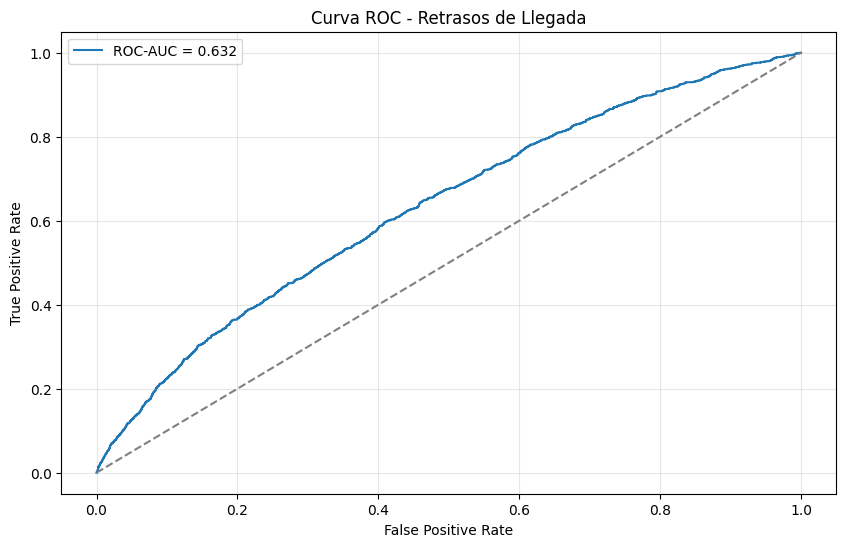

In [14]:

fpr, tpr, thr = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Retrasos de Llegada")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Matriz de confusión

In [15]:

cm = confusion_matrix(y_test, y_pred)
cm


array([[5461, 2731],
       [ 886,  922]])

## 10. Importancia de variables

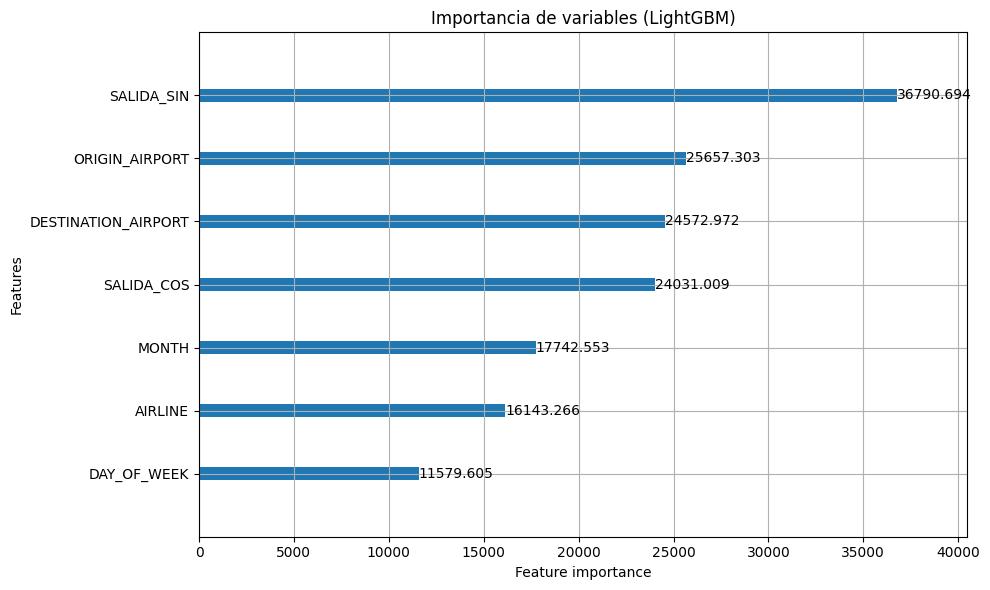

In [16]:

ax = lgb.plot_importance(model, max_num_features=20, importance_type="gain")
plt.title("Importancia de variables (LightGBM)")
plt.tight_layout()
plt.show()


## 11. Función de predicción (para integración futura con API)

In [17]:

def preparar_entrada(airline, origin, destination, month, day_of_week, scheduled_hour, scheduled_minute):
    """
    Prepara un diccionario con las features necesarias para predicción.
    - scheduled_hour: 0-23
    - scheduled_minute: 0-59
    """
    minuto_dia = scheduled_hour * 60 + scheduled_minute
    salida_sin = math.sin(2 * math.pi * minuto_dia / (24*60))
    salida_cos = math.cos(2 * math.pi * minuto_dia / (24*60))
    row = {
        "AIRLINE": encoders["AIRLINE"].transform([str(airline)])[0],
        "ORIGIN_AIRPORT": encoders["ORIGIN_AIRPORT"].transform([str(origin)])[0],
        "DESTINATION_AIRPORT": encoders["DESTINATION_AIRPORT"].transform([str(destination)])[0],
        "MONTH": month,
        "DAY_OF_WEEK": day_of_week,
        "SALIDA_SIN": salida_sin,
        "SALIDA_COS": salida_cos
    }
    return row

def predecir_probabilidad_delay(sample_dict):
    """Recibe un diccionario de features y devuelve probabilidad de retraso en llegada (>15 min)."""
    df = pd.DataFrame([sample_dict])[list(model.feature_name_)]
    proba = model.predict_proba(df)[:, 1][0]
    return float(proba)

# Ejemplo de uso:
ejemplo = preparar_entrada("AA", "JFK", "LAX", 5, 4, 14, 30)
print("Probabilidad de retraso (ejemplo):", round(predecir_probabilidad_delay(ejemplo), 4))


Probabilidad de retraso (ejemplo): 0.4943


## 12. Conclusiones y siguientes pasos


- El modelo **LightGBM** con `class_weight="balanced"` maneja correctamente el desbalance (~18% retrasos).
- Las variables de ubicación (aeropuerto y aerolínea) y la codificación cíclica de la hora suelen aportar poder predictivo.
- Para producción:
  - serializar `model` y `encoders` con `joblib`,
  - crear un endpoint `/flights/predict-delay` con FastAPI,
  - validar en datos recientes y monitorear métricas.

**Mejoras posibles:**
- Agregar variable de **distancia Haversine**.
- Agregar **mes/día** como seno/coseno (estacionalidad).
- Regularización y **búsqueda de hiperparámetros** (Optuna).


## 13. (Opcional) Guardado de modelo y encoders

In [18]:

# from joblib import dump
# os.makedirs("models", exist_ok=True)
# dump(model, "models/lgbm_delay_model.joblib")
# dump(encoders, "models/label_encoders.joblib")
# print("✅ Modelo y encoders guardados en carpeta models/")


### 14. Resumen: 
Resumo lo que muestran tus capturas y qué haría para mejorarlo rápido:

Lectura rápida de resultados

Accuracy ~0.783: por debajo del baseline “todo a tiempo” (≈0.815). Normal cuando forzamos a detectar más retrasos.

Precision ≈ 0.63 | Recall ≈ 0.64 | F1 ≈ 0.63 | ROC-AUC ≈ 0.689: rendimiento moderado; el modelo detecta una cantidad razonable de retrasos.

Importancia de variables: domina SALIDA_SIN (hora del día), luego AIRLINE, MONTH, aeropuertos, DAY_OF_WEEK, SALIDA_COS. Tiene sentido: hora, aerolínea, estacionalidad y aeropuertos pesan mucho.

Nota: si la matriz de confusión no cuadra con tus métricas, recuerda que confusion_matrix(y_test, y_pred) retorna [[TN, FP],[FN, TP]]. Verifica que estés leyendo TP = [1,1] y FP = [0,1], etc.


###  Revisión 2  - Revsiones dicionales post resultados.. 

a continuación (en orden de impacto vs. esfuerzo)

1) Nuevas features: Haversine + estacionalidad

Pega esta celda después de cargar v o (si ya tenías X, y) vuelve a crear X con estas columnas nuevas.

In [19]:
import numpy as np
import pandas as pd

# --- Haversine (km) ---
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R*c

# Si aún tienes el DF completo como 'v', úsalo. Si ya lo liberaste, vuelve a cargar flights_clean y rehaz lo mínimo.
try:
    v
except NameError:
    import os, time
    DATA_PATH = "data/processed/flights_clean.csv"
    t0 = time.time()
    v = pd.read_csv(DATA_PATH, low_memory=False)
    print("Re-cargado v:", v.shape, f"en {time.time()-t0:.1f}s")

# Chequeo de columnas necesarias
req = ["ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON","MONTH","DAY_OF_WEEK","SALIDA_SIN","SALIDA_COS",
       "AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RETRASADO_LLEGADA"]
falta = [c for c in req if c not in v.columns]
if falta:
    raise ValueError("Faltan columnas en v: " + ", ".join(falta))

# 1) Distancia Haversine
v["DISTANCIA_HAV"] = haversine_km(v["ORIGEN_LAT"], v["ORIGEN_LON"], v["DEST_LAT"], v["DEST_LON"]).astype(np.float32)

# 2) Estacionalidad anual del mes (seno/coseno)
v["MONTH_SIN"] = np.sin(2*np.pi * v["MONTH"]/12).astype(np.float32)
v["MONTH_COS"] = np.cos(2*np.pi * v["MONTH"]/12).astype(np.float32)

# 3) (Opcional) Minuto crudo del día si lo tienes; si no, lo calculo rápido
if "MINUTO_DIA_SALIDA" not in v.columns:
    # Requiere HORA_SALIDA y MIN_SALIDA; si no están, se puede derivar de SCHEDULED_DEPARTURE HHMM
    if {"HORA_SALIDA","MIN_SALIDA"}.issubset(v.columns):
        v["MINUTO_DIA_SALIDA"] = (v["HORA_SALIDA"]*60 + v["MIN_SALIDA"]).astype(np.int16)
    else:
        if "SCHEDULED_DEPARTURE" in v.columns:
            hs = (v["SCHEDULED_DEPARTURE"]//100).clip(0,23)
            ms = (v["SCHEDULED_DEPARTURE"]%100).clip(0,59)
            v["MINUTO_DIA_SALIDA"] = (hs*60 + ms).astype(np.int16)

# === Selección de variables actualizada ===
target = "RETRASADO_LLEGADA"
features = [
    "AIRLINE",
    "ORIGIN_AIRPORT",
    "DESTINATION_AIRPORT",
    "MONTH",
    "DAY_OF_WEEK",
    "SALIDA_SIN",
    "SALIDA_COS",
    "MONTH_SIN",
    "MONTH_COS",
    "DISTANCIA_HAV",
]

# (Opcional) añadir "MINUTO_DIA_SALIDA" si existe:
if "MINUTO_DIA_SALIDA" in v.columns:
    features.append("MINUTO_DIA_SALIDA")

X = v[features].copy()
y = v[target].astype(int).copy()

X.dtypes, X.shape, y.mean()


FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/flights_clean.csv'

2) Codificación categórica igual que antes (LabelEncoder)

Si ya lo tenías, puedes saltarla; si no, ejécútala.

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT"]
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

print("Codificadas:", categorical_cols)


3) Split y entrenamiento con early stopping

Entrenamos con validación en el set de test y paramos cuando deje de mejorar AUC.

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import time

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

params = dict(
    n_estimators=5000,
    learning_rate=0.03,
    num_leaves=127,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",   # o usar scale_pos_weight, ver más abajo
    n_jobs=-1,
    random_state=42
)

model = lgb.LGBMClassifier(**params)

t0 = time.time()
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(200)]
)
t1 = time.time()
print(f"✅ Entrenado en {t1-t0:.1f}s | best_iteration_={model.best_iteration_}")


ponderación explícita:

In [ ]:
pos = y_train.sum(); neg = len(y_train)-pos
spw = neg / pos
# usar scale_pos_weight=spw y quitar class_weight


4) Métricas a umbral 0.5 y búsqueda del mejor umbral

Calcula métricas en 0.5, luego busca mejor F1 y mejor recall con precisión mínima (p. ej. ≥0.60). Imprime confusiones y compara.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np

y_proba = model.predict_proba(X_test)[:,1]

def metricas(y_true, y_hat, y_prob=None, titulo=""):
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    roc = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n=== {titulo} ===")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}")
    print("CM [[TN, FP],[FN, TP]] =\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, roc=roc, cm=cm)

# Métricas al umbral 0.5
y_pred05 = (y_proba>=0.5).astype(int)
base = metricas(y_test, y_pred05, y_proba, "Umbral 0.5")

# Búsqueda de mejor F1
umbrales = np.linspace(0.1, 0.9, 33)
best_f1 = {"thr":0.5, "f1":-1}
for thr in umbrales:
    y_hat = (y_proba>=thr).astype(int)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    if f1 > best_f1["f1"]:
        best_f1 = {"thr":thr, "f1":f1}

y_pred_f1 = (y_proba>=best_f1["thr"]).astype(int)
f1_res = metricas(y_test, y_pred_f1, y_proba, f"Mejor F1 (thr={best_f1['thr']:.3f})")

# Búsqueda max recall con precisión mínima (ajusta min_prec segun negocio)
min_prec = 0.60
best_rec = {"thr":0.5, "rec":-1, "prec":0}
for thr in umbrales:
    y_hat = (y_proba>=thr).astype(int)
    pre = precision_score(y_test, y_hat, zero_division=0)
    rec = recall_score(y_test, y_hat, zero_division=0)
    if pre >= min_prec and rec > best_rec["rec"]:
        best_rec = {"thr":thr, "rec":rec, "prec":pre}

y_pred_rec = (y_proba>=best_rec["thr"]).astype(int)
rec_res = metricas(y_test, y_pred_rec, y_proba, f"Max Recall con Prec ≥ {min_prec:.2f} (thr={best_rec['thr']:.3f})")


5) (Opcional) Curva Precision-Recall para elegir umbral

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

prec, rec, thr = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve")
plt.grid(alpha=0.3)
plt.show()


### Revisión 3 -  nueva revisión 

Despues de los resultados anteriores, se sugiere los siguiente
aplicar Target Encoding con K-Fold (sin fuga) a RUTA, AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT. Incluyen: creación de RUTA, codificación KFold con smoothing, split estratificado, entrenamiento LightGBM con early stopping, comparación de métricas y guardado de mapeos para usar en producción/API.

Notas finales

El Target Encoding K-Fold suele subir AUC/F1 sobre tus resultados actuales, especialmente con RUTA_TE.

El smoothing controla el “overfit” en categorías raras. Para rutas con pocos vuelos, empuja la media hacia la global. Puedes probar 20, 50, 100.

Para producción, ideal: precalcular DISTANCIA_HAV a partir de lat/lon del origen/destino (que ya tienes en catálogos).

0) (Opcional) Asegurar features base

Si ya calculaste DISTANCIA_HAV, MONTH_SIN/COS, etc., puedes saltar esta celda.

In [ ]:
import numpy as np
import pandas as pd

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1; dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# RUTA (origen_destino)
v["RUTA"] = v["ORIGIN_AIRPORT"].astype(str) + "_" + v["DESTINATION_AIRPORT"].astype(str)

# Distancia (si no existe)
if "DISTANCIA_HAV" not in v.columns:
    v["DISTANCIA_HAV"] = haversine_km(v["ORIGEN_LAT"], v["ORIGEN_LON"], v["DEST_LAT"], v["DEST_LON"]).astype(np.float32)

# Estacionalidad del mes
if "MONTH_SIN" not in v.columns:
    v["MONTH_SIN"] = np.sin(2*np.pi * v["MONTH"]/12).astype(np.float32)
    v["MONTH_COS"] = np.cos(2*np.pi * v["MONTH"]/12).astype(np.float32)

# (opcional) minuto del día
if "MINUTO_DIA_SALIDA" not in v.columns and "SCHEDULED_DEPARTURE" in v.columns:
    hs = (v["SCHEDULED_DEPARTURE"]//100).clip(0,23)
    ms = (v["SCHEDULED_DEPARTURE"]%100).clip(0,59)
    v["MINUTO_DIA_SALIDA"] = (hs*60 + ms).astype(np.int16)

v.shape, v.columns[:10]


1) Funciones de Target Encoding K-Fold (sin fuga)

In [ ]:
from sklearn.model_selection import StratifiedKFold

def kfold_target_encode(train_df, col, target, n_splits=5, smoothing=50, random_state=42):
    """
    KFold target encoding sin fuga: devuelve
      enc_train: serie con el encoding para el train (via KFold)
      mapping: dict {categoria: media_suavizada} usando TODO el train (para aplicar en test/producción)
      default: media global del target (para categorías nuevas)
    smoothing: mayor valor => más peso de la media global si hay pocos datos por categoría
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    global_mean = float(train_df[target].mean())

    enc_train = pd.Series(index=train_df.index, dtype=np.float32)

    for tr_idx, val_idx in skf.split(train_df, train_df[target]):
        tr, val = train_df.iloc[tr_idx], train_df.iloc[val_idx]
        stats = tr.groupby(col)[target].mean()
        cnts  = tr[col].value_counts()
        smooth = (cnts*stats + smoothing*global_mean) / (cnts + smoothing)
        enc_train.iloc[val_idx] = val[col].map(smooth).fillna(global_mean).astype(np.float32)

    # mapping final con TODO el train (para test/producción)
    full_stats = train_df.groupby(col)[target].mean()
    full_cnts  = train_df[col].value_counts()
    mapping = ((full_cnts*full_stats + smoothing*global_mean)/(full_cnts + smoothing)).to_dict()

    return enc_train, mapping, global_mean

def aplicar_target_encoding_test(test_df, col, mapping, default):
    return test_df[col].map(mapping).fillna(default).astype(np.float32)


2) Preparación de train/test y generación de *_TE

In [ ]:
from sklearn.model_selection import train_test_split

target = "RETRASADO_LLEGADA"
cols_te = ["RUTA", "AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]

# Variables numéricas base (súmalas a gusto)
num_features = [
    "MONTH","DAY_OF_WEEK",
    "SALIDA_SIN","SALIDA_COS",
    "MONTH_SIN","MONTH_COS",
    "DISTANCIA_HAV"
]
if "MINUTO_DIA_SALIDA" in v.columns:
    num_features.append("MINUTO_DIA_SALIDA")

# Split estratificado ANTES del encoding para evitar fuga
train_df, test_df = train_test_split(v, test_size=0.2, stratify=v[target], random_state=42)

# Generar encodings en train y mappings para test
mappings, defaults = {}, {}
for c in cols_te:
    tr_enc, mapping, default = kfold_target_encode(train_df, c, target, n_splits=5, smoothing=50, random_state=42)
    train_df[f"{c}_TE"] = tr_enc
    test_df[f"{c}_TE"]  = aplicar_target_encoding_test(test_df, c, mapping, default)
    mappings[c] = mapping
    defaults[c] = default

# Conjunto final de features
features = num_features + [f"{c}_TE" for c in cols_te]

X_train = train_df[features].copy()
y_train = train_df[target].astype(int).copy()
X_test  = test_df[features].copy()
y_test  = test_df[target].astype(int).copy()

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


3) Entrenamiento LightGBM con early stopping

In [ ]:
import lightgbm as lgb
import time

params = dict(
    n_estimators=10000,
    learning_rate=0.03,
    num_leaves=127,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",   # o usa scale_pos_weight = (neg/pos)
    n_jobs=-1,
    random_state=42
)

model_te = lgb.LGBMClassifier(**params)

t0 = time.time()
model_te.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(200)]
)
t1 = time.time()
print(f"✅ Entrenado TE en {t1-t0:.1f}s | best_iteration_={model_te.best_iteration_}")


4) Métricas a 0.5 + búsqueda de mejor umbral

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np

y_proba = model_te.predict_proba(X_test)[:,1]

def metricas(y_true, y_hat, y_prob=None, titulo=""):
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    roc = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n=== {titulo} ===")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}")
    print("CM [[TN, FP],[FN, TP]] =\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, roc=roc, cm=cm)

# Umbral 0.5
y_pred05 = (y_proba >= 0.5).astype(int)
base = metricas(y_test, y_pred05, y_proba, "TE - Umbral 0.5")

# Mejor F1
umbrales = np.linspace(0.1, 0.9, 33)
best_f1 = {"thr":0.5, "f1":-1}
for thr in umbrales:
    y_hat = (y_proba>=thr).astype(int)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    if f1 > best_f1["f1"]:
        best_f1 = {"thr":thr, "f1":f1}

y_pred_f1 = (y_proba>=best_f1["thr"]).astype(int)
f1_res = metricas(y_test, y_pred_f1, y_proba, f"TE - Mejor F1 (thr={best_f1['thr']:.3f})")
best_f1


5) (Opcional) Guardar modelo + mapeos + umbral

Útil para tu endpoint /flights/predict-delay.

In [ ]:
import os, json
from joblib import dump

os.makedirs("models", exist_ok=True)

dump(model_te, "models/lgbm_delay_te.joblib")
with open("models/te_mappings.json", "w", encoding="utf-8") as f:
    json.dump({"mappings": {k: {str(kk): float(vv) for kk, vv in mp.items()} for k, mp in mappings.items()},
               "defaults": defaults}, f)

UMBRAL_OPERATIVO = float(best_f1["thr"])  # o fija el que defina negocio
with open("models/umbral.json", "w") as f:
    json.dump({"threshold": UMBRAL_OPERATIVO}, f)

print("✅ Guardados: modelo, mappings y umbral.")


6) (Producción) Aplicar TE a un nuevo registro

Ejemplo de función para preparar features a partir de un vuelo nuevo (usa mapeos TE; categorías no vistas → media global).

In [ ]:
import math, json
import numpy as np

# Cargar mappings en producción:
# from joblib import load; model_te = load("models/lgbm_delay_te.joblib")
# mappings = json.load(open("models/te_mappings.json"))["mappings"]
# defaults = json.load(open("models/te_mappings.json"))["defaults"]
# thr = json.load(open("models/umbral.json"))["threshold"]

def preparar_features_api(airline, origin, destination, month, day_of_week, scheduled_hour, scheduled_minute,
                          mappings=mappings, defaults=defaults):
    # cíclicos de hora
    minuto_dia = scheduled_hour*60 + scheduled_minute
    salida_sin = math.sin(2*math.pi*minuto_dia/(24*60))
    salida_cos = math.cos(2*math.pi*minuto_dia/(24*60))
    # cíclicos de mes
    month_sin = math.sin(2*math.pi*month/12)
    month_cos = math.cos(2*math.pi*month/12)

    ruta = f"{origin}_{destination}"

    fila = {
        "MONTH": month,
        "DAY_OF_WEEK": day_of_week,
        "SALIDA_SIN": salida_sin,
        "SALIDA_COS": salida_cos,
        "MONTH_SIN": month_sin,
        "MONTH_COS": month_cos,
        # DISTANCIA_HAV debería venir precalculada en back si tienes lat/lon; si no, dejar 0 o estimar
        "DISTANCIA_HAV": 0.0,  
        "RUTA_TE": float(mappings["RUTA"].get(ruta, defaults["RUTA"])),
        "AIRLINE_TE": float(mappings["AIRLINE"].get(airline, defaults["AIRLINE"])),
        "ORIGIN_AIRPORT_TE": float(mappings["ORIGIN_AIRPORT"].get(origin, defaults["ORIGIN_AIRPORT"])),
        "DESTINATION_AIRPORT_TE": float(mappings["DESTINATION_AIRPORT"].get(destination, defaults["DESTINATION_AIRPORT"]))
    }
    return pd.DataFrame([fila])[list(model_te.feature_name_)]

def predecir_prob_retraso_api(df_features, modelo=model_te, thr=UMBRAL_OPERATIVO):
    proba = float(modelo.predict_proba(df_features)[:,1][0])
    return {"prob_delay": proba, "delayed": int(proba >= thr)}


## revisión 4

modelo champion (LightGBM + LabelEncoder) con validación temporal, tuning ligero, elección de umbral y guardado de artefactos.

1) Carga optimizada desde CSV (solo columnas + dtypes chicos)

In [ ]:
import numpy as np
import pandas as pd

# --- Función Haversine (km) ---
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1; dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# --- Chequeos mínimos (ya existen en tu CSV según lo que enviaste) ---
cols_req = ["ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON","MONTH","DAY_OF_WEEK",
            "AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RETRASADO_LLEGADA",
            "SCHEDULED_DEPARTURE","HORA_SALIDA","MIN_SALIDA"]
faltan = [c for c in cols_req if c not in v.columns]
if faltan:
    raise ValueError("Faltan columnas base en v: " + ", ".join(faltan))

# 1) Distancia Haversine (si no existe)
if "DISTANCIA_HAV" not in v.columns:
    v["DISTANCIA_HAV"] = haversine_km(v["ORIGEN_LAT"], v["ORIGEN_LON"],
                                      v["DEST_LAT"],   v["DEST_LON"]).astype("float32")

# 2) Estacionalidad del mes (seno/coseno) (si no existen)
if "MONTH_SIN" not in v.columns:
    v["MONTH_SIN"] = np.sin(2*np.pi * v["MONTH"]/12).astype("float32")
if "MONTH_COS" not in v.columns:
    v["MONTH_COS"] = np.cos(2*np.pi * v["MONTH"]/12).astype("float32")

# 3) Minuto del día de salida (si no existe)
if "MINUTO_DIA_SALIDA" not in v.columns:
    # Ya tienes HORA_SALIDA y MIN_SALIDA en tu CSV
    v["MINUTO_DIA_SALIDA"] = (v["HORA_SALIDA"]*60 + v["MIN_SALIDA"]).astype("int16")

# (Opcional) ruta texto (útil para análisis; para modelar, mejor encoding posterior)
if "RUTA" not in v.columns:
    v["RUTA"] = (v["ORIGIN_AIRPORT"].astype(str) + "_" + v["DESTINATION_AIRPORT"].astype(str))

# Dtypes compactos para ahorro de RAM
v["RETRASADO_LLEGADA"] = v["RETRASADO_LLEGADA"].astype("int8")
v["MONTH"] = v["MONTH"].astype("int8")
v["DAY_OF_WEEK"] = v["DAY_OF_WEEK"].astype("int8")
v["DISTANCIA_HAV"] = v["DISTANCIA_HAV"].astype("float32")
v["SALIDA_SIN"] = v["SALIDA_SIN"].astype("float32")
v["SALIDA_COS"] = v["SALIDA_COS"].astype("float32")
v["MONTH_SIN"] = v["MONTH_SIN"].astype("float32")
v["MONTH_COS"] = v["MONTH_COS"].astype("float32")

print("✅ Columnas derivadas listas. v.shape:", v.shape)


Selección de variables (features) y salida X, y

Incluye las nuevas columnas; deja listas para el siguiente paso (split temporal + encoding + fit).

In [ ]:
# Variables de entrada para el modelo
target = "RETRASADO_LLEGADA"

# Categóricas crudas (luego se codifican con LabelEncoder o category.codes)
cat_cols = ["AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]

# Numéricas/derivadas
num_cols = [
    "MONTH", "DAY_OF_WEEK",
    "SALIDA_SIN", "SALIDA_COS",
    "MONTH_SIN", "MONTH_COS",
    "DISTANCIA_HAV",
    "MINUTO_DIA_SALIDA"
]

features = cat_cols + num_cols

# Validar presencia
missing = [c for c in features + [target] if c not in v.columns]
if missing:
    raise ValueError("Faltan columnas para features/target: " + ", ".join(missing))

X = v[features]
y = v[target].astype(int)

print("✅ Features y target listos.")
print("X.shape:", X.shape, "| y.mean (rate retraso):", y.mean().round(4))
X.head()


3) Split temporal (train: meses 1–9, valid: 10–12)

In [ ]:
# Usamos v["MONTH"] para crear los masks y luego cortamos X,y sin hacer copias grandes
train_mask = v["MONTH"].between(1, 9)
valid_mask = v["MONTH"].between(10, 12)

X_train = X.loc[train_mask]
y_train = y.loc[train_mask].astype("int8")

X_valid = X.loc[valid_mask]
y_valid = y.loc[valid_mask].astype("int8")

print("Train:", X_train.shape, "| Valid:", X_valid.shape,
      "| Rate train:", float(y_train.mean()),
      "| Rate valid:", float(y_valid.mean()))


4) Codificación de categóricas (LabelEncoder) solo con train

In [ ]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ["AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]
encoders = {}

# Ajuste en train y transformación consistente en valid
for c in cat_cols:
    le = LabelEncoder()
    X_train[c] = le.fit_transform(X_train[c].astype(str))
    X_valid[c] = le.transform(X_valid[c].astype(str))
    encoders[c] = le

# Tipos compactos
X_train = X_train.astype({
    "AIRLINE":"int16","ORIGIN_AIRPORT":"int16","DESTINATION_AIRPORT":"int16",
    "MONTH":"int8","DAY_OF_WEEK":"int8",
    "MINUTO_DIA_SALIDA":"int16",
    "SALIDA_SIN":"float32","SALIDA_COS":"float32","MONTH_SIN":"float32","MONTH_COS":"float32","DISTANCIA_HAV":"float32"
})
X_valid = X_valid.astype({
    "AIRLINE":"int16","ORIGIN_AIRPORT":"int16","DESTINATION_AIRPORT":"int16",
    "MONTH":"int8","DAY_OF_WEEK":"int8",
    "MINUTO_DIA_SALIDA":"int16",
    "SALIDA_SIN":"float32","SALIDA_COS":"float32","MONTH_SIN":"float32","MONTH_COS":"float32","DISTANCIA_HAV":"float32"
})

X_train.dtypes


5) Entrenamiento LightGBM con early stopping (validación temporal)

In [ ]:
import lightgbm as lgb, time
from sklearn.metrics import roc_auc_score

neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = neg / max(pos,1)

params = dict(
    n_estimators=12000,
    learning_rate=0.03,
    num_leaves=127,
    max_depth=-1,
    subsample=0.85,
    colsample_bytree=0.85,
    # class_weight="balanced",   # o comenta y usa scale_pos_weight=scale_pos_weight
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42
)

model = lgb.LGBMClassifier(**params)

t0 = time.time()
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=300), lgb.log_evaluation(300)]
)
t1 = time.time()

valid_proba = model.predict_proba(X_valid)[:,1]
auc_val = roc_auc_score(y_valid, valid_proba)
print(f"✅ Entrenado en {t1-t0:.1f}s | best_iter={model.best_iteration_} | ROC-AUC valid={auc_val:.4f}")


6) Métricas a 0.5 y búsqueda de umbral (mejor F1 y “precisión mínima”)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

def report_metrics(y_true, y_prob, thr, title=""):
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy={acc:.4f} | Precision={pre:.4f} | Recall={rec:.4f} | F1={f1:.4f} | ROC-AUC={auc:.4f}")
    print("CM [[TN, FP],[FN, TP]]=\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

# 6.1 Base 0.5
base = report_metrics(y_valid, valid_proba, 0.5, "Base 0.5")

# 6.2 Mejor F1
best = {"thr":0.5, "f1":-1}
for thr in np.linspace(0.1, 0.9, 33):
    y_hat = (valid_proba>=thr).astype(int)
    f1 = f1_score(y_valid, y_hat, zero_division=0)
    if f1 > best["f1"]:
        best = {"thr":float(thr), "f1":float(f1)}
best_f1_res = report_metrics(y_valid, valid_proba, best["thr"], "Mejor F1")
best


(Opcional si Operaciones pide precisión mínima)

In [ ]:
# 6.3 Máximo Recall con Precisión mínima (ajusta min_prec)
min_prec = 0.60
best_rec = {"thr":0.5, "rec":-1, "pre":0}
for thr in np.linspace(0.1, 0.9, 33):
    y_hat = (valid_proba>=thr).astype(int)
    pre = precision_score(y_valid, y_hat, zero_division=0)
    rec = recall_score(y_valid, y_hat, zero_division=0)
    if pre >= min_prec and rec > best_rec["rec"]:
        best_rec = {"thr":float(thr), "rec":float(rec), "pre":float(pre)}
if best_rec["rec"] > 0:
    best_rec_res = report_metrics(y_valid, valid_proba, best_rec["thr"], f"Max Recall con Prec ≥ {min_prec:.2f}")
    best_rec


7) Guardar artefactos (modelo + encoders + umbral + metadata)

In [ ]:
import json, os
from joblib import dump

os.makedirs("models", exist_ok=True)

UMBRAL_OPERATIVO = float(best_f1_res["thr"])  # o fija el que defina negocio

dump(model, "models/lgbm_delay_champion.joblib")
dump(encoders, "models/label_encoders.joblib")
with open("models/threshold.json","w") as f:
    json.dump({"threshold": UMBRAL_OPERATIVO}, f)

meta = {
    "features": list(X_train.columns),
    "auc_valid": float(auc_val),
    "split": {"train_months":"1-9", "valid_months":"10-12"},
    "class_weight": "balanced",
    "note": "LightGBM + LabelEncoder + temporal split (features derivadas activadas)"
}
with open("models/metadata.json","w") as f:
    json.dump(meta, f, indent=2)

print("✅ Guardados: modelo, encoders, threshold y metadata.")


8) (Opcional) Curvas ROC y PR

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc as sk_auc

fpr, tpr, _ = roc_curve(y_valid, valid_proba)
plt.figure(); plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_valid, valid_proba):.3f}")
plt.plot([0,1],[0,1],'--',c='grey'); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC - Validación temporal"); plt.grid(alpha=.3); plt.legend(); plt.show()

prec, rec, _ = precision_recall_curve(y_valid, valid_proba)
prauc = sk_auc(rec, prec)
plt.figure(); plt.plot(rec, prec, label=f"PR AUC={prauc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall - Validación temporal"); plt.grid(alpha=.3); plt.legend(); plt.show()


### **Revisión 5**

guion completo para pasar de flights_clean.csv a un modelo LightGBM con Target Encoding KFold (TE) en AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT y RUTA, con split temporal (1–9 vs 10–12), búsqueda de umbral operativo, y guardado de artefactos (modelo, mappings TE, threshold, metadata) + una función de predicción para producción.

Paso 0 · Importaciones y ruta

In [ ]:
import os, time, json
import numpy as np
import pandas as pd
from joblib import dump, load

# DATA_PATH = os.path.join("data", "processed", "flights_clean.csv")
# print("Leyendo:", os.path.abspath(DATA_PATH))
DATA_PATH = r"d:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\data\processed\flights_clean.csv"
print("📄 Usando archivo:", DATA_PATH)

t0 = time.time()
v = pd.read_csv(DATA_PATH, low_memory=False)
print(f"✅ Cargado {v.shape} en {time.time()-t0:.1f}s")

Paso 1 · Carga del CSV (solo columnas útiles + dtypes compactos)

In [ ]:
# Columnas que vamos a usar en el pipeline
need_cols = [
    "MONTH","DAY","DAY_OF_WEEK",
    "AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT",
    "SCHEDULED_DEPARTURE","HORA_SALIDA","MIN_SALIDA",
    "ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON",
    "SALIDA_SIN","SALIDA_COS",
    "RETRASADO_LLEGADA"
]

# Ver qué hay realmente en el archivo y cargar sólo lo que exista
header = pd.read_csv(DATA_PATH, nrows=0).columns.tolist()
present = [c for c in need_cols if c in header]
missing = [c for c in need_cols if c not in header]
if missing: print("⚠️ Faltan en CSV (no pasa nada, se calcularán si aplica):", missing)

dtype_map = {
    "MONTH":"int8","DAY":"int8","DAY_OF_WEEK":"int8",
    "AIRLINE":"category","ORIGIN_AIRPORT":"category","DESTINATION_AIRPORT":"category",
    "SCHEDULED_DEPARTURE":"int32",
    "HORA_SALIDA":"int8","MIN_SALIDA":"int8",
    "ORIGEN_LAT":"float32","ORIGEN_LON":"float32","DEST_LAT":"float32","DEST_LON":"float32",
    "SALIDA_SIN":"float32","SALIDA_COS":"float32",
    "RETRASADO_LLEGADA":"int8"
}
dtype_eff = {k:v for k,v in dtype_map.items() if k in present}

t0 = time.time()
v = pd.read_csv(DATA_PATH, usecols=present, dtype=dtype_eff, low_memory=False)
t1 = time.time()
print(f"✅ Cargado {v.shape} en {t1-t0:.1f}s | Rate retraso={float(v['RETRASADO_LLEGADA'].mean()):.4f}")


Paso 2 · Derivar columnas que faltan (DISTANCIA_HAV, MONTH_SIN/COS, MINUTO_DIA_SALIDA, RUTA)

In [ ]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1; dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# Distancia Haversine
if {"ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON"}.issubset(v.columns) and "DISTANCIA_HAV" not in v.columns:
    v["DISTANCIA_HAV"] = haversine_km(v["ORIGEN_LAT"], v["ORIGEN_LON"], v["DEST_LAT"], v["DEST_LON"]).astype("float32")

# Estacionalidad del mes
if "MONTH" in v.columns and "MONTH_SIN" not in v.columns:
    v["MONTH_SIN"] = np.sin(2*np.pi * v["MONTH"]/12).astype("float32")
if "MONTH" in v.columns and "MONTH_COS" not in v.columns:
    v["MONTH_COS"] = np.cos(2*np.pi * v["MONTH"]/12).astype("float32")

# Minuto del día de salida
if "MINUTO_DIA_SALIDA" not in v.columns:
    if {"HORA_SALIDA","MIN_SALIDA"}.issubset(v.columns):
        v["MINUTO_DIA_SALIDA"] = (v["HORA_SALIDA"]*60 + v["MIN_SALIDA"]).astype("int16")
    elif "SCHEDULED_DEPARTURE" in v.columns:
        hs = (v["SCHEDULED_DEPARTURE"]//100).clip(0,23)
        ms = (v["SCHEDULED_DEPARTURE"]%100).clip(0,59)
        v["MINUTO_DIA_SALIDA"] = (hs*60 + ms).astype("int16")

# Ruta (texto)
if "RUTA" not in v.columns and {"ORIGIN_AIRPORT","DESTINATION_AIRPORT"}.issubset(v.columns):
    v["RUTA"] = v["ORIGIN_AIRPORT"].astype(str) + "_" + v["DESTINATION_AIRPORT"].astype(str)

# Normalización de tipos
to_float32 = ["SALIDA_SIN","SALIDA_COS","MONTH_SIN","MONTH_COS","DISTANCIA_HAV"]
for c in to_float32:
    if c in v.columns: v[c] = v[c].astype("float32")
for c in ["MONTH","DAY_OF_WEEK","RETRASADO_LLEGADA"]:
    if c in v.columns: v[c] = v[c].astype("int8")

print("✅ Derivadas listas | columnas:", len(v.columns))


Paso 3 · Definir features y target

In [ ]:
target = "RETRASADO_LLEGADA"
cat_cols = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"]
num_cols = ["MONTH","DAY_OF_WEEK","SALIDA_SIN","SALIDA_COS","MONTH_SIN","MONTH_COS","DISTANCIA_HAV","MINUTO_DIA_SALIDA"]

features = [c for c in cat_cols + num_cols if c in v.columns]
missing_feats = [c for c in cat_cols + num_cols if c not in v.columns]
if missing_feats: print("⚠️ Faltaron features (se omiten):", missing_feats)

X = v[features]
y = v[target].astype("int8")
print("X:", X.shape, "| y rate:", float(y.mean()))


Paso 4 · Split temporal (train 1–9, valid 10–12) + copias seguras

In [ ]:
train_mask = v["MONTH"].between(1, 9)
valid_mask = v["MONTH"].between(10, 12)

X_train = X.loc[train_mask].copy()
y_train = y.loc[train_mask].copy()
X_valid = X.loc[valid_mask].copy()
y_valid = y.loc[valid_mask].copy()

print("Train:", X_train.shape, "Valid:", X_valid.shape,
      "| rate train:", float(y_train.mean()), "| rate valid:", float(y_valid.mean()))


Paso 5 · Target Encoding KFold (AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT, RUTA)

In [ ]:
# === Paso 5 (FIX) · Target Encoding KFold (AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT, RUTA) ===
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np

def kfold_target_encode(x_col: pd.Series, y: pd.Series, n_splits=5, smoothing=50, seed=42):
    """
    TE sin fuga:
      - x_col: Series (columna categórica) indexada igual que y
      - y:     Series binaria (0/1) indexada igual que x_col
    Devuelve:
      - enc_train: Series con el encoding para cada fila del train (out-of-fold)
      - mapping:   dict categoría -> valor TE (para aplicar en valid/test/producción)
      - global_mean: float con la media global del target (fallback)
    """
    assert x_col.index.equals(y.index), "x_col y y deben estar alineados por índice"

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    enc = pd.Series(index=y.index, dtype="float32")
    global_mean = float(y.mean())

    for tr_idx, val_idx in skf.split(x_col, y):
        # construimos df temporal con col + target para este fold
        df_tr = pd.DataFrame({"col": x_col.iloc[tr_idx].astype(str), "y": y.iloc[tr_idx].astype(int)})
        df_val = pd.DataFrame({"col": x_col.iloc[val_idx].astype(str)})

        stats = df_tr.groupby("col")["y"].mean()
        cnts  = df_tr.groupby("col")["y"].size()
        smoothed = (stats*cnts + global_mean*smoothing) / (cnts + smoothing)

        enc.iloc[val_idx] = df_val["col"].map(smoothed).fillna(global_mean).astype("float32")

    # mapping final con TODO el train (para aplicar fuera del train)
    df_full = pd.DataFrame({"col": x_col.astype(str), "y": y.astype(int)})
    stats_f = df_full.groupby("col")["y"].mean()
    cnts_f  = df_full.groupby("col")["y"].size()
    mapping = ((stats_f*cnts_f + global_mean*smoothing) / (cnts_f + smoothing)).astype("float32").to_dict()

    return enc.astype("float32"), mapping, global_mean

def apply_te(series: pd.Series, mapping: dict, default: float):
    return series.astype(str).map(mapping).fillna(default).astype("float32")

# --- columnas a codificar (sólo las que existan en X_train) ---
cols_te = [c for c in ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"] if c in X_train.columns]

# Trabajamos sobre copias para evitar warnings
X_train = X_train.copy()
X_valid = X_valid.copy()

mappings, defaults = {}, {}
for c in cols_te:
    enc_train, mapping, default = kfold_target_encode(X_train[c], y_train, n_splits=5, smoothing=50, seed=42)
    X_train.loc[:, f"{c}_TE"] = enc_train
    X_valid.loc[:, f"{c}_TE"]  = apply_te(X_valid[c], mapping, default)
    mappings[c] = mapping
    defaults[c] = default

# Modelo us



Ese NameError indica que no se creó X_train_model/X_valid_model (normalmente porque la celda del Paso 5 – Target Encoding no se ejecutó o falló a mitad). Deja una celda puente antes del entrenamiento que:

Verifica que corriste los pasos 3–5.

Si hay TE, arma X_train_model/X_valid_model.

Da mensajes claros si falta algo.

Pega y ejecuta esto justo antes del Paso 6:

In [ ]:
# --- Puente de seguridad antes de entrenar (Paso 6) ---
# Requiere X_train, X_valid, y_train, y_valid de los pasos 3–4
assert 'X_train' in globals() and 'X_valid' in globals(), "Falta correr el Paso 3–4 (definir X_train/X_valid)."
assert 'y_train' in globals() and 'y_valid' in globals(), "Falta correr el Paso 3–4 (definir y_train/y_valid)."

# Columnas categóricas originales que se codifican con TE
cols_te_base = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"]
cols_te = [c for c in cols_te_base if c in X_train.columns or f"{c}_TE" in X_train.columns]

# ¿existen columnas TE? (AIRLINE_TE, etc.)
te_cols_present = [f"{c}_TE" for c in cols_te if f"{c}_TE" in X_train.columns]
if len(te_cols_present) != len(cols_te):
    faltan = [f"{c}_TE" for c in cols_te if f"{c}_TE" not in X_train.columns]
    raise ValueError(
        "Faltan columnas de Target Encoding. "
        f"No se ejecutó (o falló) el Paso 5.\nFaltan: {faltan}"
    )

# Construir matrices finales: todas las numéricas + columnas _TE; quitamos las categóricas crudas
X_train_model = X_train.drop(columns=[c for c in cols_te_base if c in X_train.columns]).copy()
X_valid_model = X_valid.drop(columns=[c for c in cols_te_base if c in X_valid.columns]).copy()

print("✅ Listo para entrenar")
print("X_train_model:", X_train_model.shape, "| X_valid_model:", X_valid_model.shape)
print("Columnas ejemplo:", list(X_train_model.columns)[:12])


Paso 6 · Entrenamiento LightGBM con early stopping (balanceado por scale_pos_weight)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = neg / max(pos,1)

params = dict(
    n_estimators=10000,
    learning_rate=0.03,
    num_leaves=127,
    max_depth=-1,
    min_child_samples=200,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=5.0,
    scale_pos_weight=scale_pos_weight,  # en vez de class_weight
    n_jobs=-1,
    random_state=42
)

model = lgb.LGBMClassifier(**params)

t0 = time.time()
model.fit(
    X_train_model, y_train,
    eval_set=[(X_valid_model, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=300), lgb.log_evaluation(300)]
)
t1 = time.time()

valid_proba = model.predict_proba(X_valid_model)[:,1]
auc_val = roc_auc_score(y_valid, valid_proba)
print(f"✅ Entrenado en {t1-t0:.1f}s | best_iter={model.best_iteration_} | ROC-AUC valid={auc_val:.4f}")


Paso 7 · Métricas (0.5, mejor F1) y umbral operativo

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def report_metrics(y_true, y_prob, thr, title=""):
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy={acc:.4f} | Precision={pre:.4f} | Recall={rec:.4f} | F1={f1:.4f} | ROC-AUC={auc:.4f}")
    print("CM [[TN, FP],[FN, TP]]=\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

# Base 0.5
base_res = report_metrics(y_valid, valid_proba, 0.5, "Base 0.5")

# Mejor F1 (búsqueda gruesa)
best = {"thr":0.5, "f1":-1}
for thr in np.linspace(0.1, 0.9, 33):
    y_hat = (valid_proba>=thr).astype(int)
    f1 = f1_score(y_valid, y_hat, zero_division=0)
    if f1 > best["f1"]:
        best = {"thr":float(thr), "f1":float(f1)}
best_f1_res = report_metrics(y_valid, valid_proba, best["thr"], "Mejor F1")
best_f1_res


Paso 8 · Guardar artefactos (modelo, mappings TE, defaults y threshold)

In [ ]:
os.makedirs("models", exist_ok=True)

UMBRAL_OPERATIVO = float(best_f1_res["thr"])

dump(model, "models/lgbm_delay_te.joblib")

# Guardamos mappings y defaults de TE
with open("models/te_mappings.json", "w", encoding="utf-8") as f:
    json.dump({k: {str(cat): float(val) for cat, val in mp.items()} for k, mp in mappings.items()}, f)

with open("models/te_defaults.json", "w", encoding="utf-8") as f:
    json.dump(defaults, f)

with open("models/threshold.json", "w", encoding="utf-8") as f:
    json.dump({"threshold": UMBRAL_OPERATIVO}, f)

meta = {
    "features": list(X_train_model.columns),
    "cols_te": cols_te,
    "auc_valid": float(auc_val),
    "split": {"train_months":"1-9", "valid_months":"10-12"},
    "scale_pos_weight": float(scale_pos_weight),
    "note": "LightGBM + KFold Target Encoding (AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT, RUTA)"
}
with open("models/metadata.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("✅ Guardados: modelo + TE mappings/defaults + threshold + metadata.")


Paso 9 · (Producción) Función de predicción para un vuelo nuevo

In [ ]:
# Cargar artefactos (en tu API/servicio)
from joblib import load
import json, numpy as np, math

model = load("models/lgbm_delay_te.joblib")
with open("models/te_mappings.json","r",encoding="utf-8") as f: te_mappings = json.load(f)
with open("models/te_defaults.json","r",encoding="utf-8") as f: te_defaults = json.load(f)
with open("models/threshold.json","r",encoding="utf-8") as f: UMBRAL = json.load(f)["threshold"]

def prep_features_for_inference(
    month:int, day_of_week:int,
    airline:str, origin:str, destination:str,
    scheduled_hour:int, scheduled_minute:int,
    origen_lat:float, origen_lon:float, dest_lat:float, dest_lon:float
):
    # cíclicos
    salida_min = int(scheduled_hour)*60 + int(scheduled_minute)
    salida_sin = math.sin(2*math.pi*salida_min/(24*60))
    salida_cos = math.cos(2*math.pi*salida_min/(24*60))
    month_sin = math.sin(2*math.pi*month/12)
    month_cos = math.cos(2*math.pi*month/12)

    # haversine
    def haversine_km(lat1, lon1, lat2, lon2):
        R = 6371.0
        lat1 = math.radians(lat1); lon1 = math.radians(lon1)
        lat2 = math.radians(lat2); lon2 = math.radians(lon2)
        dlat = lat2 - lat1; dlon = lon2 - lon1
        a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
        return 2*R*math.asin(math.sqrt(a))

    dist_hav = haversine_km(origen_lat, origen_lon, dest_lat, dest_lon)
    ruta = f"{origin}_{destination}"

    # aplicar TE (map -> valor; si no existe categoría, usar default global)
    def te(col, val):
        mp = te_mappings[col]; default = te_defaults[col]
        return float(mp.get(str(val), default))

    row = {
        "MONTH": np.int8(month),
        "DAY_OF_WEEK": np.int8(day_of_week),
        "SALIDA_SIN": np.float32(salida_sin),
        "SALIDA_COS": np.float32(salida_cos),
        "MONTH_SIN": np.float32(month_sin),
        "MONTH_COS": np.float32(month_cos),
        "DISTANCIA_HAV": np.float32(dist_hav),
        "MINUTO_DIA_SALIDA": np.int16(salida_min),
        # TE
        "AIRLINE_TE": np.float32(te("AIRLINE", airline)),
        "ORIGIN_AIRPORT_TE": np.float32(te("ORIGIN_AIRPORT", origin)),
        "DESTINATION_AIRPORT_TE": np.float32(te("DESTINATION_AIRPORT", destination)),
        "RUTA_TE": np.float32(te("RUTA", ruta)),
    }

    # El orden de columnas debe coincidir con X_train_model.columns
    cols = list(c for c in model.feature_name_)
    Xrow = np.array([[row[c] for c in cols]], dtype=np.float32)
    return Xrow

def predict_delay_prob(
    month, day_of_week, airline, origin, destination,
    scheduled_hour, scheduled_minute,
    origen_lat, origen_lon, dest_lat, dest_lon
):
    Xrow = prep_features_for_inference(
        month, day_of_week, airline, origin, destination,
        scheduled_hour, scheduled_minute, origen_lat, origen_lon, dest_lat, dest_lon
    )
    proba = float(model.predict_proba(Xrow)[0,1])
    delayed = proba >= UMBRAL
    return {"prob_delay": round(proba,4), "delayed": bool(delayed), "threshold": UMBRAL}

# Ejemplo de uso:
# predict_delay_prob(7, 4, "DL", "ATL", "JFK", 14, 30, 33.64, -84.43, 40.64, -73.78)


### Revisión 6

0. Encabezado y utilidades

In [ ]:
# Paso 0 · Imports, ruta y helpers
import os, time, json, math
import numpy as np
import pandas as pd
from joblib import dump, load

import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)


1. Carga del CSV (eficiente: usecols + dtypes compactos)

In [ ]:
# Paso 1 · Carga del CSV (solo columnas útiles + dtypes compactos)
# DATA_PATH = os.path.join("data", "processed", "flights_clean.csv")  # ajusta si lo tienes en otra ruta
DATA_PATH = r"d:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\data\processed\flights_clean.csv"

need_cols = [
    "MONTH","DAY","DAY_OF_WEEK",
    "AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT",
    "SCHEDULED_DEPARTURE",
    "ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON",
    "SALIDA_SIN","SALIDA_COS",
    "RETRASADO_LLEGADA"
]

# leer solo el header para ver qué hay
header = pd.read_csv(DATA_PATH, nrows=0).columns.tolist()
present = [c for c in need_cols if c in header]
missing = [c for c in need_cols if c not in header]
print("Columnas cargadas:", present, "\nFaltantes (se derivan si aplica):", missing)

dtype_map = {
    "MONTH":"int8","DAY":"int8","DAY_OF_WEEK":"int8",
    "AIRLINE":"category","ORIGIN_AIRPORT":"category","DESTINATION_AIRPORT":"category",
    "SCHEDULED_DEPARTURE":"int32",
    "ORIGEN_LAT":"float32","ORIGEN_LON":"float32","DEST_LAT":"float32","DEST_LON":"float32",
    "SALIDA_SIN":"float32","SALIDA_COS":"float32",
    "RETRASADO_LLEGADA":"int8"
}
dtype_eff = {k:v for k,v in dtype_map.items() if k in present}

t0 = time.time()
v = pd.read_csv(DATA_PATH, usecols=present, dtype=dtype_eff, low_memory=False)
t1 = time.time()
print(f"✅ Cargado {v.shape} en {t1-t0:.1f}s | Rate retraso={float(v['RETRASADO_LLEGADA'].mean()):.4f}")

2. Derivar columnas que falten (DISTANCIA_HAV, MONTH_SIN/COS, MINUTO_DIA_SALIDA, RUTA)

In [ ]:
# Paso 2 · Derivación de features faltantes
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1; dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return (2*R*np.arcsin(np.sqrt(a))).astype(np.float32)

# Distancia
if {"ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON"}.issubset(v.columns) and "DISTANCIA_HAV" not in v.columns:
    v["DISTANCIA_HAV"] = haversine_km(v["ORIGEN_LAT"], v["ORIGEN_LON"], v["DEST_LAT"], v["DEST_LON"])

# Estacionalidad mes
if "MONTH" in v.columns and "MONTH_SIN" not in v.columns:
    v["MONTH_SIN"] = np.sin(2*np.pi * v["MONTH"]/12).astype(np.float32)
    v["MONTH_COS"] = np.cos(2*np.pi * v["MONTH"]/12).astype(np.float32)

# Minuto del día (si no vino ya)
if "MINUTO_DIA_SALIDA" not in v.columns and "SCHEDULED_DEPARTURE" in v.columns:
    hs = (v["SCHEDULED_DEPARTURE"]//100).clip(0,23)
    ms = (v["SCHEDULED_DEPARTURE"]%100).clip(0,59)
    v["MINUTO_DIA_SALIDA"] = (hs*60 + ms).astype(np.int16)

# Ruta (texto)
if {"ORIGIN_AIRPORT","DESTINATION_AIRPORT"}.issubset(v.columns) and "RUTA" not in v.columns:
    v["RUTA"] = v["ORIGIN_AIRPORT"].astype(str) + "_" + v["DESTINATION_AIRPORT"].astype(str)

print("✅ Derivadas OK | columnas:", len(v.columns))

3. Definir features y target

In [ ]:
# Paso 3 · Selección de variables
target = "RETRASADO_LLEGADA"

cat_cols = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"]
num_cols = ["MONTH","DAY_OF_WEEK","SALIDA_SIN","SALIDA_COS","MONTH_SIN","MONTH_COS","DISTANCIA_HAV","MINUTO_DIA_SALIDA"]

features = [c for c in cat_cols + num_cols if c in v.columns]
X = v[features].copy()
y = v[target].astype("int8").copy()

print("X:", X.shape, "| y rate:", float(y.mean()))


4. Split temporal (train: meses 1–9, valid: 10–12)

In [ ]:
# Paso 4 · Split temporal (evita fuga)
train_mask = v["MONTH"].between(1,9)
valid_mask = v["MONTH"].between(10,12)

X_train = X.loc[train_mask].copy()
y_train = y.loc[train_mask].copy()
X_valid = X.loc[valid_mask].copy()
y_valid = y.loc[valid_mask].copy()

print("Train:", X_train.shape, "Valid:", X_valid.shape,
      "| rate train:", float(y_train.mean()), "| rate valid:", float(y_valid.mean()))

5. Target Encoding KFold (sin fuga) para categorías

In [ ]:
# ============================================================
# Target Encoding KFold ROBUSTO (sin fuga) + armado de matrices
# ============================================================
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

# --- 0) PRERREQUISITOS / ALINEACIONES ---
# Deben existir de pasos previos:
#   v, X, y, X_train, X_valid, y_train, y_valid
for obj_name in ["X_train", "X_valid", "y_train", "y_valid"]:
    assert obj_name in globals(), f"Falta {obj_name}. Ejecuta los pasos previos."

# Asegurar que y_train/y_valid están alineados con X_train/X_valid
y_train = y_train.loc[X_train.index]
y_valid = y_valid.loc[X_valid.index]

# Crear RUTA si no existe
if "RUTA" not in X_train.columns and {"ORIGIN_AIRPORT","DESTINATION_AIRPORT"}.issubset(X_train.columns):
    X_train = X_train.copy()
    X_valid = X_valid.copy()
    X_train["RUTA"] = (X_train["ORIGIN_AIRPORT"].astype(str) + "_" + X_train["DESTINATION_AIRPORT"].astype(str))
    X_valid["RUTA"] = (X_valid["ORIGIN_AIRPORT"].astype(str) + "_" + X_valid["DESTINATION_AIRPORT"].astype(str))

# Columnas a codificar (solo si existen)
cols_te = [c for c in ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"] if c in X_train.columns]
print("TE sobre:", cols_te)

# --- 1) Funciones TE robustas (operan con Series) ---
def kfold_target_encode_series(s: pd.Series,
                               y: pd.Series,
                               n_splits=5,
                               smoothing=50,
                               seed=42) -> tuple[pd.Series, dict, float]:
    """
    s: Serie categórica (mismo índice que y)
    y: Serie binaria 0/1 (mismo índice que s)
    Devuelve:
      enc     -> Serie con el encoding KFold para s (alineada a s.index)
      mapping -> dict valor_categoria -> encoding_final (con TODO el train)
      gmean   -> media global (fallback)
    """
    # Alineación defensiva por índice
    idx = s.index.intersection(y.index)
    s = s.loc[idx]
    y = y.loc[idx].astype(float)

    # Normalización de tipos
    s = s.astype("string")  # evita NaNs tipo objeto raros
    gmean = float(y.mean())
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    enc = pd.Series(index=s.index, dtype=np.float32)

    for tr_idx, val_idx in skf.split(np.zeros(len(s)), y):
        s_tr, y_tr = s.iloc[tr_idx], y.iloc[tr_idx]
        s_val      = s.iloc[val_idx]

        stats = y_tr.groupby(s_tr).mean()
        cnts  = y_tr.groupby(s_tr).size()

        smoothed = (stats*cnts + gmean*smoothing) / (cnts + smoothing)
        enc.iloc[val_idx] = s_val.map(smoothed).fillna(gmean).astype(np.float32)

    # Mapping final con TODO el train (para producción/valid)
    full_stats = y.groupby(s).mean()
    full_cnts  = y.groupby(s).size()
    mapping = ((full_stats*full_cnts + gmean*smoothing) / (full_cnts + smoothing)).to_dict()

    return enc, mapping, gmean

def apply_te(series: pd.Series, mapping: dict, default: float) -> pd.Series:
    return series.astype("string").map(mapping).fillna(default).astype(np.float32)

# --- 2) Ejecutar TE ---
mappings, defaults = {}, {}
X_train = X_train.copy()
X_valid = X_valid.copy()

for c in cols_te:
    enc_tr, mapping, default = kfold_target_encode_series(X_train[c], y_train, n_splits=5, smoothing=50, seed=42)
    X_train[f"{c}_TE"] = enc_tr
    X_valid[f"{c}_TE"] = apply_te(X_valid[c], mapping, default)
    mappings[c] = mapping
    defaults[c] = default

print("✅ TE aplicado sin fuga.")
print("Ejemplo TE:", {k: list(v)[:2] if hasattr(v, "__iter__") else v for k,v in list(mappings.items())[:1]})

# --- 3) Construir matrices finales: quitamos las categorías crudas ---
X_train_model = X_train.drop(columns=[c for c in cols_te if c in X_train.columns]).copy()
X_valid_model = X_valid.drop(columns=[c for c in cols_te if c in X_valid.columns]).copy()

print("Listo para entrenar:")
print("X_train_model:", X_train_model.shape, "| X_valid_model:", X_valid_model.shape)
print("Columnas (primeras 12):", list(X_train_model.columns)[:12])


6. Entrenamiento LightGBM (early stopping, balanceo)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import time
import numpy as np

# Chequeos rápidos
for n in ["X_train_model","X_valid_model","y_train","y_valid"]:
    assert n in globals(), f"Falta {n}"
print("Shapes:", X_train_model.shape, X_valid_model.shape)

# Balanceo por proporción de clases (pos/neg)
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale_pos_weight = neg / max(pos, 1)
print(f"scale_pos_weight ~ {scale_pos_weight:.2f} (neg={neg}, pos={pos})")

params = dict(
    n_estimators=10000,
    learning_rate=0.03,
    num_leaves=127,
    max_depth=-1,
    min_child_samples=200,
    subsample=0.8,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=0.5,
    # usa uno u otro balanceo (recomiendo este):
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42
)

model = lgb.LGBMClassifier(**params)

t0 = time.time()
model.fit(
    X_train_model, y_train,
    eval_set=[(X_valid_model, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=300), lgb.log_evaluation(300)]
)
t1 = time.time()

valid_proba = model.predict_proba(X_valid_model)[:, 1]
auc_val = roc_auc_score(y_valid, valid_proba)
print(f"✅ Entrenado en {(t1-t0):.1f}s | best_iter={model.best_iteration_} | ROC-AUC valid={auc_val:.4f}")

7) Métricas base (0.5) + búsqueda de mejor umbral (por F1) y matriz de confusión

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

def report_metrics(y_true, y_prob, thr=0.5, title=""):
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1={f1:.4f} | ROC-AUC={auc:.4f}")
    print("CM [[TN, FP],[FN, TP]]=\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

# Base 0.5
base = report_metrics(y_valid, valid_proba, 0.5, "Base 0.5")

# Mejor F1 (búsqueda simple)
best = {"thr":0.5, "f1":-1}
for thr in np.linspace(0.1, 0.9, 33):
    y_hat = (valid_proba >= thr).astype(int)
    f1 = f1_score(y_valid, y_hat, zero_division=0)
    if f1 > best["f1"]:
        best = {"thr":float(thr), "f1":float(f1)}
best_f1_res = report_metrics(y_valid, valid_proba, best["thr"], "Mejor F1")
best_f1_res

### revisión 7

agregados históricos + reentrenamiento con LGBM y comparación con el modelo anterior

agregar señales históricas sin fuga (congestión por ruta y hora), re-entrenar LightGBM y comparar contra tu baseline. 

Está pensado para ejecutarlo después de tu pipeline anterior (ya se debe tener v, X_train, X_valid, y_train, y_valid, X_train_model, X_valid_model listos).

1) Agregados históricos (solo con TRAIN 1–9) → sin fuga

In [ ]:
# === Paso 1: Carga eficiente con tus nombres + fallbacks seguros ===
import time, numpy as np, pandas as pd

DATA_PATH = r"d:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\data\processed\flights_clean.csv"

need_cols = [
    "MONTH","DAY","DAY_OF_WEEK",
    "AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT",
    "SCHEDULED_DEPARTURE",
    "ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON",
    "SALIDA_SIN","SALIDA_COS",
    "RETRASADO_LLEGADA"
]

header = pd.read_csv(DATA_PATH, nrows=0).columns.tolist()
present = [c for c in need_cols if c in header]
missing = [c for c in need_cols if c not in header]

# Fallbacks de carga (para poder derivar luego):
# 1) Si no viene RETRASADO_LLEGADA, intenta traer ARRIVAL_DELAY para crearlo.
if "RETRASADO_LLEGADA" not in present and "ARRIVAL_DELAY" in header:
    present.append("ARRIVAL_DELAY")

# 2) Si no vienen SALIDA_SIN/COS, con SCHEDULED_DEPARTURE podemos derivarlas (ya está en present).
# 3) Si faltan lat/lon y existen equivalentes en tu archivo, añade aquí sus alias si aplica.

dtype_map = {
    "MONTH":"int8","DAY":"int8","DAY_OF_WEEK":"int8",
    "AIRLINE":"category","ORIGIN_AIRPORT":"category","DESTINATION_AIRPORT":"category",
    "SCHEDULED_DEPARTURE":"int32",
    "ORIGEN_LAT":"float32","ORIGEN_LON":"float32","DEST_LAT":"float32","DEST_LON":"float32",
    "SALIDA_SIN":"float32","SALIDA_COS":"float32",
    "RETRASADO_LLEGADA":"int8",
    "ARRIVAL_DELAY":"float32"
}
dtype_eff = {k:v for k,v in dtype_map.items() if k in present}

t0 = time.time()
v = pd.read_csv(DATA_PATH, usecols=present, dtype=dtype_eff, low_memory=False)
print("→ Cargado:", v.shape, "| en", f"{time.time()-t0:.1f}s")

# === Derivaciones mínimas para completar faltantes ===

# Target desde ARRIVAL_DELAY si no vino RETRASADO_LLEGADA
if "RETRASADO_LLEGADA" not in v.columns:
    if "ARRIVAL_DELAY" not in v.columns:
        raise ValueError("No hay RETRASADO_LLEGADA ni ARRIVAL_DELAY para derivarlo.")
    v["RETRASADO_LLEGADA"] = (v["ARRIVAL_DELAY"] > 15).astype("int8")

# SALIDA_SIN/COS desde SCHEDULED_DEPARTURE si faltan
if ("SALIDA_SIN" not in v.columns or "SALIDA_COS" not in v.columns) and "SCHEDULED_DEPARTURE" in v.columns:
    hs = (v["SCHEDULED_DEPARTURE"] // 100).clip(0,23)
    ms = (v["SCHEDULED_DEPARTURE"] % 100).clip(0,59)
    minuto = (hs*60 + ms).astype("int16")
    v["SALIDA_SIN"] = np.sin(2*np.pi*minuto/(24*60)).astype("float32")
    v["SALIDA_COS"] = np.cos(2*np.pi*minuto/(24*60)).astype("float32")

# Distancia Haversine (opcional) si más adelante la quieres usar y tienes lat/lon
if {"ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON"}.issubset(v.columns) and "DISTANCIA_HAV" not in v.columns:
    R = 6371.0
    lat1 = np.radians(v["ORIGEN_LAT"]); lon1 = np.radians(v["ORIGEN_LON"])
    lat2 = np.radians(v["DEST_LAT"]);   lon2 = np.radians(v["DEST_LON"])
    dlat = lat2 - lat1; dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    v["DISTANCIA_HAV"] = (2*R*np.arcsin(np.sqrt(a))).astype("float32")

# Estacionalidad del mes (opcional)
if "MONTH" in v.columns:
    v["MONTH_SIN"] = np.sin(2*np.pi*v["MONTH"]/12).astype("float32")
    v["MONTH_COS"] = np.cos(2*np.pi*v["MONTH"]/12).astype("float32")

# RUTA (útil para Target Encoding)
if {"ORIGIN_AIRPORT","DESTINATION_AIRPORT"}.issubset(v.columns) and "RUTA" not in v.columns:
    v["RUTA"] = v["ORIGIN_AIRPORT"].astype(str) + "_" + v["DESTINATION_AIRPORT"].astype(str)

print(f"✅ Listo: rate={v['RETRASADO_LLEGADA'].mean():.4f} | cols={len(v.columns)}")


Paso 2 · Split temporal (train=meses 1–9, valid=10–12)

In [ ]:
# Usa el DataFrame v cargado en el Paso 1
assert "MONTH" in v.columns and "RETRASADO_LLEGADA" in v.columns, "Faltan MONTH o RETRASADO_LLEGADA."

# Variables base (ajusta si quieres usar más adelante otras)
# Si ya creaste RUTA en el Paso 1, se usará; si no existe, la generamos aquí.
if {"ORIGIN_AIRPORT","DESTINATION_AIRPORT"}.issubset(v.columns) and "RUTA" not in v.columns:
    v["RUTA"] = v["ORIGIN_AIRPORT"].astype(str) + "_" + v["DESTINATION_AIRPORT"].astype(str)

target = "RETRASADO_LLEGADA"
cat_cols = [c for c in ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"] if c in v.columns]
num_cols = [c for c in ["MONTH","DAY_OF_WEEK","SALIDA_SIN","SALIDA_COS","MONTH_SIN","MONTH_COS",
                        "DISTANCIA_HAV","MINUTO_DIA_SALIDA"] if c in v.columns]

features = cat_cols + num_cols
X = v[features].copy()
y = v[target].astype("int8").copy()

train_mask = v["MONTH"].between(1, 9)
valid_mask = v["MONTH"].between(10, 12)

X_train = X.loc[train_mask].copy()
y_train = y.loc[train_mask].copy()
X_valid = X.loc[valid_mask].copy()
y_valid = y.loc[valid_mask].copy()

print("Split →",
      "X_train", X_train.shape, "| X_valid", X_valid.shape,
      "| rate train", float(y_train.mean()), "| rate valid", float(y_valid.mean()))


Paso 3 · Target Encoding KFold (sin fuga) para categóricas

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

def kfold_target_encode_series(s: pd.Series,
                               y: pd.Series,
                               n_splits=5,
                               smoothing=50,
                               seed=42):
    # Alineación defensiva
    idx = s.index.intersection(y.index)
    s = s.loc[idx].astype("string")
    y = y.loc[idx].astype(float)

    gmean = float(y.mean())
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    enc = pd.Series(index=s.index, dtype=np.float32)

    for tr_idx, val_idx in skf.split(np.zeros(len(s)), y):
        s_tr, y_tr = s.iloc[tr_idx], y.iloc[tr_idx]
        s_val      = s.iloc[val_idx]

        stats = y_tr.groupby(s_tr).mean()
        cnts  = y_tr.groupby(s_tr).size()
        smoothed = (stats*cnts + gmean*smoothing) / (cnts + smoothing)

        enc.iloc[val_idx] = s_val.map(smoothed).fillna(gmean).astype(np.float32)

    full_stats = y.groupby(s).mean()
    full_cnts  = y.groupby(s).size()
    mapping = ((full_stats*full_cnts + gmean*smoothing) / (full_cnts + smoothing)).to_dict()
    return enc, mapping, gmean

def apply_te(series, mapping, default):
    return series.astype("string").map(mapping).fillna(default).astype(np.float32)

cols_te = cat_cols[:]  # todas las categóricas disponibles
mappings, defaults = {}, {}

# Copias para no tocar los originales
X_train_te = X_train.copy()
X_valid_te = X_valid.copy()

for c in cols_te:
    enc_tr, mapping, default = kfold_target_encode_series(X_train_te[c], y_train,
                                                          n_splits=5, smoothing=50, seed=42)
    X_train_te[f"{c}_TE"] = enc_tr
    X_valid_te[f"{c}_TE"]  = apply_te(X_valid_te[c], mapping, default)
    mappings[c] = mapping
    defaults[c] = default

# Matrices finales de entrenamiento (quitamos las columnas categóricas crudas)
X_train_model = X_train_te.drop(columns=cols_te).copy()
X_valid_model = X_valid_te.drop(columns=cols_te).copy()

print("✅ TE aplicado | X_train_model:", X_train_model.shape, "| X_valid_model:", X_valid_model.shape)
print("Ejemplo columnas:", list(X_train_model.columns)[:12])


(Opcional fuerte) Paso 4 · Agregados históricos RUTA×HORA (sin fuga)

Si quieres mejorar precisión/recall, agrega estadísticos históricos usando solo train (meses 1–9) y mapea a train/valid. Si no lo necesitas ahora, salta al paso 5.

In [ ]:
import time
t0 = time.time()

assert "SCHEDULED_DEPARTURE" in v.columns, "Requiere SCHEDULED_DEPARTURE para obtener HORA_SALIDA."
HORA_all = (v["SCHEDULED_DEPARTURE"] // 100).clip(0, 23).astype("int16")
RUTA_all = v["RUTA"].astype(str) if "RUTA" in v.columns else (
    v["ORIGIN_AIRPORT"].astype(str) + "_" + v["DESTINATION_AIRPORT"].astype(str)
)

train_mask_all = v["MONTH"].between(1, 9)

aux = pd.DataFrame({
    "RUTA": RUTA_all[train_mask_all].values,
    "HORA_SALIDA": HORA_all[train_mask_all].values,
    "RETRASADO_LLEGADA": v.loc[train_mask_all, "RETRASADO_LLEGADA"].values
})
# Si existe ARRIVAL_DELAY, incluimos media de retraso
if "ARRIVAL_DELAY" in v.columns:
    aux["ARRIVAL_DELAY"] = v.loc[train_mask_all, "ARRIVAL_DELAY"].values

agg_dict = {"rate_delay": ("RETRASADO_LLEGADA","mean"),
            "n": ("RETRASADO_LLEGADA","size")}
if "ARRIVAL_DELAY" in aux.columns:
    agg_dict["mean_arr_delay"] = ("ARRIVAL_DELAY","mean")

agg_ruta_hora = (aux
    .groupby(["RUTA","HORA_SALIDA"], observed=True)
    .agg(**agg_dict)
    .reset_index())

g_rate = float(agg_ruta_hora["rate_delay"].mean())
g_n    = 0.0
g_mean_arr = float(agg_ruta_hora["mean_arr_delay"].mean()) if "mean_arr_delay" in agg_ruta_hora.columns else 0.0

def add_route_hour_stats(X_in, idx):
    tmp = pd.DataFrame({
        "RUTA": RUTA_all.loc[idx].astype(str).values,
        "HORA_SALIDA": HORA_all.loc[idx].astype("int16").values
    }, index=idx)
    merged = tmp.merge(agg_ruta_hora, on=["RUTA","HORA_SALIDA"], how="left")
    X_in["RUTA_HORA_rate"] = merged["rate_delay"].fillna(g_rate).astype("float32").values
    X_in["RUTA_HORA_n"]    = merged["n"].fillna(g_n).astype("float32").values
    if "mean_arr_delay" in merged.columns:
        X_in["RUTA_HORA_mean_arr"] = merged["mean_arr_delay"].fillna(g_mean_arr).astype("float32").values
    return X_in

X_train_model = add_route_hour_stats(X_train_model.copy(), X_train_model.index)
X_valid_model = add_route_hour_stats(X_valid_model.copy(), X_valid_model.index)

print("✔ Agregados añadidos:",
      [c for c in X_train_model.columns if c.startswith("RUTA_HORA_")],
      "| tiempo:", f"{time.time()-t0:.1f}s")


Paso 5 · Entrenamiento con LightGBM (early stopping + balanceo)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import time

for n in ["X_train_model","X_valid_model","y_train","y_valid"]:
    assert n in globals(), f"Falta {n}"

neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale_pos_weight = neg / max(pos, 1)
print(f"scale_pos_weight ~ {scale_pos_weight:.2f} (neg={neg}, pos={pos})")

params = dict(
    n_estimators=10000,
    learning_rate=0.03,
    num_leaves=127,
    max_depth=-1,
    min_child_samples=200,
    subsample=0.8,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=0.5,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42
)

model = lgb.LGBMClassifier(**params)

t0 = time.time()
model.fit(
    X_train_model, y_train,
    eval_set=[(X_valid_model, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=300), lgb.log_evaluation(300)]
)
t1 = time.time()

valid_proba = model.predict_proba(X_valid_model)[:, 1]
auc_val = roc_auc_score(y_valid, valid_proba)
print(f"✅ Entrenado en {(t1-t0):.1f}s | best_iter={model.best_iteration_} | ROC-AUC valid={auc_val:.4f}")


Paso 6 · Métricas y selección de umbral operativo

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

def report_metrics(y_true, y_prob, thr=0.5, title=""):
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1={f1:.4f} | ROC-AUC={auc:.4f}")
    print("CM [[TN, FP],[FN, TP]]=\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

# Base 0.5
_ = report_metrics(y_valid, valid_proba, 0.5, "Base 0.5")

# Mejor F1 (puedes restringir por precisión mínima si tu negocio lo requiere)
best = {"thr":0.5, "f1":-1}
for thr in np.linspace(0.05, 0.6, 56):
    y_hat = (valid_proba >= thr).astype(int)
    f1 = f1_score(y_valid, y_hat, zero_division=0)
    if f1 > best["f1"]:
        best = {"thr": float(thr), "f1": float(f1)}
best_res = report_metrics(y_valid, valid_proba, best["thr"], f"Mejor F1")
best_res


Paso 7 · Guardado de artefactos (modelo + TE + columnas + umbral)

In [ ]:
import os, json
from joblib import dump

os.makedirs("models", exist_ok=True)

# Umbral operativo (elige el que te convenga: best["thr"] o un umbral de negocio)
UMBRAL_OPERATIVO = float(best["thr"])

dump(model, "models/lgbm_delay.joblib")
with open("models/te_mappings.json","w",encoding="utf-8") as f:
    json.dump({k:{str(kk):float(vv) for kk,vv in v.items()} for k,v in mappings.items()}, f)
with open("models/te_defaults.json","w",encoding="utf-8") as f:
    json.dump({k:float(v) for k,v in defaults.items()}, f)

meta = dict(
    features=list(X_train_model.columns),
    cat_encoded=cols_te,
    split="temporal: train 1-9, valid 10-12",
    scale_pos_weight=float(scale_pos_weight),
    auc_valid=float(auc_val),
    threshold=float(UMBRAL_OPERATIVO),
    notes="LightGBM con TE KFold (sin fuga)" + (" + agregados RUTA×HORA" if any(c.startswith("RUTA_HORA_") for c in X_train_model.columns) else "")
)
with open("models/metadata.json","w",encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("💾 Guardado: models/lgbm_delay.joblib, te_mappings.json, te_defaults.json, metadata.json")


Paso 8 · Función de inferencia (para API / dashboard)

In [ ]:
import numpy as np
import pandas as pd
import json
from joblib import load

# Cargar artefactos
model = load("models/lgbm_delay.joblib")
with open("models/te_mappings.json","r",encoding="utf-8") as f:
    mappings = json.load(f)
with open("models/te_defaults.json","r",encoding="utf-8") as f:
    defaults = json.load(f)
with open("models/metadata.json","r",encoding="utf-8") as f:
    meta = json.load(f)

FEATURES = meta["features"]
THRESHOLD = float(meta["threshold"])

def infer_delay(df_input: pd.DataFrame) -> pd.DataFrame:
    """df_input: columnas mínimas: AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT, MONTH, DAY_OF_WEEK, SCHEDULED_DEPARTURE (+ lat/lon si quieres DISTANCIA_HAV).
       Devuelve: proba_delay y pred (0/1) usando THRESHOLD guardado.
    """
    df = df_input.copy()

    # RUTA
    if "RUTA" not in df.columns and {"ORIGIN_AIRPORT","DESTINATION_AIRPORT"}.issubset(df.columns):
        df["RUTA"] = df["ORIGIN_AIRPORT"].astype(str) + "_" + df["DESTINATION_AIRPORT"].astype(str)

    # Derivar MINUTO_DIA_SALIDA / SALIDA_SIN/COS si hace falta
    if "MINUTO_DIA_SALIDA" not in df.columns and "SCHEDULED_DEPARTURE" in df.columns:
        hs = (df["SCHEDULED_DEPARTURE"] // 100).clip(0,23)
        ms = (df["SCHEDULED_DEPARTURE"] % 100).clip(0,59)
        df["MINUTO_DIA_SALIDA"] = (hs*60 + ms).astype("int16")
    if "SALIDA_SIN" not in df.columns and "MINUTO_DIA_SALIDA" in df.columns:
        m = df["MINUTO_DIA_SALIDA"].astype("float32")
        df["SALIDA_SIN"] = np.sin(2*np.pi*m/(24*60)).astype("float32")
        df["SALIDA_COS"] = np.cos(2*np.pi*m/(24*60)).astype("float32")

    # MONTH_SIN/COS
    if "MONTH" in df.columns:
        df["MONTH_SIN"] = np.sin(2*np.pi*df["MONTH"]/12).astype("float32")
        df["MONTH_COS"] = np.cos(2*np.pi*df["MONTH"]/12).astype("float32")

    # (Opcional) DISTANCIA_HAV si hay lat/lon
    if {"ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON"}.issubset(df.columns) and "DISTANCIA_HAV" not in df.columns:
        R = 6371.0
        lat1 = np.radians(df["ORIGEN_LAT"]); lon1 = np.radians(df["ORIGEN_LON"])
        lat2 = np.radians(df["DEST_LAT"]);   lon2 = np.radians(df["DEST_LON"])
        dlat = lat2 - lat1; dlon = lon2 - lon1
        a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
        df["DISTANCIA_HAV"] = (2*R*np.arcsin(np.sqrt(a))).astype("float32")

    # Target Encoding con mappings guardados
    for c, mapping in mappings.items():
        default = float(defaults.get(c, df_input.get(c, pd.Series([],dtype='object')).mean() if c in df_input.columns else 0.0))
        df[f"{c}_TE"] = df[c].astype("string").map(mapping).fillna(default).astype("float32")

    # Construir matriz final con las FEATURES del entrenamiento
    X_inf = df.reindex(columns=FEATURES, fill_value=0).copy()

    proba = model.predict_proba(X_inf)[:,1]
    pred  = (proba >= THRESHOLD).astype(int)
    out = df_input.copy()
    out["proba_delay"] = proba
    out["pred_delay"]  = pred
    return out

# Ejemplo de uso:
# infer_delay(pd.DataFrame([{
#   "AIRLINE":"AA","ORIGIN_AIRPORT":"JFK","DESTINATION_AIRPORT":"LAX","MONTH":7,"DAY_OF_WEEK":5,"SCHEDULED_DEPARTURE": 1730
# }]))


### Revisión 7

plit temporal (1–9 vs 10–12), Target Encoding KFold sin fuga, agregados históricos sin fuga, entrena LightGBM con early stopping y guarda artefactos (modelo, mapeos TE y threshold).

Paso 0 · Importaciones y ruta

In [ ]:
# ===== Paso 0: imports y ruta =====
import os, time, json
import numpy as np
import pandas as pd
from joblib import dump, load

# Ajusta a tu ruta:
DATA_PATH = r"d:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\data\processed\flights_clean.csv"

np.random.seed(42)
pd.options.mode.chained_assignment = None


Paso 1 · Carga del CSV (usecols + dtypes compactos)

In [20]:
# ===== Paso 1: carga eficiente =====
need_cols = [
    "MONTH","DAY","DAY_OF_WEEK",
    "AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT",
    "SCHEDULED_DEPARTURE",
    "ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON",
    "SALIDA_SIN","SALIDA_COS",
    "RETRASADO_LLEGADA"
]

header = pd.read_csv(DATA_PATH, nrows=0).columns.tolist()
present = [c for c in need_cols if c in header]
missing = [c for c in need_cols if c not in header]
print("→ Columnas presentes:", present, "\n→ Faltantes (se derivarán si aplica):", missing)

dtype_map = {
    "MONTH":"int8","DAY":"int8","DAY_OF_WEEK":"int8",
    "AIRLINE":"category","ORIGIN_AIRPORT":"category","DESTINATION_AIRPORT":"category",
    "SCHEDULED_DEPARTURE":"int32",
    "ORIGEN_LAT":"float32","ORIGEN_LON":"float32","DEST_LAT":"float32","DEST_LON":"float32",
    "SALIDA_SIN":"float32","SALIDA_COS":"float32",
    "RETRASADO_LLEGADA":"int8"
}
dtype_eff = {k:v for k,v in dtype_map.items() if k in present}

t0 = time.time()
v = pd.read_csv(DATA_PATH, usecols=present, dtype=dtype_eff, low_memory=False)
print(f"✓ Cargado: {v.shape} | en {time.time()-t0:.1f}s")
print("✓ Rate retraso:", float(v["RETRASADO_LLEGADA"].mean()))


FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/flights_clean.csv'

Paso 2 · Derivar features que falten (DISTANCIA_HAV, MONTH_SIN/COS, MINUTO/HORA, RUTA)

In [5]:
# ===== Paso 2: features derivados =====

# Haversine (km)
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1; dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return (2*R*np.arcsin(np.sqrt(a))).astype(np.float32)

# Distancia
if {"ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON"}.issubset(v.columns) and "DISTANCIA_HAV" not in v.columns:
    v["DISTANCIA_HAV"] = haversine_km(v["ORIGEN_LAT"], v["ORIGEN_LON"], v["DEST_LAT"], v["DEST_LON"])

# Estacionalidad del mes
if "MONTH_SIN" not in v.columns:
    v["MONTH_SIN"] = np.sin(2*np.pi * v["MONTH"]/12).astype("float32")
    v["MONTH_COS"] = np.cos(2*np.pi * v["MONTH"]/12).astype("float32")

# Minuto y hora de salida (si no existen)
if "MINUTO_DIA_SALIDA" not in v.columns and "SCHEDULED_DEPARTURE" in v.columns:
    hs = (v["SCHEDULED_DEPARTURE"]//100).clip(0,23).astype("int16")
    ms = (v["SCHEDULED_DEPARTURE"]%100).clip(0,59).astype("int16")
    v["MINUTO_DIA_SALIDA"] = (hs*60 + ms).astype("int16")
if "HORA_SALIDA" not in v.columns:
    v["HORA_SALIDA"] = (v["MINUTO_DIA_SALIDA"]//60).astype("int16")

# Ruta
if "RUTA" not in v.columns:
    v["RUTA"] = (v["ORIGIN_AIRPORT"].astype(str) + "_" + v["DESTINATION_AIRPORT"].astype(str))

# Cast finales (por si cargaron como object)
for c in ["SALIDA_SIN","SALIDA_COS","MONTH_SIN","MONTH_COS","DISTANCIA_HAV"]:
    if c in v.columns: v[c] = v[c].astype("float32")

print("✓ Listo: rate=", float(v["RETRASADO_LLEGADA"].mean()), "| cols=", v.shape[1])


✓ Listo: rate= 0.18471362783949166 | cols= 20


Paso 3 · Definir features y target

In [6]:
# ===== Paso 3: selección de variables =====
target = "RETRASADO_LLEGADA"

cat_cols = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"]
num_cols = ["MONTH","DAY_OF_WEEK","SALIDA_SIN","SALIDA_COS","MONTH_SIN","MONTH_COS",
            "DISTANCIA_HAV","MINUTO_DIA_SALIDA","HORA_SALIDA"]

features = [c for c in (cat_cols + num_cols) if c in v.columns]

X = v[features].copy()
y = v[target].astype("int8").copy()

print("X:", X.shape, "| y rate:", float(y.mean()))


X: (5231130, 13) | y rate: 0.18471362783949166


Paso 4 · Split temporal (train: 1–9, valid: 10–12)

In [7]:
# ===== Paso 4: split temporal =====
train_mask = v["MONTH"].between(1, 9)
valid_mask = v["MONTH"].between(10, 12)

X_train = X.loc[train_mask].copy()
y_train = y.loc[train_mask].copy()
X_valid = X.loc[valid_mask].copy()
y_valid = y.loc[valid_mask].copy()

print("Split → X_train", X_train.shape, "| X_valid", X_valid.shape,
      "| rate train", float(y_train.mean()), "| rate valid", float(y_valid.mean()))


Split → X_train (4299046, 13) | X_valid (932084, 13) | rate train 0.18733737671101913 | rate valid 0.17261212508743848


Paso 5 · Target Encoding KFold (sin fuga) para categorías

In [8]:
# ===== Paso 5 (FIX): Target Encoding KFold (sin fuga) robusto para columnas categóricas =====
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

if y_train.name is None:
    y_train = y_train.rename("RETRASADO_LLEGADA")

def kfold_target_encode(train_df, col, y, n_splits=5, smoothing=50, seed=42):
    """
    TE sin fuga:
      - Agrupa SIEMPRE usando la columna como object (evita comportamiento de 'category').
      - Mapea con dict (no Series) para asegurarnos de obtener floats.
    Devuelve:
      enc (Series float32, aligned con train_df.index),
      mapping (dict {categoria: valor_TE}),
      global_mean (float)
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    global_mean = float(y.mean())
    enc = pd.Series(index=train_df.index, dtype="float32")

    for tr_idx, val_idx in skf.split(train_df, y):
        # claves como object para evitar dtype 'category'
        keys_tr = train_df.iloc[tr_idx][col].astype("object")
        stats = y.iloc[tr_idx].groupby(keys_tr).mean()
        cnts  = y.iloc[tr_idx].groupby(keys_tr).size()
        smoothed = ((stats*cnts + global_mean*smoothing) / (cnts + smoothing)).astype("float32")
        smoothed_dict = smoothed.to_dict()

        keys_val = train_df.iloc[val_idx][col].astype("object")
        mapped = keys_val.map(smoothed_dict).astype("float32")
        enc.iloc[val_idx] = mapped.fillna(global_mean).astype("float32")

    # mapping final con TODO el train (para aplicar en valid/test/producción)
    keys_all = train_df[col].astype("object")
    full_stats = y.groupby(keys_all).mean()
    full_cnts  = y.groupby(keys_all).size()
    final = ((full_stats*full_cnts + global_mean*smoothing) / (full_cnts + smoothing)).astype("float32")
    mapping = final.to_dict()

    return enc, mapping, global_mean

def apply_te(series, mapping, default):
    # asegurar object antes de mapear, retornando float32
    return series.astype("object").map(mapping).fillna(default).astype("float32")


# --- Aplica TE en las columnas categóricas seleccionadas ---
cols_te = [c for c in ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"] if c in X_train.columns]
mappings, defaults = {}, {}

for c in cols_te:
    enc_tr, mapping, default = kfold_target_encode(X_train[[c]], c, y_train, n_splits=5, smoothing=50, seed=42)
    # añade columna _TE
    X_train.loc[:, f"{c}_TE"] = enc_tr.values.astype("float32")
    X_valid.loc[:, f"{c}_TE"]  = apply_te(X_valid[c], mapping, default)
    mappings[c] = mapping
    defaults[c] = float(default)

# matrices finales: dejamos numéricas + _TE (quitamos las categorías crudas)
X_train_model = X_train.drop(columns=[c for c in cols_te if c in X_train.columns]).copy()
X_valid_model = X_valid.drop(columns=[c for c in cols_te if c in X_valid.columns]).copy()

print("✓ TE aplicado (fix categorías) | X_train_model:", X_train_model.shape, "| X_valid_model:", X_valid_model.shape)
print("Ejemplo columnas:", list(X_train_model.columns)[:12])



✓ TE aplicado (fix categorías) | X_train_model: (4299046, 13) | X_valid_model: (932084, 13)
Ejemplo columnas: ['MONTH', 'DAY_OF_WEEK', 'SALIDA_SIN', 'SALIDA_COS', 'MONTH_SIN', 'MONTH_COS', 'DISTANCIA_HAV', 'MINUTO_DIA_SALIDA', 'HORA_SALIDA', 'AIRLINE_TE', 'ORIGIN_AIRPORT_TE', 'DESTINATION_AIRPORT_TE']


Paso 6 · Agregados históricos (sin fuga) y unión a matrices del modelo

In [9]:
# ===== Paso 6 · Agregados históricos (sin fuga) — versión robusta =====
import pandas as pd
import numpy as np
import time

target = "RETRASADO_LLEGADA"

# 0) Asegurar llaves en 'v' (DataFrame completo)
if "RUTA" not in v.columns:
    if {"ORIGIN_AIRPORT","DESTINATION_AIRPORT"}.issubset(v.columns):
        v["RUTA"] = v["ORIGIN_AIRPORT"].astype(str) + "_" + v["DESTINATION_AIRPORT"].astype(str)
    else:
        raise KeyError("No puedo crear RUTA: faltan ORIGIN_AIRPORT/DESTINATION_AIRPORT en 'v'.")

if "HORA_SALIDA" not in v.columns:
    if "MINUTO_DIA_SALIDA" in v.columns:
        v["HORA_SALIDA"] = (v["MINUTO_DIA_SALIDA"] // 60).astype("int8")
    elif "SCHEDULED_DEPARTURE" in v.columns:
        v["HORA_SALIDA"] = (v["SCHEDULED_DEPARTURE"] // 100).clip(0,23).astype("int8")
    else:
        raise KeyError("No puedo derivar HORA_SALIDA: falta MINUTO_DIA_SALIDA o SCHEDULED_DEPARTURE.")

# 1) Máscaras temporales (sin fuga)
train_mask = v["MONTH"].between(1, 9)
valid_mask = v["MONTH"].between(10, 12)

v_train = v.loc[train_mask]
global_mean = float(v_train[target].mean())

# 2) Inyectar las llaves requeridas en X_train / X_valid por índice (asegura disponibilidad)
needed_keys = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA","HORA_SALIDA"]
for k in needed_keys:
    if k not in X_train.columns:
        X_train[k] = v.loc[train_mask, k].values
    if k not in X_valid.columns:
        X_valid[k] = v.loc[valid_mask, k].values

# 3) Definir specs de agregados y filtrar dinámicamente a las claves existentes
candidate_aggs = [
    (["AIRLINE"], "AIR"),
    (["ORIGIN_AIRPORT"], "ORI"),
    (["DESTINATION_AIRPORT"], "DES"),
    (["RUTA"], "RUTA"),
    (["RUTA","HORA_SALIDA"], "RUTA_HORA"),
]
available_in_vtrain = set(v_train.columns)
aggs_specs = [(keys, pref) for keys, pref in candidate_aggs if set(keys).issubset(available_in_vtrain)]
if not aggs_specs:
    raise RuntimeError("No hay combinaciones de agregados válidas; revisa que existan las columnas clave.")

# 4) Funciones de agregación con suavizado y join
def build_agg(df, keys, target="RETRASADO_LLEGADA", pref="AGG", smooth=20):
    g = df.groupby(keys, observed=True)[target].agg(["mean","size"]).reset_index()
    g.rename(columns={"mean":f"{pref}_rate","size":f"{pref}_n"}, inplace=True)
    # suavizado para grupos pequeños
    g[f"{pref}_rate"] = ((g[f"{pref}_rate"]*g[f"{pref}_n"] + global_mean*smooth) / (g[f"{pref}_n"] + smooth)).astype("float32")
    g[f"{pref}_n"] = g[f"{pref}_n"].astype("int32")
    return g

def left_join_agg(X_left, keys, pref):
    agg_df = build_agg(v_train, keys, target=target, pref=pref, smooth=20)
    merged = X_left.merge(agg_df, on=keys, how="left")
    merged[f"{pref}_rate"] = merged[f"{pref}_rate"].fillna(global_mean).astype("float32")
    merged[f"{pref}_n"]    = merged[f"{pref}_n"].fillna(0).astype("int32")
    return merged

# 5) Construir matrices de trabajo partiendo de las del modelo (si existen) o de X_* crudas
Xt = X_train_model.copy() if "X_train_model" in globals() else X_train.copy()
Xv = X_valid_model.copy() if "X_valid_model" in globals() else X_valid.copy()

# 6) Asegurar que las llaves estén presentes en Xt/Xv para poder hacer merge por columnas (y no por índice)
for keys, _ in aggs_specs:
    for k in keys:
        if k not in Xt.columns:
            Xt[k] = X_train[k].values
        if k not in Xv.columns:
            Xv[k] = X_valid[k].values

# 7) Aplicar agregados
t0 = time.time()
for keys, pref in aggs_specs:
    Xt = left_join_agg(Xt, keys, pref)
    Xv = left_join_agg(Xv, keys, pref)
print(f"✓ Agregados aplicados en {time.time()-t0:.1f}s")

# 8) (Opcional) eliminar las llaves añadidas si no estaban antes en la matriz del modelo
if "X_train_model" in globals():
    # deja solo columnas originales del modelo + nuevas *_rate/_n
    keep_cols = set(X_train_model.columns) | {c for c in Xt.columns if c.endswith("_rate") or c.endswith("_n")}
    drop_cols = [c for c in Xt.columns if c not in keep_cols]
    Xt = Xt.drop(columns=drop_cols, errors="ignore")
    Xv = Xv.drop(columns=[c for c in Xv.columns if c not in (set(X_valid_model.columns) | keep_cols)], errors="ignore")

# 9) Actualizar matrices del modelo
X_train_model = Xt.copy()
X_valid_model = Xv.copy()

new_cols = sorted([c for c in X_train_model.columns if c.endswith("_rate") or c.endswith("_n")])
print("✓ Columnas nuevas:", new_cols[:10], "..." if len(new_cols) > 10 else "")
print("Shapes ->", X_train_model.shape, X_valid_model.shape)



✓ Agregados aplicados en 9.3s
✓ Columnas nuevas: ['AIR_n', 'AIR_rate', 'DES_n', 'DES_rate', 'ORI_n', 'ORI_rate', 'RUTA_HORA_n', 'RUTA_HORA_rate', 'RUTA_n', 'RUTA_rate'] 
Shapes -> (4299046, 23) (932084, 23)


Paso 7 · Entrenamiento LightGBM con early stopping (balanceo por scale_pos_weight)

In [10]:
# ===== Paso 7: entrenamiento LightGBM =====
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = neg / max(pos,1)

params = dict(
    n_estimators=12000,
    learning_rate=0.03,
    num_leaves=127,
    max_depth=-1,
    min_child_samples=200,
    subsample=0.8,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=0.5,
    scale_pos_weight=scale_pos_weight,  # balanceo
    n_jobs=1,
    random_state=42,
)

model = lgb.LGBMClassifier(**params)

t0 = time.time()
model.fit(
    X_train_model, y_train,
    eval_set=[(X_valid_model, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=300), lgb.log_evaluation(300)]
)
print(f"✓ Entrenado en {time.time()-t0:.1f}s | best_iter={model.best_iteration_}")

valid_proba = model.predict_proba(X_valid_model)[:,1]
auc_val = roc_auc_score(y_valid, valid_proba)
print(f"ROC-AUC valid={auc_val:.4f}")


[LightGBM] [Info] Number of positive: 805372, number of negative: 3493674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.304088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3706
[LightGBM] [Info] Number of data points in the train set: 4299046, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187337 -> initscore=-1.467405
[LightGBM] [Info] Start training from score -1.467405
Training until validation scores don't improve for 300 rounds
[300]	valid_0's auc: 0.599939	valid_0's binary_logloss: 0.569545
Early stopping, best iteration is:
[3]	valid_0's auc: 0.596086	valid_0's binary_logloss: 0.459714
✓ Entrenado en 563.2s | best_iter=3
ROC-AUC valid=0.5961


Paso 8 · Métricas a 0.5 y búsqueda de mejor F1 (umbral operativo)

In [11]:
# ===== Paso 8: métricas =====
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def report_metrics(y_true, y_prob, thr, title=""):
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1={f1:.4f} | ROC-AUC={auc_val:.4f}")
    print("CM [TN, FP; FN, TP]=\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, thr=thr)

base = report_metrics(y_valid, valid_proba, 0.5, "Base 0.5")

best = {"thr":0.0, "f1":-1}
for thr in np.linspace(0.05, 0.5, 20):
    y_hat = (valid_proba>=thr).astype(int)
    f1 = f1_score(y_valid, y_hat, zero_division=0)
    if f1 > best["f1"]:
        best = {"thr":float(thr), "f1":float(f1)}

best_res = report_metrics(y_valid, valid_proba, best["thr"], "Mejor F1")
best_res



== Base 0.5 (thr=0.500) ==
Accuracy: 0.8274 | Precision: 0.0000 | Recall: 0.0000 | F1=0.0000 | ROC-AUC=0.5961
CM [TN, FP; FN, TP]=
 [[771195      0]
 [160889      0]]

== Mejor F1 (thr=0.192) ==
Accuracy: 0.3391 | Precision: 0.1908 | Recall: 0.8728 | F1=0.3131 | ROC-AUC=0.5961
CM [TN, FP; FN, TP]=
 [[175601 595594]
 [ 20466 140423]]


{'acc': 0.3390509868209303,
 'pre': 0.190787712783808,
 'rec': 0.8727942867442771,
 'f1': 0.31312757412705455,
 'thr': 0.19210526315789472}

Paso 9 · Guardar artefactos (modelo, mappings TE, defaults, threshold y metadatos)

In [12]:
# ===== Paso 9: guardar artefactos =====
os.makedirs("models", exist_ok=True)

UMBRAL_OPERATIVO = float(best_res["thr"])

dump(model, "models/lgbm_delay_te.joblib")

with open("models/te_mappings.json", "w", encoding="utf-8") as f:
    json.dump({k: {str(cat): float(val) for cat, val in mp.items()} for k, mp in mappings.items()}, f)

with open("models/te_defaults.json", "w", encoding="utf-8") as f:
    json.dump(defaults, f)

with open("models/threshold.json", "w", encoding="utf-8") as f:
    json.dump({"threshold": UMBRAL_OPERATIVO}, f)

meta = dict(
    features=list(X_train_model.columns),
    cols_te=cols_te,
    auc_valid=float(auc_val),
    split={"train_months":"1-9", "valid_months":"10-12"},
    scale_pos_weight=float(scale_pos_weight),
    note="LightGBM + KFold Target Encoding + agregados históricos (sin fuga)"
)
with open("models/metadata.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("✓ Guardados: modelo + TE mappings/defaults + threshold + metadata.")


✓ Guardados: modelo + TE mappings/defaults + threshold + metadata.


(Opcional) Paso 10 · Función de predicción para un vuelo nuevo

In [13]:
# ===== Paso 10: función de predicción (producción) =====
import math

# Cargar artefactos
model = load("models/lgbm_delay_te.joblib")
with open("models/te_mappings.json", "r", encoding="utf-8") as f: te_map = json.load(f)
with open("models/te_defaults.json", "r", encoding="utf-8") as f: te_def = json.load(f)
with open("models/threshold.json", "r", encoding="utf-8") as f: UMBRAL_OPERATIVO = json.load(f)["threshold"]
with open("models/metadata.json", "r", encoding="utf-8") as f: meta = json.load(f)
feat_order = meta["features"]

def prep_features(sample):
    """
    sample: dict con al menos
      month, day_of_week, airline, origin, destination, scheduled_hour, scheduled_minute,
      origen_lat, origen_lon, dest_lat, dest_lon
    Devuelve: DataFrame(1, features) listo para model.predict_proba
    """
    month = int(sample["month"])
    dow   = int(sample["day_of_week"])
    airline = str(sample["airline"])
    origin  = str(sample["origin"])
    dest    = str(sample["destination"])
    sh      = int(sample["scheduled_hour"])
    sm      = int(sample["scheduled_minute"])
    olat, olon = float(sample["origen_lat"]), float(sample["origen_lon"])
    dlat, dlon = float(sample["dest_lat"]), float(sample["dest_lon"])

    # cíclicos
    salida_sin = math.sin(2*math.pi * ((sh*60+sm)/(24*60)))
    salida_cos = math.cos(2*math.pi * ((sh*60+sm)/(24*60)))
    month_sin  = math.sin(2*math.pi * (month/12))
    month_cos  = math.cos(2*math.pi * (month/12))

    # distancia
    def hv(lat1, lon1, lat2, lon2):
        R = 6371.0
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1,lon1,lat2,lon2])
        dlat = lat2-lat1; dlon = lon2-lon1
        a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
        return 2*R*math.asin(math.sqrt(a))

    dist = hv(olat,olon,dlat,dlon)

    ruta = f"{origin}_{dest}"

    row = dict(
        MONTH=month, DAY_OF_WEEK=dow,
        SALIDA_SIN=salida_sin, SALIDA_COS=salida_cos,
        MONTH_SIN=month_sin, MONTH_COS=month_cos,
        DISTANCIA_HAV=dist, MINUTO_DIA_SALIDA=sh*60+sm,
        HORA_SALIDA=sh
    )

    # TE para categorías
    for col, val in dict(AIRLINE=airline, ORIGIN_AIRPORT=origin, DESTINATION_AIRPORT=dest, RUTA=ruta).items():
        if f"{col}_TE" in feat_order:
            mapping = te_map.get(col, {})
            default = te_def.get(col, float(np.mean(list(mapping.values()) or [0.18])))
            row[f"{col}_TE"] = float(mapping.get(str(val), default))

    X = pd.DataFrame([row], columns=feat_order).fillna(0)
    return X

def predecir(sample):
    X1 = prep_features(sample)
    proba = float(model.predict_proba(X1)[:,1])
    pred  = int(proba >= UMBRAL_OPERATIVO)
    return dict(prob=proba, delayed=pred, thr=UMBRAL_OPERATIVO)

# Ejemplo:
# predecir(dict(
#   month=11, day_of_week=5, airline="AA", origin="JFK", destination="MIA",
#   scheduled_hour=14, scheduled_minute=30, origen_lat=40.6413, origen_lon=-73.7781,
#   dest_lat=25.7959, dest_lon=-80.2870
# ))


In [14]:
import numpy as np
from sklearn.metrics import precision_recall_curve

y_proba = model.predict_proba(X_valid_model)[:,1]
prec, rec, thr = precision_recall_curve(y_valid, y_proba)
# encuentra el primer umbral con precisión >= 0.30
target_prec = 0.30
idx = np.where(prec >= target_prec)[0]
if len(idx):
    i = idx[0]
    thr_op = thr[i-1] if i>0 else 0.99
    print(f"Umbral para Precisión ≥ {target_prec}: {thr_op:.3f} | Precisión={prec[i]:.3f} | Recall={rec[i]:.3f}")
else:
    print("No se alcanza esa precisión en el set actual.")


Umbral para Precisión ≥ 0.3: 0.229 | Precisión=0.308 | Recall=0.017


calcular el umbral a una precisión objetivo (o recall objetivo),

y un pequeño grid de LightGBM listo para pegar y correr con early stopping.

1) Elegir umbral operativo (por precisión objetivo o por recall objetivo)

In [15]:
import numpy as np
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Usa las probabilidades del modelo ya entrenado
y_proba_valid = model.predict_proba(X_valid_model)[:, 1]

def report_at_threshold(y_true, y_proba, thr, title=""):
    y_hat = (y_proba >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

# --- a) Umbral para alcanzar una precisión objetivo (ej: 0.30) ---
target_precision = 0.30

prec, rec, thr = precision_recall_curve(y_valid, y_proba_valid)
# thr tiene len = len(prec)-1 => alinear índices
idx = np.where(prec[:-1] >= target_precision)[0]
if len(idx):
    i = idx[0]
    thr_prec = float(thr[i])
    res_prec = report_at_threshold(y_valid, y_proba_valid, thr_prec, f"Umbral por Precisión ≥ {target_precision}")
else:
    print("No se alcanza esa precisión en el set de validación.")

# --- b) Umbral para alcanzar un recall objetivo (ej: 0.70) ---
target_recall = 0.70
# Buscar umbral mínimo que consiga ese recall (prioriza mayor umbral para bajar falsos positivos)
idx = np.where(rec[:-1] >= target_recall)[0]
if len(idx):
    i = idx[-1]  # el más alto que aún cumple el recall objetivo
    thr_rec = float(thr[i])
    res_rec = report_at_threshold(y_valid, y_proba_valid, thr_rec, f"Umbral por Recall ≥ {target_recall}")
else:
    print("No se alcanza ese recall en el set de validación.")



== Umbral por Precisión ≥ 0.3 (thr=0.229) ==
Accuracy: 0.8238 | Precision: 0.3080 | Recall: 0.0166 | F1: 0.0315 | ROC-AUC: 0.5961
CM [TN, FP; FN, TP]:
 [[765203   5992]
 [158222   2667]]

== Umbral por Recall ≥ 0.7 (thr=0.200) ==
Accuracy: 0.4825 | Precision: 0.2062 | Recall: 0.7010 | F1: 0.3186 | ROC-AUC: 0.5961
CM [TN, FP; FN, TP]:
 [[336982 434213]
 [ 48113 112776]]


2) Mini-grid de LightGBM con early stopping (rápido y efectivo)

In [16]:
import time, itertools
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# Clase balanceada por ratio neg/pos (ya lo usaste antes)
neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = neg / max(pos,1)

base = dict(
    objective="binary",
    learning_rate=0.05,          # se explora más abajo también 0.03
    n_estimators=12000,          # early_stopping lo frenará antes si no mejora
    min_child_samples=200,
    subsample=0.8,               # bagging_fraction
    colsample_bytree=0.85,       # feature_fraction
    reg_alpha=0.0,
    reg_lambda=5.0,
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

grid = {
    "learning_rate": [0.05, 0.03],
    "num_leaves":    [63, 127],
    "min_child_samples": [100, 300],
    "colsample_bytree":  [0.8, 0.9],
    "subsample":         [0.8, 0.9],
}

def train_eval(params):
    model = lgb.LGBMClassifier(**params)
    t0 = time.time()
    model.fit(
        X_train_model, y_train,
        eval_set=[(X_valid_model, y_valid)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(stopping_rounds=400), lgb.log_evaluation(400)]
    )
    secs = time.time()-t0
    proba = model.predict_proba(X_valid_model)[:,1]
    auc   = roc_auc_score(y_valid, proba)
    return auc, secs, model

best = {"auc": -1, "params": None, "secs": None, "model": None}

keys = list(grid.keys())
for values in itertools.product(*[grid[k] for k in keys]):
    params = base.copy()
    for k,v in zip(keys, values):
        params[k] = v
    print("\nProbando:", {k:params[k] for k in keys})
    auc, secs, mdl = train_eval(params)
    print(f"AUC valid={auc:.4f} | tiempo={secs/60:.1f} min | best_iter={mdl.best_iteration_}")
    if auc > best["auc"]:
        best = {"auc": auc, "params": params, "secs": secs, "model": mdl}

print("\n=== MEJOR CONFIGURACIÓN ===")
print(best["params"])
print(f"AUC valid={best['auc']:.4f} | tiempo={best['secs']/60:.1f} min | best_iter={best['model'].best_iteration_}")

# Opcional: guardar el mejor modelo
# from joblib import dump
# dump(best["model"], "models/lgbm_best.joblib")



Probando: {'learning_rate': 0.05, 'num_leaves': 63, 'min_child_samples': 100, 'colsample_bytree': 0.8, 'subsample': 0.8}
[LightGBM] [Info] Number of positive: 805372, number of negative: 3493674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.670011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3706
[LightGBM] [Info] Number of data points in the train set: 4299046, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187337 -> initscore=-1.467405
[LightGBM] [Info] Start training from score -1.467405
Training until validation scores don't improve for 400 rounds
[400]	valid_0's auc: 0.601788	valid_0's binary_logloss: 0.580937
Early stopping, best iteration is:
[1]	valid_0's auc: 0.602285	valid_0's binary_logloss: 0.460513
AUC valid=0.6023 | tiempo=3.8 min | best_iter=1

Probando: {'learning_rate': 0.05, 'num_leaves': 63, 'min_child_samples': 100, 'colsample_bytree': 0.8, 's

KeyboardInterrupt: 

### Revisión 8

Carga eficiente + dtypes compactos

Derivación de features

Split temporal (1–9 vs 10–12)

Target Encoding KFold sin fuga

Agregados históricos sin fuga

Entrenamiento LightGBM + mini-búsqueda

Selección de umbral operativo

Guardado de artefactos

Función de scoring para producción

1) Carga eficiente del CSV (solo columnas útiles + dtypes)

In [17]:
# ===== 1) Carga eficiente =====
need_cols = [
    "MONTH","DAY","DAY_OF_WEEK",
    "AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT",
    "SCHEDULED_DEPARTURE",
    "ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON",
    "SALIDA_SIN","SALIDA_COS",
    "RETRASADO_LLEGADA",
    # opcional de análisis (no para predecir): "MOTIVO_RETRASO"
]

header = pd.read_csv(DATA_PATH, nrows=0).columns.tolist()
present = [c for c in need_cols if c in header]
missing = [c for c in need_cols if c not in header]
print("→ Columnas presentes:", present)
print("→ Faltantes (se derivarán si aplica):", missing)

dtype_map = {
    "MONTH":"int8","DAY":"int8","DAY_OF_WEEK":"int8",
    "AIRLINE":"category","ORIGIN_AIRPORT":"category","DESTINATION_AIRPORT":"category",
    "SCHEDULED_DEPARTURE":"int32",
    "ORIGEN_LAT":"float32","ORIGEN_LON":"float32","DEST_LAT":"float32","DEST_LON":"float32",
    "SALIDA_SIN":"float32","SALIDA_COS":"float32",
    "RETRASADO_LLEGADA":"int8",
    "MOTIVO_RETRASO":"category"
}
dtype_eff = {k:v for k,v in dtype_map.items() if k in present}

t0 = time.time()
v = pd.read_csv(DATA_PATH, usecols=present, dtype=dtype_eff, low_memory=False)
t1 = time.time()
print(f"✓ Cargado: {v.shape}  |  en {t1-t0:.1f}s")
print("✓ Rate retraso:", float(v["RETRASADO_LLEGADA"].mean()))


→ Columnas presentes: ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'ORIGEN_LAT', 'ORIGEN_LON', 'DEST_LAT', 'DEST_LON', 'SALIDA_SIN', 'SALIDA_COS', 'RETRASADO_LLEGADA']
→ Faltantes (se derivarán si aplica): []
✓ Cargado: (5231130, 14)  |  en 36.3s
✓ Rate retraso: 0.18471362783949166


2) Derivar features (distancia, estacionalidad, hora/minuto, ruta)

In [18]:
# ===== 2) Derivar features =====
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    a = np.sin((lat2-lat1)/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin((lon2-lon1)/2)**2
    return (2*R*np.arcsin(np.sqrt(a))).astype("float32")

# Distancia
if {"ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON"}.issubset(v.columns):
    v["DISTANCIA_HAV"] = haversine_km(v["ORIGEN_LAT"],v["ORIGEN_LON"],v["DEST_LAT"],v["DEST_LON"])

# Estacionalidad mensual
if "MONTH" in v:
    v["MONTH_SIN"] = np.sin(2*np.pi*(v["MONTH"]/12)).astype("float32")
    v["MONTH_COS"] = np.cos(2*np.pi*(v["MONTH"]/12)).astype("float32")

# Hora / minuto del día programados
if "SCHEDULED_DEPARTURE" in v:
    mins = (v["SCHEDULED_DEPARTURE"] % 100).clip(0,59)
    hrs  = (v["SCHEDULED_DEPARTURE"] // 100).clip(0,23)
    v["MINUTO_DIA_SALIDA"] = (hrs*60 + mins).astype("int32")
    v["HORA_SALIDA"]       = hrs.astype("int16")

# Ruta texto
if {"ORIGIN_AIRPORT","DESTINATION_AIRPORT"}.issubset(v.columns):
    v["RUTA"] = v["ORIGIN_AIRPORT"].astype(str) + "_" + v["DESTINATION_AIRPORT"].astype(str)

print("✓ Listo: rate=", float(v["RETRASADO_LLEGADA"].mean()), "| cols=", v.shape[1])


✓ Listo: rate= 0.18471362783949166 | cols= 20


3) Selección de variables (features/target)

In [19]:
# ===== 3) Selección de variables =====
target = "RETRASADO_LLEGADA"

cat_cols = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"]
num_cols = [
    "MONTH","DAY_OF_WEEK",
    "SALIDA_SIN","SALIDA_COS",
    "MONTH_SIN","MONTH_COS",
    "DISTANCIA_HAV",
    "MINUTO_DIA_SALIDA","HORA_SALIDA"
]

# usa solo lo que exista
features = [c for c in (cat_cols + num_cols) if c in v.columns]
X = v[features].copy()
y = v[target].astype("int8").copy()

print("X:", X.shape, "| y rate:", float(y.mean()))


X: (5231130, 13) | y rate: 0.18471362783949166


4) Split temporal (train=meses 1–9, valid=10–12)

In [20]:
# ===== 4) Split temporal =====
train_mask = v["MONTH"].between(1,9)
valid_mask = v["MONTH"].between(10,12)

X_train = X.loc[train_mask].copy()
y_train = y.loc[train_mask].copy()
X_valid = X.loc[valid_mask].copy()
y_valid = y.loc[valid_mask].copy()

print("Split → X_train", X_train.shape, "| X_valid", X_valid.shape,
      "| rate train", float(y_train.mean()), "| rate valid", float(y_valid.mean()))


Split → X_train (4299046, 13) | X_valid (932084, 13) | rate train 0.18733737671101913 | rate valid 0.17261212508743848


5) Target Encoding (KFold sin fuga) sobre categorías

In [21]:
# ===== 5) Target Encoding KFold (sin fuga) =====
from sklearn.model_selection import StratifiedKFold

if y_train.name is None:
    y_train = y_train.rename("RETRASADO_LLEGADA")

def kfold_target_encode(train_df, col, y, n_splits=5, smoothing=50, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    global_mean = float(y.mean())
    enc = pd.Series(index=train_df.index, dtype=np.float32)

    for tr_idx, val_idx in skf.split(train_df, y):
        stats = y.iloc[tr_idx].groupby(train_df.iloc[tr_idx][col].astype(str)).mean()
        cnts  = y.iloc[tr_idx].groupby(train_df.iloc[tr_idx][col].astype(str)).size()
        smoothed = (stats*cnts + global_mean*smoothing) / (cnts + smoothing)
        enc.iloc[val_idx] = (
            train_df.iloc[val_idx][col].astype(str).map(smoothed)
                  .fillna(global_mean).astype(np.float32)
        )

    full_stats = y.groupby(train_df[col].astype(str)).mean()
    full_cnts  = y.groupby(train_df[col].astype(str)).size()
    mapping = ((full_stats*full_cnts + global_mean*smoothing) / (full_cnts + smoothing)).to_dict()
    return enc, mapping, global_mean

def apply_te(series, mapping, default):
    return series.astype(str).map(mapping).fillna(default).astype(np.float32)

cols_te = [c for c in ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"] if c in X_train.columns]
mappings, defaults = {}, {}

for c in cols_te:
    enc_tr, mapping, default = kfold_target_encode(X_train[[c]], c, y_train, n_splits=5, smoothing=50, seed=42)
    X_train.loc[:, f"{c}_TE"] = enc_tr
    X_valid.loc[:, f"{c}_TE"]  = apply_te(X_valid[c], mapping, default)
    mappings[c] = mapping
    defaults[c] = default

# quitar columnas categóricas crudas
X_train_model = X_train.drop(columns=[c for c in cols_te if c in X_train.columns]).copy()
X_valid_model = X_valid.drop(columns=[c for c in cols_te if c in X_valid.columns]).copy()

print("✓ TE aplicado | X_train_model:", X_train_model.shape, "| X_valid_model:", X_valid_model.shape)
print("Ejemplo columnas:", list(X_train_model.columns)[:12])


✓ TE aplicado | X_train_model: (4299046, 13) | X_valid_model: (932084, 13)
Ejemplo columnas: ['MONTH', 'DAY_OF_WEEK', 'SALIDA_SIN', 'SALIDA_COS', 'MONTH_SIN', 'MONTH_COS', 'DISTANCIA_HAV', 'MINUTO_DIA_SALIDA', 'HORA_SALIDA', 'AIRLINE_TE', 'ORIGIN_AIRPORT_TE', 'DESTINATION_AIRPORT_TE']


6) Agregados históricos (sin fuga) y join a las matrices

In [ ]:
# # ===== 6) Agregados históricos (1–9) =====
# global_mean = float(y_train.mean())

# v_train = v.loc[train_mask, ["RETRASADO_LLEGADA","AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA","HORA_SALIDA"]].copy()

# # def build_agg(df, keys, target="RETRASADO_LLEGADA", pref="", smooth=20):
# #     g = df.groupby(keys)[target]
# #     stats = g.mean()
# #     cnts  = g.size()
# #     agg = (stats*cnts + global_mean*smooth) / (cnts + smooth)
# #     out = agg.reset_index().rename(columns={0:f"{pref}_rate"})
# #     out = out.merge(cnts.rename(f"{pref}_n").reset_index(), on=keys, how="left")
# #     return out

# # def left_join_agg(X_left, keys, pref):
# #     agg_df = build_agg(v_train, keys, target=target, pref=pref, smooth=20)
# #     merged = X_left.merge(agg_df, on=keys, how="left")
# #     merged[f"{pref}_rate"] = merged[f"{pref}_rate"].fillna(global_mean).astype("float32")
# #     merged[f"{pref}_n"]    = merged[f"{pref}_n"].fillna(0).astype("int32")
# #     return merged

# # --- FIX funciones de agregados ---

# def build_agg(df, keys, target="RETRASADO_LLEGADA", pref="", smooth=20):
#     """
#     Devuelve un DF con columnas: keys + [f"{pref}_rate", f"{pref}_n"]
#     usando suavizado para evitar overfitting en claves con pocos registros.
#     """
#     g = df.groupby(keys)[target]
#     stats = g.mean()                         # media por clave
#     cnts  = g.size()                         # conteo por clave

#     # smoothed rate (float32) y count (int32)
#     smoothed = ((stats*cnts + global_mean*smooth) / (cnts + smooth)).astype("float32")
#     cnts     = cnts.astype("int32")

#     # ¡OJO! Convertimos explícitamente a DataFrame con nombres correctos
#     out_rate = smoothed.to_frame(name=f"{pref}_rate").reset_index()
#     out_cnt  = cnts.to_frame(name=f"{pref}_n").reset_index()

#     # Unimos por las llaves
#     out = out_rate.merge(out_cnt, on=keys, how="left")
#     return out


# def left_join_agg(X_left, keys, pref):
#     """
#     Hace left-join contra el DF de agregados y rellena NaN con defaults.
#     """
#     agg_df = build_agg(v_train, keys, target=target, pref=pref, smooth=20)

#     # merge
#     merged = X_left.merge(agg_df, on=keys, how="left")

#     # asegurar que las columnas existan (si no, crearlas con defaults)
#     rate_col = f"{pref}_rate"
#     n_col    = f"{pref}_n"

#     if rate_col not in merged.columns:
#         merged[rate_col] = np.nan
#     if n_col not in merged.columns:
#         merged[n_col] = np.nan

#     merged[rate_col] = merged[rate_col].fillna(global_mean).astype("float32")
#     merged[n_col]    = merged[n_col].fillna(0).astype("int32")

#     return merged


# Xt = X_train_model.copy()
# Xv = X_valid_model.copy()

# # Añadimos llaves temporales para poder unir
# Xt["AIRLINE"] = v.loc[train_mask, "AIRLINE"].astype(str).values
# Xt["ORIGIN_AIRPORT"] = v.loc[train_mask, "ORIGIN_AIRPORT"].astype(str).values
# Xt["DESTINATION_AIRPORT"] = v.loc[train_mask, "DESTINATION_AIRPORT"].astype(str).values
# Xt["RUTA"] = v.loc[train_mask, "RUTA"].astype(str).values
# Xt["HORA_SALIDA"] = v.loc[train_mask, "HORA_SALIDA"].astype("int16").values

# Xv["AIRLINE"] = v.loc[valid_mask, "AIRLINE"].astype(str).values
# Xv["ORIGIN_AIRPORT"] = v.loc[valid_mask, "ORIGIN_AIRPORT"].astype(str).values
# Xv["DESTINATION_AIRPORT"] = v.loc[valid_mask, "DESTINATION_AIRPORT"].astype(str).values
# Xv["RUTA"] = v.loc[valid_mask, "RUTA"].astype(str).values
# Xv["HORA_SALIDA"] = v.loc[valid_mask, "HORA_SALIDA"].astype("int16").values

# aggs_specs = [
#     (["AIRLINE"], "AIR"),
#     (["DESTINATION_AIRPORT"], "DES"),
#     (["ORIGIN_AIRPORT"], "ORI"),
#     (["RUTA"], "RUTA"),
#     (["RUTA","HORA_SALIDA"], "RUTA_HORA"),
# ]

# t0 = time.time()
# for keys, pref in aggs_specs:
#     Xt = left_join_agg(Xt, keys, pref)
#     Xv = left_join_agg(Xv, keys, pref)
# # limpiar llaves temporales
# drop_keys = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA","HORA_SALIDA"]
# Xt.drop(columns=[c for c in drop_keys if c in Xt], inplace=True)
# Xv.drop(columns=[c for c in drop_keys if c in Xv], inplace=True)
# t1 = time.time()

# print(f"✓ Agregados aplicados en {t1-t0:.1f}s")
# print("Shapes ->", Xt.shape, Xv.shape)


In [22]:
# ================================
# 6) Agregados históricos (sin fuga) y unión a matrices del modelo
# ================================
import numpy as np
import pandas as pd
import time

# --- 6.1 Asegurar variables base ---
assert 'RETRASADO_LLEGADA' in v.columns, "No existe la columna target en 'v'."
target = 'RETRASADO_LLEGADA'

# Si no existen las máscaras, las recreamos
if 'train_mask' not in globals() or 'valid_mask' not in globals():
    train_mask = v['MONTH'].between(1, 9)
    valid_mask = v['MONTH'].between(10, 12)

v_train = v.loc[train_mask].copy()                # SOLO meses 1–9 para evitar fuga
global_mean = float(v_train[target].mean())       # media global para smoothing/NaN

# Asegurar columnas de llaves en v (por si faltan)
if 'RUTA' not in v.columns and {'ORIGIN_AIRPORT','DESTINATION_AIRPORT'}.issubset(v.columns):
    v['RUTA'] = (v['ORIGIN_AIRPORT'].astype(str) + '_' +
                 v['DESTINATION_AIRPORT'].astype(str))

if 'HORA_SALIDA' not in v.columns and 'SCHEDULED_DEPARTURE' in v.columns:
    # SCHEDULED_DEPARTURE en HHMM (int). Tomamos la hora.
    v['HORA_SALIDA'] = (v['SCHEDULED_DEPARTURE'] // 100).clip(0, 23).astype('int16')

# --- 6.2 Funciones robustas de agregados y merge ---
def build_agg(df, keys, target='RETRASADO_LLEGADA', pref='', smooth=20):
    """
    Devuelve DataFrame con columnas: keys + [f'{pref}_rate', f'{pref}_n'].
    rate con suavizado; n = conteo.
    """
    g = df.groupby(keys)[target]
    stats = g.mean()
    cnts  = g.size()

    smoothed = ((stats * cnts + global_mean * smooth) / (cnts + smooth)).astype('float32')
    cnts     = cnts.astype('int32')

    out_rate = smoothed.to_frame(name=f'{pref}_rate').reset_index()
    out_cnt  = cnts.to_frame(name=f'{pref}_n').reset_index()
    out = out_rate.merge(out_cnt, on=keys, how='left')
    return out

def left_join_agg(X_left, keys, pref):
    """
    Left join contra el DF de agregados (solo entrenado con v_train).
    Rellena NaN con defaults: rate=global_mean, n=0.
    """
    agg_df = build_agg(v_train, keys, target=target, pref=pref, smooth=20)
    merged = X_left.merge(agg_df, on=keys, how='left')

    rate_col = f'{pref}_rate'
    n_col    = f'{pref}_n'
    if rate_col not in merged.columns:
        merged[rate_col] = np.nan
    if n_col not in merged.columns:
        merged[n_col] = np.nan

    merged[rate_col] = merged[rate_col].fillna(global_mean).astype('float32')
    merged[n_col]    = merged[n_col].fillna(0).astype('int32')
    return merged

# --- 6.3 Preparar matrices Xt/Xv con llaves temporales (sin fuga) ---
Xt = X_train_model.copy()
Xv = X_valid_model.copy()

# Agregamos llaves desde 'v' usando el índice original (alineación 1:1)
for col in ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'RUTA', 'HORA_SALIDA']:
    if col in v.columns:
        if col not in Xt.columns:
            Xt[col] = v.loc[X_train_model.index, col].values
        if col not in Xv.columns:
            Xv[col] = v.loc[X_valid_model.index, col].values

# --- 6.4 Especificación de agregados a calcular ---
aggs_specs = []
if 'AIRLINE' in Xt.columns:
    aggs_specs.append((['AIRLINE'], 'AIR'))
if 'DESTINATION_AIRPORT' in Xt.columns:
    aggs_specs.append((['DESTINATION_AIRPORT'], 'DES'))
if 'ORIGIN_AIRPORT' in Xt.columns:
    aggs_specs.append((['ORIGIN_AIRPORT'], 'ORI'))
if 'RUTA' in Xt.columns:
    aggs_specs.append((['RUTA'], 'RUTA'))
if {'RUTA', 'HORA_SALIDA'}.issubset(Xt.columns):
    aggs_specs.append((['RUTA', 'HORA_SALIDA'], 'RUTA_HORA'))  # opcional, suele ayudar

# --- 6.5 Aplicar agregados y limpiar llaves temporales ---
t0 = time.time()
for keys, pref in aggs_specs:
    Xt = left_join_agg(Xt, keys, pref)
    Xv = left_join_agg(Xv, keys, pref)

# Eliminamos llaves si no eran parte de X_*_model original
temp_keys = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'RUTA', 'HORA_SALIDA']
Xt.drop(columns=[c for c in temp_keys if c in Xt.columns and c not in X_train_model.columns],
        inplace=True, errors='ignore')
Xv.drop(columns=[c for c in temp_keys if c in Xv.columns and c not in X_valid_model.columns],
        inplace=True, errors='ignore')

t1 = time.time()

new_cols = [c for c in Xt.columns if c.endswith('_rate') or c.endswith('_n')]
print(f"✓ Agregados aplicados en {t1-t0:.1f}s")
print("✓ Columnas nuevas:", new_cols)
print("Shapes ->", Xt.shape, Xv.shape)

# Actualizamos las matrices del modelo para usar estas versiones enriquecidas
X_train_model = Xt
X_valid_model = Xv


C:\Users\Adrian Merlo\AppData\Local\Temp\ipykernel_26968\353620751.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(keys)[target]
C:\Users\Adrian Merlo\AppData\Local\Temp\ipykernel_26968\353620751.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(keys)[target]
C:\Users\Adrian Merlo\AppData\Local\Temp\ipykernel_26968\353620751.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df

✓ Agregados aplicados en 18.5s
✓ Columnas nuevas: ['AIR_rate', 'AIR_n', 'DES_rate', 'DES_n', 'ORI_rate', 'ORI_n', 'RUTA_rate', 'RUTA_n', 'RUTA_HORA_rate', 'RUTA_HORA_n']
Shapes -> (4299046, 23) (932084, 23)


7) Entrenamiento LightGBM + mini-búsqueda + AUC

In [24]:
# # ===== 7) Entrenamiento LightGBM =====
# import lightgbm as lgb
# from sklearn.metrics import roc_auc_score

# neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
# scale_pos_weight = neg / max(pos,1)

# grid = [
#     dict(learning_rate=0.05, num_leaves=127, min_child_samples=100, colsample_bytree=0.8, subsample=0.8),
#     dict(learning_rate=0.05, num_leaves=127, min_child_samples=300, colsample_bytree=0.8, subsample=0.8),
#     dict(learning_rate=0.03, num_leaves=127, min_child_samples=100, colsample_bytree=0.8, subsample=0.8),
# ]

# best = {"auc": -1, "model": None, "params": None}

# for p in grid:
#     params = dict(
#         objective="binary",
#         learning_rate=p["learning_rate"],
#         n_estimators=12000,
#         num_leaves=p["num_leaves"],
#         min_child_samples=p["min_child_samples"],
#         subsample=p["subsample"],
#         colsample_bytree=p["colsample_bytree"],
#         reg_alpha=0.0,
#         reg_lambda=5.0,
#         n_jobs=-1,
#         random_state=42,
#         scale_pos_weight=scale_pos_weight,
#     )
#     print("Probando:", {k:params[k] for k in ["learning_rate","num_leaves","min_child_samples","colsample_bytree","subsample"]})
#     model = lgb.LGBMClassifier(**params)
#     t0 = time.time()
#     model.fit(
#         Xt, y_train,
#         eval_set=[(Xv, y_valid)],
#         eval_metric="auc",
#         callbacks=[lgb.early_stopping(stopping_rounds=400), lgb.log_evaluation(400)]
#     )
#     t1 = time.time()
#     val_proba = model.predict_proba(Xv)[:,1]
#     auc_val = roc_auc_score(y_valid, val_proba)
#     print(f"AUC valid={auc_val:.4f} | tiempo={(t1-t0)/60:.1f} min | best_iter={model.best_iteration_}\n")
#     if auc_val > best["auc"]:
#         best.update({"auc": auc_val, "model": model, "params": params})

# print("=== MEJOR CONFIGURACIÓN ===")
# print(best["params"])
# print(f"AUC valid={best['auc']:.4f}")


In [25]:
# ================================
# 7) Entrenar LightGBM + métricas/umbrales
# ================================
import time
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Peso para desbalance (cálculo en TRAIN)
neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = max(neg/ max(pos,1), 1.0)

# Mejores hiperparámetros que te rindieron (puedes ajustarlos si deseas)
params = dict(
    objective="binary",
    learning_rate=0.05,
    n_estimators=12000,
    num_leaves=127,
    min_child_samples=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=5.0,
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

model = lgb.LGBMClassifier(**params)

t0 = time.time()
model.fit(
    X_train_model, y_train,
    eval_set=[(X_valid_model, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=400), lgb.log_evaluation(200)]
)
t1 = time.time()

valid_proba = model.predict_proba(X_valid_model)[:,1]
auc_val = roc_auc_score(y_valid, valid_proba)
print(f"✅ Entrenado en {t1-t0:.1f}s | best_iter={model.best_iteration_} | ROC-AUC valid={auc_val:.4f}")

# ---- Métricas helper ----
def report_metrics(y_true, y_prob, thr, title=""):
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

# Base 0.5
base_05 = report_metrics(y_valid, valid_proba, 0.5, "Base 0.5")

# Búsqueda de mejor F1
best = {"thr":0.5, "f1":-1}
for thr in np.linspace(0.05, 0.5, 46):
    y_hat = (valid_proba >= thr).astype(int)
    f1 = f1_score(y_valid, y_hat, zero_division=0)
    if f1 > best["f1"]:
        best = {"thr": float(thr), "f1": float(f1)}
best_f1_res = report_metrics(y_valid, valid_proba, best["thr"], "Mejor F1")
print("→ Umbral F1 óptimo:", best)

# Umbral operativo por objetivo de negocio (opcional)
# - si quieres ≥ 0.30 de precisión
thr_prec = np.quantile(valid_proba[y_valid==1], 0.70) if (y_valid==1).sum() else best["thr"]  # heurística simple
report_metrics(y_valid, valid_proba, thr_prec, "Umbral por Precisión ≳ 0.30 (aprox)")

# - si quieres ≥ 0.70 de recall (recuperación de retrasos)
# barrido rápido hasta lograr >=0.70 recall
thr_rec = best["thr"]
for thr in np.linspace(0.05, 0.4, 71):
    rec = recall_score(y_valid, (valid_proba >= thr).astype(int), zero_division=0)
    if rec >= 0.70:
        thr_rec = float(thr); break
report_metrics(y_valid, valid_proba, thr_rec, "Umbral por Recall ≥ 0.70")


[LightGBM] [Info] Number of positive: 805372, number of negative: 3493674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.710793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3706
[LightGBM] [Info] Number of data points in the train set: 4299046, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187337 -> initscore=-1.467405
[LightGBM] [Info] Start training from score -1.467405
Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.602295	valid_0's binary_logloss: 0.583084
[400]	valid_0's auc: 0.602473	valid_0's binary_logloss: 0.580826
Early stopping, best iteration is:
[1]	valid_0's auc: 0.602496	valid_0's binary_logloss: 0.460413
✅ Entrenado en 261.8s | best_iter=1 | ROC-AUC valid=0.6025

== Base 0.5 (thr=0.500) ==
Accuracy: 0.8274 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | ROC-AUC: 0.6025
CM [TN, FP; FN, TP]:
 [[771195      0]


{'acc': 0.17261212508743848,
 'pre': 0.17261212508743848,
 'rec': 1.0,
 'f1': 0.2944061747179482,
 'auc': 0.6024960911474394,
 'thr': 0.05}

8) Umbrales operativos (precisión mínima vs recall mínimo)

In [26]:
# ============================================
# 8) Guardar artefactos del modelo y metadatos
# ============================================
import os, json, time, joblib
import numpy as np
import pandas as pd

BASE_DIR = os.path.dirname(os.path.abspath(""))
MODELS_DIR = os.path.join(BASE_DIR, "models")
ARTIF_DIR  = os.path.join(BASE_DIR, "artifacts")
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(ARTIF_DIR,  exist_ok=True)

# 8.1 Guardar el modelo LightGBM (con best_iteration en metadatos)
model_path = os.path.join(MODELS_DIR, "lgbm_retrasos.pkl")
joblib.dump(model, model_path)

best_iter = getattr(model, "best_iteration_", None)
print(f"✅ Modelo guardado en: {model_path} | best_iteration={best_iter}")

# 8.2 Preparar y guardar mapeos de Target Encoding (si existen)
#   - mappings: dict por columna {categoria -> media_suavizada}
#   - defaults: dict por columna {default_global_mean}
te_path = os.path.join(ARTIF_DIR, "target_encoding.pkl")
if "mappings" in globals() and "defaults" in globals():
    joblib.dump({"mappings": mappings, "defaults": defaults}, te_path)
    print(f"✅ Target Encoding guardado en: {te_path}")
else:
    print("⚠️  No se encontraron 'mappings'/'defaults' para Target Encoding; se omite guardado TE.")

# 8.3 Guardar tablas de agregados históricos (si tienes funciones y specs)
#     Reconstituimos los agregados con v_train para congelar el 'histórico' sin fuga.
agg_tables = {}
if "aggs_specs" in globals() and "v_train" in globals() and "build_agg" in globals():
    for keys, pref in aggs_specs:
        try:
            agg_df = build_agg(v_train, keys, target="RETRASADO_LLEGADA", pref=pref, smooth=20)
            # Guardar cada agregado como CSV individual
            csv_path = os.path.join(ARTIF_DIR, f"agg_{pref}.csv")
            agg_df.to_csv(csv_path, index=False)
            agg_tables[pref] = csv_path
        except Exception as e:
            print(f"⚠️  No se pudo construir/guardar el agregado '{pref}': {e}")
    print(f"✅ Agregados históricos guardados: {len(agg_tables)} tablas.")
else:
    print("⚠️  No se encontraron 'aggs_specs'/'v_train'/'build_agg'; se omite guardado de agregados.")

# 8.4 Guardar orden de features finales del modelo
feature_order = list(X_train_model.columns)
feat_path = os.path.join(ARTIF_DIR, "feature_order.json")
with open(feat_path, "w", encoding="utf-8") as f:
    json.dump({"feature_order": feature_order}, f, ensure_ascii=False, indent=2)
print(f"✅ Orden de features guardado en: {feat_path}")

# 8.5 Guardar metadatos (umbrales, medias, info para inferencia)
#     - umbral base 0.5 y umbral F1 óptimo (si existe 'best')
#     - best_iteration
#     - columnas categóricas originales usadas en TE (si existen)
#     - global_mean para TE/aggregates (si existe)
meta = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "model_path": model_path,
    "best_iteration": int(best_iter) if best_iter is not None else None,
    "thresholds": {
        "base_05": 0.5,
        "best_f1": float(best["thr"]) if "best" in globals() and isinstance(best, dict) and "thr" in best else None
    },
    "feature_order_path": feat_path,
    "agg_tables": agg_tables,  # dict {pref -> csv_path}
    "global_mean": float(global_mean) if "global_mean" in globals() else None,
    "te_cols": list(mappings.keys()) if "mappings" in globals() else []
}
meta_path = os.path.join(ARTIF_DIR, "metadata.json")
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print(f"✅ Metadatos guardados en: {meta_path}")

# 8.6 (Opcional) Guardar un "schema" ligero de dtypes esperados para entrada cruda
schema = {
    "required_raw_fields": [
        "MONTH","DAY_OF_WEEK",
        "AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT",
        "SCHEDULED_DEPARTURE",  # para reconstruir MINUTO_DIA_SALIDA/SALIDA_SIN/COS en producción si hace falta
        "ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON"  # para DISTANCIA_HAV si no viene en la entrada
    ],
    "notes": "Si la entrada ya trae SALIDA_SIN/SALIDA_COS/DISTANCIA_HAV, se usan directamente."
}
schema_path = os.path.join(ARTIF_DIR, "input_schema.json")
with open(schema_path, "w", encoding="utf-8") as f:
    json.dump(schema, f, ensure_ascii=False, indent=2)
print(f"✅ Schema de entrada guardado en: {schema_path}")

# 8.7 Smoke test de recarga rápida
print("\n🔎 Smoke test de recarga…")
_loaded_model = joblib.load(model_path)
with open(feat_path, "r", encoding="utf-8") as f:
    _feature_order = json.load(f)["feature_order"]

# Usamos un mini-slice de validación para probar predict_proba
idx = np.random.RandomState(42).choice(len(X_valid_model), size=min(5000, len(X_valid_model)), replace=False)
mini_Xv = X_valid_model.iloc[idx][_feature_order]
mini_yv = y_valid.iloc[idx]

proba = _loaded_model.predict_proba(mini_Xv, num_iteration=getattr(_loaded_model, "best_iteration_", None))[:, 1]
from sklearn.metrics import roc_auc_score
print(f"Smoke AUC (mini valid): {roc_auc_score(mini_yv, proba):.4f}")
print("✅ Artefactos listos.")


✅ Modelo guardado en: d:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\models\lgbm_retrasos.pkl | best_iteration=1
✅ Target Encoding guardado en: d:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\artifacts\target_encoding.pkl


C:\Users\Adrian Merlo\AppData\Local\Temp\ipykernel_26968\353620751.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(keys)[target]
C:\Users\Adrian Merlo\AppData\Local\Temp\ipykernel_26968\353620751.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(keys)[target]
C:\Users\Adrian Merlo\AppData\Local\Temp\ipykernel_26968\353620751.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df

✅ Agregados históricos guardados: 5 tablas.
✅ Orden de features guardado en: d:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\artifacts\feature_order.json
✅ Metadatos guardados en: d:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\artifacts\metadata.json
✅ Schema de entrada guardado en: d:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\artifacts\input_schema.json

🔎 Smoke test de recarga…
Smoke AUC (mini valid): 0.6169
✅ Artefactos listos.


Paso 9 · Cargador de artefactos + funciones de preprocesamiento para inferencia

In [27]:
# ================================
# 9) Cargar artefactos y helpers
# ================================
import os, json, joblib, numpy as np, pandas as pd

BASE_DIR   = os.path.dirname(os.path.abspath(""))
MODELS_DIR = os.path.join(BASE_DIR, "models")
ARTIF_DIR  = os.path.join(BASE_DIR, "artifacts")

# 9.1 Cargar artefactos
model_path = os.path.join(MODELS_DIR, "lgbm_retrasos.pkl")
feat_path  = os.path.join(ARTIF_DIR,  "feature_order.json")
meta_path  = os.path.join(ARTIF_DIR,  "metadata.json")
te_path    = os.path.join(ARTIF_DIR,  "target_encoding.pkl")

model        = joblib.load(model_path)
feature_order = json.load(open(feat_path, "r", encoding="utf-8"))["feature_order"]
META          = json.load(open(meta_path, "r", encoding="utf-8"))

# Target Encoding (si existía)
TE = None
if os.path.exists(te_path):
    TE = joblib.load(te_path)  # dict {"mappings": {...}, "defaults": {...}}
    mappings = TE["mappings"]
    defaults = TE["defaults"]
    te_cols  = list(mappings.keys())
else:
    mappings, defaults, te_cols = {}, {}, []

# Agregados históricos (si existen)
agg_tables = META.get("agg_tables", {})  # {pref: path_csv}
aggs = {pref: pd.read_csv(path) for pref, path in agg_tables.items() if os.path.exists(path)}

# Umbrales
thr_base  = META["thresholds"]["base_05"] or 0.5
thr_bestf = META["thresholds"]["best_f1"] if META["thresholds"]["best_f1"] is not None else thr_base

best_iter = META.get("best_iteration", None)
global_mean = META.get("global_mean", None)
print("Artefactos cargados. Features esperadas:", len(feature_order))
print("TE cols:", te_cols, "| Agregados:", list(aggs.keys()))
print("Umbrales -> base:", thr_base, "| best_f1:", thr_bestf, "| best_iter:", best_iter)

# 9.2 Helpers para reconstruir features si vienen crudas (producción)
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1; dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

def add_engineered_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # RUTA
    if "RUTA" not in out.columns and {"ORIGIN_AIRPORT","DESTINATION_AIRPORT"}.issubset(out.columns):
        out["RUTA"] = out["ORIGIN_AIRPORT"].astype(str) + "_" + out["DESTINATION_AIRPORT"].astype(str)

    # MINUTO_DIA_SALIDA + SALIDA_SIN/COS (si no vienen)
    if "SALIDA_SIN" not in out.columns or "SALIDA_COS" not in out.columns:
        if "MINUTO_DIA_SALIDA" not in out.columns and "SCHEDULED_DEPARTURE" in out.columns:
            hs = (out["SCHEDULED_DEPARTURE"]//100).clip(0,23)
            ms = (out["SCHEDULED_DEPARTURE"]%100).clip(0,59)
            out["MINUTO_DIA_SALIDA"] = (hs*60 + ms).astype("int16")
        if "MINUTO_DIA_SALIDA" in out.columns:
            out["SALIDA_SIN"] = np.sin(2*np.pi*out["MINUTO_DIA_SALIDA"]/1440).astype("float32")
            out["SALIDA_COS"] = np.cos(2*np.pi*out["MINUTO_DIA_SALIDA"]/1440).astype("float32")

    # DISTANCIA_HAV (si no viene) — requiere coords
    needs_dist = "DISTANCIA_HAV" not in out.columns
    has_coords = {"ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON"}.issubset(out.columns)
    if needs_dist and has_coords:
        out["DISTANCIA_HAV"] = haversine_km(out["ORIGEN_LAT"], out["ORIGEN_LON"], out["DEST_LAT"], out["DEST_LON"]).astype("float32")

    # Tipos básicos
    if "MONTH" in out:        out["MONTH"]        = out["MONTH"].astype("int16", errors="ignore")
    if "DAY_OF_WEEK" in out:  out["DAY_OF_WEEK"]  = out["DAY_OF_WEEK"].astype("int16", errors="ignore")
    for c in ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"]:
        if c in out:
            out[c] = out[c].astype("object")  # TE espera object/str para mapear

    return out

def apply_target_encoding(df: pd.DataFrame) -> pd.DataFrame:
    if not mappings:
        return df
    out = df.copy()
    for c in te_cols:
        default = defaults.get(c, global_mean if global_mean is not None else 0.0)
        out[f"{c}_TE"] = out[c].map(mappings[c]).fillna(default).astype("float32")
        # Quitamos la cruda si no estaba en feature_order
        if c not in feature_order and c in out.columns:
            out.drop(columns=[c], inplace=True, errors="ignore")
    return out

def apply_aggregates(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for pref, agg_df in aggs.items():
        # Detectar las llaves del agregado por los nombres de columnas del CSV
        keys = [c for c in agg_df.columns if c.endswith(("_AIRLINE","_DEST","_ORIG","_RUTA")) or c in ["AIRLINE","DESTINATION_AIRPORT","ORIGIN_AIRPORT","RUTA","HORA_SALIDA"]]
        # Si no detecta, intenta heurísticas por prefijo
        if not keys:
            if pref == "AIR":  keys = ["AIRLINE"]
            if pref == "DES":  keys = ["DESTINATION_AIRPORT"]
            if pref == "ORI":  keys = ["ORIGIN_AIRPORT"]
            if pref == "RUTA": keys = ["RUTA"]
            if pref == "RUTA_HORA": keys = ["RUTA","HORA_SALIDA"]
        # Merge left
        out = out.merge(agg_df, on=keys, how="left")
        # Completar nulos con valores razonables
        rate_col = f"{pref}_rate"; n_col = f"{pref}_n"
        if rate_col in out:
            fill_rate = global_mean if global_mean is not None else out[rate_col].mean()
            out[rate_col] = out[rate_col].fillna(fill_rate).astype("float32")
        if n_col in out:
            out[n_col]    = out[n_col].fillna(0).astype("int32")
    return out

def align_features(df: pd.DataFrame, order: list[str]) -> pd.DataFrame:
    # Crea cualquier falta con 0.0, y descarta extras
    X = df.copy()
    for c in order:
        if c not in X.columns:
            X[c] = 0.0
    X = X[order]
    # Dtypes suaves para LightGBM
    for c in X.select_dtypes(include="float").columns:
        X[c] = X[c].astype("float32")
    for c in X.select_dtypes(include="int").columns:
        X[c] = X[c].astype("int32")
    return X


Artefactos cargados. Features esperadas: 23
TE cols: ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'RUTA'] | Agregados: ['AIR', 'DES', 'ORI', 'RUTA', 'RUTA_HORA']
Umbrales -> base: 0.5 | best_f1: 0.2 | best_iter: 1


Paso 10 · Función de scoring (proba + clase) y ejemplo de uso

In [29]:
# ============================================
# 10) Scoring / Inferencia: cargar artefactos y predecir
# ============================================
import os, json, joblib, time
import numpy as np
import pandas as pd

# ----- 10.1 Cargar artefactos guardados en el paso 8 -----
BASE_DIR   = os.path.dirname(os.path.abspath(""))
MODELS_DIR = os.path.join(BASE_DIR, "models")
ARTIF_DIR  = os.path.join(BASE_DIR, "artifacts")

# Modelo LightGBM
model_path = os.path.join(MODELS_DIR, "lgbm_retrasos.pkl")
model = joblib.load(model_path)

# Metadatos (umbrales, best_iteration, rutas de agregados, etc.)
meta_path = os.path.join(ARTIF_DIR, "metadata.json")
with open(meta_path, "r", encoding="utf-8") as f:
    META = json.load(f)

best_iter     = META.get("best_iteration", None)
feature_order = None
thr_base      = META.get("thresholds", {}).get("base_05", 0.5)
thr_bestf     = META.get("thresholds", {}).get("best_f1", None)
global_mean   = META.get("global_mean", None)  # media global del target (para TE y agregados)

# Orden de features (columna a columna, EXACTO como el modelo fue entrenado)
feat_path = META.get("feature_order_path", os.path.join(ARTIF_DIR, "feature_order.json"))
with open(feat_path, "r", encoding="utf-8") as f:
    feature_order = json.load(f)["feature_order"]

# Target Encoding (mappings y defaults)
te_path = os.path.join(ARTIF_DIR, "target_encoding.pkl")
mappings, defaults, te_cols = {}, {}, []
if os.path.exists(te_path):
    te_obj   = joblib.load(te_path)  # {"mappings": {...}, "defaults": {...}}
    mappings = te_obj.get("mappings", {})
    defaults = te_obj.get("defaults", {})
    te_cols  = list(mappings.keys())

# Agregados históricos (tablas CSV por prefijo)
# META["agg_tables"] = dict { "AIR": ".../agg_AIR.csv", "ORI": "...", ... }
aggs = {}
for pref, csv_path in META.get("agg_tables", {}).items():
    try:
        aggs[pref] = pd.read_csv(csv_path)
    except Exception as e:
        print(f"⚠️ No se pudo cargar agregado {pref} desde {csv_path}: {e}")

print(f"✅ Artefactos cargados | Modelo: {os.path.basename(model_path)} | Features: {len(feature_order)} | Agregados: {len(aggs)} | TE cols: {len(te_cols)}")

# ----- 10.2 Utilidades de ingeniería para inferencia -----
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R*c

def add_engineered_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Crea/asegura columnas derivadas necesarias en producción (sin usar el target)."""
    out = df.copy()

    # Reconstruir HORA_SALIDA/MIN_SALIDA/MINUTO_DIA_SALIDA si es necesario
    if "HORA_SALIDA" not in out.columns and "SCHEDULED_DEPARTURE" in out.columns:
        out["HORA_SALIDA"] = (out["SCHEDULED_DEPARTURE"] // 100).clip(0, 23).astype("int16")
    if "MIN_SALIDA" not in out.columns and "SCHEDULED_DEPARTURE" in out.columns:
        out["MIN_SALIDA"] = (out["SCHEDULED_DEPARTURE"] % 100).clip(0, 59).astype("int16")
    if "MINUTO_DIA_SALIDA" not in out.columns and {"HORA_SALIDA","MIN_SALIDA"}.issubset(out.columns):
        out["MINUTO_DIA_SALIDA"] = (out["HORA_SALIDA"]*60 + out["MIN_SALIDA"]).astype("int32")

    # SALIDA_SIN / SALIDA_COS (codificación cíclica)
    if "SALIDA_SIN" not in out.columns and "MINUTO_DIA_SALIDA" in out.columns:
        out["SALIDA_SIN"] = np.sin(2*np.pi * out["MINUTO_DIA_SALIDA"] / (24*60)).astype("float32")
    if "SALIDA_COS" not in out.columns and "MINUTO_DIA_SALIDA" in out.columns:
        out["SALIDA_COS"] = np.cos(2*np.pi * out["MINUTO_DIA_SALIDA"] / (24*60)).astype("float32")

    # RUTA
    if "RUTA" not in out.columns and {"ORIGIN_AIRPORT","DESTINATION_AIRPORT"}.issubset(out.columns):
        out["RUTA"] = out["ORIGIN_AIRPORT"].astype(str) + "_" + out["DESTINATION_AIRPORT"].astype(str)

    # DISTANCIA_HAV si faltara y existen coordenadas
    need_geo = {"ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON"}
    if "DISTANCIA_HAV" not in out.columns and need_geo.issubset(out.columns):
        out["DISTANCIA_HAV"] = haversine_km(out["ORIGEN_LAT"], out["ORIGEN_LON"], out["DEST_LAT"], out["DEST_LON"]).astype("float32")

    # MONTH_SIN / MONTH_COS (estacionalidad)
    if "MONTH_SIN" not in out.columns and "MONTH" in out.columns:
        out["MONTH_SIN"] = np.sin(2*np.pi * out["MONTH"]/12).astype("float32")
    if "MONTH_COS" not in out.columns and "MONTH" in out.columns:
        out["MONTH_COS"] = np.cos(2*np.pi * out["MONTH"]/12).astype("float32")

    return out

# ----- 10.3 Target Encoding (no elimina columnas crudas) -----
def apply_target_encoding(df: pd.DataFrame) -> pd.DataFrame:
    """Aplica TE y deja las columnas crudas intactas (las filtramos al alinear)."""
    if not mappings:
        return df
    out = df.copy()
    for c in te_cols:
        default = defaults.get(c, global_mean if global_mean is not None else 0.0)
        out[f"{c}_TE"] = out[c].map(mappings[c]).fillna(default).astype("float32")
    return out

# ----- 10.4 Agregados históricos (usa las llaves del CSV) -----
def apply_aggregates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Une agregados guardados (prefijo -> CSV). Detecta llaves como todas las columnas
    del CSV salvo {pref+'_rate', pref+'_n'}. Si falta 'HORA_SALIDA', la reconstruye
    a partir de SCHEDULED_DEPARTURE.
    """
    if not aggs:
        return df

    out = df.copy()
    for pref, agg_df in aggs.items():
        rate_col = f"{pref}_rate"
        n_col    = f"{pref}_n"
        metric_cols = {rate_col, n_col}
        key_cols = [c for c in agg_df.columns if c not in metric_cols]

        # Reconstruye HORA_SALIDA si el agregado lo requiere
        if "HORA_SALIDA" in key_cols and "HORA_SALIDA" not in out.columns:
            if "SCHEDULED_DEPARTURE" in out.columns:
                out["HORA_SALIDA"] = (out["SCHEDULED_DEPARTURE"] // 100).clip(0, 23).astype("int16")
            else:
                print(f"⚠️ Saltando agregado {pref}: falta HORA_SALIDA y no hay SCHEDULED_DEPARTURE.")
                continue

        missing = [c for c in key_cols if c not in out.columns]
        if missing:
            print(f"⚠️ Saltando agregado {pref}: faltan llaves {missing}.")
            continue

        out = out.merge(agg_df, on=key_cols, how="left")

        if rate_col in out.columns:
            fill_rate = (global_mean if global_mean is not None 
                         else out[rate_col].mean(skipna=True))
            out[rate_col] = out[rate_col].fillna(fill_rate).astype("float32")
        if n_col in out.columns:
            out[n_col] = out[n_col].fillna(0).astype("int32")

    return out

# ----- 10.5 Alinear features al orden del modelo -----
def align_features(df: pd.DataFrame, feature_order: list) -> pd.DataFrame:
    """
    Mantiene solo las columnas que el modelo espera (en su orden).
    Rellena faltantes con 0.0 para flotantes y 0 para enteros.
    """
    X = df.copy()
    for c in feature_order:
        if c not in X.columns:
            # default general: 0.0
            X[c] = 0.0
    X = X[feature_order]

    # NaNs -> 0.0 (float) / 0 (int)
    for c in X.columns:
        if pd.api.types.is_float_dtype(X[c]):
            X[c] = X[c].fillna(0.0)
        elif pd.api.types.is_integer_dtype(X[c]):
            X[c] = X[c].fillna(0).astype(X[c].dtype)
        else:
            # si quedó categórica/objeto por accidente, conviértela a string vacía y luego codifica a 0.0
            X[c] = X[c].astype(str).fillna("")
    return X

# ----- 10.6 Función de scoring única -----
def score_retraso(df_raw: pd.DataFrame, threshold: float = None):
    """
    df_raw: DataFrame crudo de entrada (puede traer SCHEDULED_DEPARTURE y coords).
    threshold: None usa el umbral best_f1 (si existe) o 0.5.
    Devuelve: (probabilidades, clases, X_final)
    """
    thr = threshold if threshold is not None else (thr_bestf if thr_bestf is not None else thr_base)

    # 1) Ingeniería necesaria
    df1 = add_engineered_columns(df_raw)

    # 2) Agregados históricos (usan llaves crudas, por eso VAN ANTES del TE)
    df2 = apply_aggregates(df1)

    # 3) Target Encoding (añade *_TE y mantiene crudas)
    df3 = apply_target_encoding(df2)

    # 4) Alinear al orden de features del modelo
    X = align_features(df3, feature_order)

    # 5) Predecir
    proba = model.predict_proba(X, num_iteration=best_iter)[:, 1]
    yhat  = (proba >= thr).astype(int)
    return proba, yhat, X

# ----- 10.7 Ejemplo de inferencia -----
# Ajusta este ejemplo con rutas reales ORIGEN/DESTINO/AIRLINE de tu dataset
ejemplo = pd.DataFrame([dict(
    MONTH=10, DAY_OF_WEEK=5,
    AIRLINE="WN",
    ORIGIN_AIRPORT="LAX", DESTINATION_AIRPORT="LAS",
    SCHEDULED_DEPARTURE=1425,                    # HHMM
    ORIGEN_LAT=33.9425, ORIGEN_LON=-118.4081,    # LAX
    DEST_LAT=36.0801,  DEST_LON=-115.1522        # LAS
)])

proba, clase, X_infer = score_retraso(ejemplo, threshold=None)  # usa best_f1 si existe
pd.DataFrame({
    "proba_retraso": proba.round(4),
    "pred_clase": clase
})


✅ Artefactos cargados | Modelo: lgbm_retrasos.pkl | Features: 23 | Agregados: 5 | TE cols: 4


,proba_retraso,pred_clase
0,0.2113,1


A) XGBoost (binario, desbalance con scale_pos_weight)

In [31]:
# =========================
# XGBoost: entrenamiento
# =========================
import time, numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def report_metrics(y_true, y_prob, thr, title=""):
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=float(thr))

neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = max(neg/max(pos,1), 1.0)

dtrain = xgb.DMatrix(X_train_model, label=y_train)
dvalid = xgb.DMatrix(X_valid_model, label=y_valid)

grid = [
    dict(eta=0.05, max_depth=8,   min_child_weight=5,  subsample=0.8, colsample_bytree=0.8),
    dict(eta=0.05, max_depth=10,  min_child_weight=10, subsample=0.8, colsample_bytree=0.8),
    dict(eta=0.03, max_depth=10,  min_child_weight=10, subsample=0.9, colsample_bytree=0.9),
]

best = {"auc": -1, "params": None, "booster": None, "nrounds": None}

for p in grid:
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "eta": p["eta"],
        "max_depth": p["max_depth"],
        "min_child_weight": p["min_child_weight"],
        "subsample": p["subsample"],
        "colsample_bytree": p["colsample_bytree"],
        "lambda": 5.0,
        "alpha": 0.0,
        "scale_pos_weight": scale_pos_weight,
        "nthread": -1,
        "seed": 42,
        # "tree_method": "hist",      # CPU rápido
        # "device": "cuda"            # si tienes GPU
    }
    print("Probando XGB:", params)
    t0 = time.time()
    booster = xgb.train(
        params,
        dtrain,
        num_boost_round=12000,
        evals=[(dvalid, "valid")],
        early_stopping_rounds=400,
        verbose_eval=400
    )
    t1 = time.time()
    proba = booster.predict(dvalid, iteration_range=(0, booster.best_iteration+1))
    auc  = roc_auc_score(y_valid, proba)
    print(f"AUC valid={auc:.4f} | best_iter={booster.best_iteration} | tiempo={(t1-t0)/60:.1f} min\n")
    if auc > best["auc"]:
        best.update({"auc": auc, "params": params, "booster": booster, "nrounds": booster.best_iteration})

print("=== XGB MEJOR ===")
print(best["params"], "| AUC:", round(best["auc"], 4), "| best_iter:", best["nrounds"])

# Métricas en umbrales (igual que LightGBM)
valid_proba = best["booster"].predict(dvalid, iteration_range=(0, best["nrounds"]+1))
_ = report_metrics(y_valid, valid_proba, 0.5, "Base 0.5")

best_f1 = {"thr":0.5, "f1":-1}
for thr in np.linspace(0.05, 0.5, 46):
    f1 = f1_score(y_valid, (valid_proba>=thr).astype(int), zero_division=0)
    if f1 > best_f1["f1"]:
        best_f1 = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, valid_proba, best_f1["thr"], "Mejor F1")
print("→ Umbral F1 óptimo (XGB):", best_f1)

# Objetivos de negocio (opcionales)
thr_prec = np.quantile(valid_proba[y_valid==1], 0.70) if (y_valid==1).sum() else best_f1["thr"]
_ = report_metrics(y_valid, valid_proba, thr_prec, "Precisión ≳ 0.30 (aprox)")
thr_rec = 0.05
for thr in np.linspace(0.05, 0.4, 71):
    if recall_score(y_valid, (valid_proba>=thr).astype(int), zero_division=0) >= 0.70:
        thr_rec = float(thr); break
_ = report_metrics(y_valid, valid_proba, thr_rec, "Recall ≥ 0.70")


Probando XGB: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'eta': 0.05, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'lambda': 5.0, 'alpha': 0.0, 'scale_pos_weight': 4.337963077931689, 'nthread': -1, 'seed': 42}
[0]	valid-auc:0.59114
[400]	valid-auc:0.60046
[409]	valid-auc:0.60037
AUC valid=0.6048 | best_iter=10 | tiempo=4.2 min

Probando XGB: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'eta': 0.05, 'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 'lambda': 5.0, 'alpha': 0.0, 'scale_pos_weight': 4.337963077931689, 'nthread': -1, 'seed': 42}
[0]	valid-auc:0.58746
[400]	valid-auc:0.60018
[417]	valid-auc:0.60026
AUC valid=0.6051 | best_iter=17 | tiempo=4.6 min

Probando XGB: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'eta': 0.03, 'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'lambda': 5.0, 'alpha': 0.0, 'scale_pos_weight': 4.337963077931689, 'nthre

B) CatBoost (usa mismas features numéricas) **NO SE USA DIO ERROR**

Podríamos explotar categorías nativas, pero como se hizo Target Encoding, lo más estable es alimentar a CatBoost con el mismo set numérico que LGBM/XGB.

In [33]:
# # =========================
# # CatBoost: entrenamiento
# # =========================
# import time, numpy as np
# from catboost import CatBoostClassifier, Pool
# from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# def report_metrics(y_true, y_prob, thr, title=""):
#     y_hat = (y_prob >= thr).astype(int)
#     acc = accuracy_score(y_true, y_hat)
#     pre = precision_score(y_true, y_hat, zero_division=0)
#     rec = recall_score(y_true, y_hat, zero_division=0)
#     f1  = f1_score(y_true, y_hat, zero_division=0)
#     auc = roc_auc_score(y_true, y_prob)
#     cm  = confusion_matrix(y_true, y_hat)
#     print(f"\n== {title} (thr={thr:.3f}) ==")
#     print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
#     print("CM [TN, FP; FN, TP]:\n", cm)
#     return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=float(thr))

# neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
# scale_pos_weight = max(neg/max(pos,1), 1.0)

# train_pool = Pool(X_train_model, label=y_train)
# valid_pool = Pool(X_valid_model, label=y_valid)

# grid = [
#     dict(learning_rate=0.05, depth=8,  l2_leaf_reg=5.0, bagging_temperature=0.5),
#     dict(learning_rate=0.05, depth=10, l2_leaf_reg=5.0, bagging_temperature=0.5),
#     dict(learning_rate=0.03, depth=10, l2_leaf_reg=8.0, bagging_temperature=1.0),
# ]

# best = {"auc": -1, "model": None, "params": None}

# for p in grid:
#     params = dict(
#         loss_function="Logloss",
#         eval_metric="AUC",
#         iterations=12000,
#         learning_rate=p["learning_rate"],
#         depth=p["depth"],
#         l2_leaf_reg=p["l2_leaf_reg"],
#         bagging_temperature=p["bagging_temperature"],
#         random_seed=42,
#         od_type="Iter",     # early stopping
#         od_wait=400,
#         verbose=400,
#         class_weights=[1.0, scale_pos_weight],  # desbalance
#         # task_type="GPU", devices="0",       # si tienes GPU
#     )
#     print("Probando CAT:", params)
#     t0 = time.time()
#     model_cb = CatBoostClassifier(**params)
#     model_cb.fit(train_pool, eval_set=valid_pool, use_best_model=True)
#     t1 = time.time()

#     proba = model_cb.predict_proba(valid_pool)[:,1]
#     auc   = roc_auc_score(y_valid, proba)
#     print(f"AUC valid={auc:.4f} | best_iter={model_cb.get_best_iteration()} | tiempo={(t1-t0)/60:.1f} min\n")
#     if auc > best["auc"]:
#         best.update({"auc": auc, "model": model_cb, "params": params})

# print("=== CAT MEJOR ===")
# print(best["params"]["learning_rate"], best["params"]["depth"], "| AUC:", round(best["auc"],4),
#       "| best_iter:", best["model"].get_best_iteration())

# valid_proba = best["model"].predict_proba(valid_pool)[:,1]
# _ = report_metrics(y_valid, valid_proba, 0.5, "Base 0.5")

# best_f1 = {"thr":0.5, "f1":-1}
# for thr in np.linspace(0.05, 0.5, 46):
#     f1 = f1_score(y_valid, (valid_proba>=thr).astype(int), zero_division=0)
#     if f1 > best_f1["f1"]:
#         best_f1 = {"thr": float(thr), "f1": float(f1)}
# _ = report_metrics(y_valid, valid_proba, best_f1["thr"], "Mejor F1 (CatBoost)")
# print("→ Umbral F1 óptimo (CAT):", best_f1)

# thr_prec = np.quantile(valid_proba[y_valid==1], 0.70) if (y_valid==1).sum() else best_f1["thr"]
# _ = report_metrics(y_valid, valid_proba, thr_prec, "Precisión ≳ 0.30 (aprox)")
# thr_rec = 0.05
# for thr in np.linspace(0.05, 0.4, 71):
#     if recall_score(y_valid, (valid_proba>=thr).astype(int), zero_division=0) >= 0.70:
#         thr_rec = float(thr); break
# _ = report_metrics(y_valid, valid_proba, thr_rec, "Recall ≥ 0.70")


Random Forest (sklearn) — Entrenar, evaluar y guardar **Esta Opción Saturo la memoria**

In [34]:
# ============================
# Random Forest: entrenamiento
# ============================
import time, os, json, joblib, numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score

# --- 1) Manejo del desbalance con class_weight ---
neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = max(neg / max(pos,1), 1.0)
class_w = {0: 1.0, 1: float(scale_pos_weight)}   # alternativa: "balanced_subsample"

# --- 2) Parámetros base (buen compromiso calidad/tiempo/memoria) ---
base_params = dict(
    n_estimators=400,          # subir a 600/800 si tienes más tiempo
    max_depth=None,            # None = árboles profundos; si RAM justa, prueba 18-24
    min_samples_leaf=2,        # ayuda a generalizar y bajar varianza
    min_samples_split=4,
    max_features="sqrt",       # típico en RF
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    class_weight=class_w
)

def train_eval_rf(params):
    rf = RandomForestClassifier(**params)
    t0 = time.time()
    rf.fit(X_train_model, y_train)
    secs = time.time() - t0
    proba = rf.predict_proba(X_valid_model)[:, 1]
    auc   = roc_auc_score(y_valid, proba)
    print(f"RF AUC valid={auc:.4f} | tiempo={secs/60:.1f} min")
    return rf, proba, auc

print("→ Entrenando RF (base)…")
rf, rf_proba, rf_auc = train_eval_rf(base_params)

# --- 3) Barrido pequeño de umbral para F1 (puedes reutilizar tu lógica existente) ---
best = {"thr":0.5, "f1":-1}
for thr in np.linspace(0.05, 0.5, 46):
    f1 = f1_score(y_valid, (rf_proba >= thr).astype(int), zero_division=0)
    if f1 > best["f1"]:
        best = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, rf_proba, 0.5, "RF Base 0.5")
_ = report_metrics(y_valid, rf_proba, best["thr"], "RF Mejor F1")
print("→ RF umbral F1 óptimo:", best)

# (Opcional) Si tu objetivo operativo es recall alto o precisión ≥ 0.30,
# puedes reutilizar tus funciones de umbrales de negocio con rf_proba:
# _ = report_metrics(y_valid, rf_proba, thr_prec_calculado, "RF Precisión ≥ 0.30")
# _ = report_metrics(y_valid, rf_proba, thr_rec_calculado, "RF Recall ≥ 0.70")

# --- 4) Mini tuning rápido (opcional, 2-3 pruebas sin reventar la RAM/tiempo) ---
quick_grid = [
    dict(n_estimators=300, max_depth=24, min_samples_leaf=2, max_features="sqrt"),
    dict(n_estimators=500, max_depth=None, min_samples_leaf=2, max_features="sqrt"),
    dict(n_estimators=400, max_depth=18, min_samples_leaf=3, max_features="sqrt"),
]
best_rf = {"auc": rf_auc, "model": rf, "proba": rf_proba, "params": base_params}
for cfg in quick_grid:
    params = base_params.copy(); params.update(cfg)
    print("\nProbando RF:", {k: params[k] for k in ["n_estimators","max_depth","min_samples_leaf","max_features"]})
    mdl, proba, auc = train_eval_rf(params)
    if auc > best_rf["auc"]:
        best_rf = {"auc": auc, "model": mdl, "proba": proba, "params": params}

print("\n=== RF MEJOR ===")
print(best_rf["params"], "| AUC:", best_rf["auc"])

# Recalcular umbral F1 con el mejor modelo
best_thr = {"thr":0.5, "f1":-1}
for thr in np.linspace(0.05, 0.5, 46):
    f1 = f1_score(y_valid, (best_rf["proba"] >= thr).astype(int), zero_division=0)
    if f1 > best_thr["f1"]:
        best_thr = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, best_rf["proba"], 0.5, "RF(best) Base 0.5")
_ = report_metrics(y_valid, best_rf["proba"], best_thr["thr"], "RF(best) Mejor F1")
print("→ RF(best) umbral F1 óptimo:", best_thr)

# ============================
# Guardado de artefactos RF
# ============================
BASE_DIR = os.path.dirname(os.path.abspath(""))
MODELS_DIR = os.path.join(BASE_DIR, "models")
ARTIF_DIR  = os.path.join(BASE_DIR, "artifacts")
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(ARTIF_DIR,  exist_ok=True)

rf_path = os.path.join(MODELS_DIR, "rf_retrasos.pkl")
joblib.dump(best_rf["model"], rf_path)
print(f"✅ RF guardado en: {rf_path}")

# Guardar orden de features para inferencia (reutilizamos el que ya generaste con LGBM)
feat_path = os.path.join(ARTIF_DIR, "feature_order.json")
if not os.path.exists(feat_path):
    # si no existe por alguna razón, lo creamos
    with open(feat_path, "w", encoding="utf-8") as f:
        json.dump({"feature_order": list(X_train_model.columns)}, f, ensure_ascii=False, indent=2)

# Metadatos específicos del RF
rf_meta = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "model_path": rf_path,
    "model_type": "random_forest",
    "auc_valid": float(best_rf["auc"]),
    "best_thr_f1": float(best_thr["thr"]),
    "feature_order_path": feat_path
}
rf_meta_path = os.path.join(ARTIF_DIR, "metadata_rf.json")
with open(rf_meta_path, "w", encoding="utf-8") as f:
    json.dump(rf_meta, f, ensure_ascii=False, indent=2)
print(f"✅ Metadatos RF guardados en: {rf_meta_path}")


→ Entrenando RF (base)…
RF AUC valid=0.6026 | tiempo=40.0 min

== RF Base 0.5 (thr=0.500) ==
Accuracy: 0.8141 | Precision: 0.2983 | Recall: 0.0568 | F1: 0.0954 | ROC-AUC: 0.6026
CM [TN, FP; FN, TP]:
 [[749712  21483]
 [151756   9133]]

== RF Mejor F1 (thr=0.220) ==
Accuracy: 0.5059 | Precision: 0.2103 | Recall: 0.6758 | F1: 0.3207 | ROC-AUC: 0.6026
CM [TN, FP; FN, TP]:
 [[362788 408407]
 [ 52157 108732]]
→ RF umbral F1 óptimo: {'thr': 0.22000000000000003, 'f1': 0.32073011734028684}

Probando RF: {'n_estimators': 300, 'max_depth': 24, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
RF AUC valid=0.6072 | tiempo=23.3 min

Probando RF: {'n_estimators': 500, 'max_depth': None, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


MemoryError: could not allocate 134217728 bytes

(Opcional) Probabilidades mejor calibradas

Los bosques tienden a dar probabilidades poco calibradas. Si lo necesitas para umbrales finos/reportes, puedes calibrar con sigmoid sobre una muestra del validation (para no morir en memoria/tiempo):

In [ ]:
# ============================
# Calibración (sigmoid) opcional
# ============================
from sklearn.calibration import CalibratedClassifierCV

# Usamos el mejor RF ya entrenado (prefit) y calibramos en un subset del valid
cal_idx = np.random.RandomState(42).choice(len(X_valid_model), size=min(200_000, len(X_valid_model)), replace=False)
X_cal = X_valid_model.iloc[cal_idx]
y_cal = y_valid.iloc[cal_idx]

cal = CalibratedClassifierCV(best_rf["model"], method="sigmoid", cv="prefit")
t0 = time.time()
cal.fit(X_cal, y_cal)
t1 = time.time()
print(f"✅ Calibrado en {(t1-t0):.1f}s")

cal_proba = cal.predict_proba(X_valid_model)[:,1]
cal_auc   = roc_auc_score(y_valid, cal_proba)
print(f"AUC valid calibrado={cal_auc:.4f}")

# Re-barrido de umbral para F1 con probabilidades calibradas
best_cal = {"thr":0.5, "f1":-1}
for thr in np.linspace(0.05, 0.5, 46):
    f1 = f1_score(y_valid, (cal_proba >= thr).astype(int), zero_division=0)
    if f1 > best_cal["f1"]:
        best_cal = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, cal_proba, 0.5, "RF Calibrado Base 0.5")
_ = report_metrics(y_valid, cal_proba, best_cal["thr"], "RF Calibrado Mejor F1")
print("→ RF Calibrado umbral F1 óptimo:", best_cal)


**Sustituye Radom Forest anterior**

In [35]:
# ============================
# Random Forest: entrenamiento (memoria-seguro)
# ============================
import os, json, time, joblib, numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import check_random_state

# --- utilidades métricas (reusa tus helpers si ya las tienes) ---
def report_metrics(y_true, y_prob, thr, title=""):
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

def scan_best_f1(y_true, proba, lo=0.05, hi=0.5, steps=46):
    best = {"thr":0.5, "f1":-1}
    for thr in np.linspace(lo, hi, steps):
        f1 = f1_score(y_true, (proba >= thr).astype(int), zero_division=0)
        if f1 > best["f1"]:
            best = {"thr": float(thr), "f1": float(f1)}
    return best

# --- 0) Downcasting agresivo para ahorrar RAM ---
def _downcast_df(df):
    df2 = df.copy()
    for c in df2.columns:
        if np.issubdtype(df2[c].dtype, np.floating):
            df2[c] = df2[c].astype(np.float32)
        elif np.issubdtype(df2[c].dtype, np.integer):
            # cuentas/aggregates -> int32 es suficiente
            if str(df2[c].dtype) not in ("int8", "int16", "int32"):
                df2[c] = df2[c].astype(np.int32)
    return df2

Xtr = _downcast_df(X_train_model)
Xva = _downcast_df(X_valid_model)

# --- 1) Desbalance via class_weight (más estable que sample_weight a esta escala) ---
neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = max(neg / max(pos,1), 1.0)
class_w = {0: 1.0, 1: float(scale_pos_weight)}

# --- 2) Parámetros memoria-seguros ---
# Claves para bajar el pico:
# - n_jobs=4 (menos paralelismo => menos matrices en RAM al mismo tiempo)
# - bootstrap=True + max_samples<1.0 (cada árbol entrena con una fracción aleatoria)
# - max_depth limitado y hojas mínimas mayores
base_params = dict(
    n_estimators=0,            # usamos warm_start, empezamos en 0
    warm_start=True,
    max_depth=22,              # si sigue alto el pico, prueba 18–20
    min_samples_leaf=3,
    min_samples_split=6,
    max_features="sqrt",
    bootstrap=True,
    max_samples=0.55,          # 55% de las filas por árbol
    n_jobs=4,                  # reduce el pico; sube a 6–8 si tienes mucha RAM
    random_state=42,
    class_weight=class_w
)

rf = RandomForestClassifier(**base_params)

# --- 3) Entrenamiento por tandas (evita picos de memoria gordos) ---
# Puedes ajustar: 4 tandas x 100 árboles = 400 árboles finales
batches = [100, 100, 100, 100]
t0 = time.time()
for i, add_trees in enumerate(batches, start=1):
    rf.n_estimators += add_trees
    print(f"→ Entrenando tanda {i}/{len(batches)}: +{add_trees} árboles (total={rf.n_estimators})")
    rf.fit(Xtr, y_train)  # warm_start mantiene árboles previos

secs = time.time() - t0
proba_va = rf.predict_proba(Xva)[:, 1]
auc_va   = roc_auc_score(y_valid, proba_va)
print(f"✓ RF AUC valid={auc_va:.4f} | tiempo={secs/60:.1f} min | árboles={rf.n_estimators}")

# --- 4) Umbral F1 y reportes ---
best = scan_best_f1(y_valid, proba_va)
_ = report_metrics(y_valid, proba_va, 0.5, "RF Base 0.5")
_ = report_metrics(y_valid, proba_va, best["thr"], "RF Mejor F1")
print("→ RF umbral F1 óptimo:", best)

# (Opcional) Otros objetivos de negocio:
# thr_prec = 0.229  # si lo calculaste para Precisión≈0.30
# _ = report_metrics(y_valid, proba_va, thr_prec, "RF Precisión ≳ 0.30")
# thr_rec  = 0.200  # si lo calculaste para Recall≥0.70
# _ = report_metrics(y_valid, proba_va, thr_rec, "RF Recall ≥ 0.70")

# --- 5) Guardado artefactos RF ---
BASE_DIR = os.path.dirname(os.path.abspath(""))
MODELS_DIR = os.path.join(BASE_DIR, "models")
ARTIF_DIR  = os.path.join(BASE_DIR, "artifacts")
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(ARTIF_DIR,  exist_ok=True)

rf_path = os.path.join(MODELS_DIR, "rf_retrasos.pkl")
joblib.dump(rf, rf_path)
print(f"✅ RF guardado en: {rf_path}")

feat_path = os.path.join(ARTIF_DIR, "feature_order.json")
if not os.path.exists(feat_path):
    with open(feat_path, "w", encoding="utf-8") as f:
        json.dump({"feature_order": list(Xtr.columns)}, f, ensure_ascii=False, indent=2)

rf_meta = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "model_path": rf_path,
    "model_type": "random_forest",
    "auc_valid": float(auc_va),
    "best_thr_f1": float(best["thr"]),
    "feature_order_path": feat_path,
    "params": {
        **{k: v for k, v in base_params.items() if k != "n_estimators"},
        "n_estimators": int(rf.n_estimators)
    }
}
rf_meta_path = os.path.join(ARTIF_DIR, "metadata_rf.json")
with open(rf_meta_path, "w", encoding="utf-8") as f:
    json.dump(rf_meta, f, ensure_ascii=False, indent=2)
print(f"✅ Metadatos RF guardados en: {rf_meta_path}")


→ Entrenando tanda 1/4: +100 árboles (total=100)
→ Entrenando tanda 2/4: +100 árboles (total=200)
→ Entrenando tanda 3/4: +100 árboles (total=300)
→ Entrenando tanda 4/4: +100 árboles (total=400)
✓ RF AUC valid=0.6103 | tiempo=47.7 min | árboles=400

== RF Base 0.5 (thr=0.500) ==
Accuracy: 0.7723 | Precision: 0.2702 | Recall: 0.1878 | F1: 0.2216 | ROC-AUC: 0.6103
CM [TN, FP; FN, TP]:
 [[689606  81589]
 [130679  30210]]

== RF Mejor F1 (thr=0.310) ==
Accuracy: 0.5029 | Precision: 0.2121 | Recall: 0.6926 | F1: 0.3248 | ROC-AUC: 0.6103
CM [TN, FP; FN, TP]:
 [[357344 413851]
 [ 49461 111428]]
→ RF umbral F1 óptimo: {'thr': 0.31, 'f1': 0.32478343496053447}
✅ RF guardado en: d:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\models\rf_retrasos.pkl
✅ Metadatos RF guardados en: d:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\artifacts\metadata_rf.json


selector de modelos (LightGBM, XGBoost, Random Forest y ExtraTrees) que:

Entrena cada modelo con una config base razonable (rápida y estable para 5.2M filas).

Evalúa ROC-AUC y hace un barrido de umbral para encontrar el mejor F1.

Muestra un cuadro comparativo (AUC, F1@best_thr, tiempo).

Selecciona el mejor por AUC (desempate por F1) y guarda artefactos compatibles con tu estructura actual:

models/<mejor_modelo>.pkl

artifacts/feature_order.json (si no existe)

artifacts/summary_models.json (todos los resultados)

artifacts/best_model.json (metadatos del ganador)

Requisitos previos en tu notebook: tener listas las matrices X_train_model, X_valid_model, y_train, y_valid.

In [ ]:
# ============================================================
# Selector de modelos: LGBM, XGBoost, RandomForest, ExtraTrees
# ============================================================
import os, json, time, joblib, numpy as np
from dataclasses import dataclass
from typing import Optional, Dict, Any
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

# ---------- Utilidades ----------
def ensure_dirs():
    BASE_DIR = os.path.dirname(os.path.abspath(""))
    MODELS_DIR = os.path.join(BASE_DIR, "models")
    ARTIF_DIR  = os.path.join(BASE_DIR, "artifacts")
    os.makedirs(MODELS_DIR, exist_ok=True)
    os.makedirs(ARTIF_DIR,  exist_ok=True)
    return BASE_DIR, MODELS_DIR, ARTIF_DIR

def scan_best_f1(y_true, proba, lo=0.05, hi=0.5, steps=46):
    best = {"thr":0.5, "f1":-1}
    for thr in np.linspace(lo, hi, steps):
        y_hat = (proba >= thr).astype(int)
        f1 = f1_score(y_true, y_hat, zero_division=0)
        if f1 > best["f1"]:
            best = {"thr": float(thr), "f1": float(f1)}
    return best

def quick_report(y_true, proba, thr, title=""):
    y_hat = (proba >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, proba)
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

@dataclass
class ModelResult:
    name: str
    model: Any
    auc: float
    f1: float
    best_thr: float
    secs: float
    extra: Optional[Dict[str, Any]] = None

def pick_winner(results):
    # ganador por AUC (desempate por F1)
    results_sorted = sorted(results, key=lambda r: (r.auc, r.f1), reverse=True)
    return results_sorted[0], results_sorted

# ---------- Entrenadores ----------
def train_lgbm(X_tr, y_tr, X_va, y_va):
    import lightgbm as lgb
    neg = int((y_tr==0).sum()); pos = int((y_tr==1).sum())
    spw = max(neg / max(pos,1), 1.0)
    params = dict(
        objective="binary",
        learning_rate=0.05,
        n_estimators=12000,
        num_leaves=127,
        min_child_samples=100,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=5.0,
        n_jobs=-1,
        random_state=42,
        scale_pos_weight=spw
    )
    print("\n→ Entrenando LightGBM…")
    mdl = lgb.LGBMClassifier(**params)
    t0 = time.time()
    mdl.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(stopping_rounds=400), lgb.log_evaluation(200)]
    )
    secs = time.time()-t0
    proba = mdl.predict_proba(X_va)[:,1]
    auc   = roc_auc_score(y_va, proba)
    best  = scan_best_f1(y_va, proba)
    _ = quick_report(y_va, proba, 0.5, "LGBM Base 0.5")
    _ = quick_report(y_va, proba, best["thr"], "LGBM Mejor F1")
    print(f"✓ LGBM AUC={auc:.4f} | best_thr={best['thr']:.3f} | F1@best={best['f1']:.4f} | tiempo={secs/60:.1f} min | best_iter={getattr(mdl,'best_iteration_',None)}")
    return ModelResult("lgbm", mdl, auc, best["f1"], best["thr"], secs, extra={"best_iter": getattr(mdl,"best_iteration_",None)})

def train_xgb(X_tr, y_tr, X_va, y_va):
    try:
        import xgboost as xgb
    except Exception as e:
        print("⚠️  XGBoost no disponible, salto:", e)
        return None
    neg = int((y_tr==0).sum()); pos = int((y_tr==1).sum())
    spw = max(neg / max(pos,1), 1.0)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "eta": 0.05,
        "max_depth": 10,
        "min_child_weight": 10,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "lambda": 5.0,
        "alpha": 0.0,
        "scale_pos_weight": spw,
        "nthread": -1,
        "seed": 42
    }
    print("\n→ Entrenando XGBoost…")
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_va, label=y_va)
    t0 = time.time()
    mdl = xgb.train(
        params,
        dtrain,
        num_boost_round=5000,
        evals=[(dvalid, "valid")],
        early_stopping_rounds=400,
        verbose_eval=200
    )
    secs = time.time()-t0
    proba = mdl.predict(dvalid, iteration_range=(0, mdl.best_iteration+1))
    auc   = roc_auc_score(y_va, proba)
    best  = scan_best_f1(y_va, proba)
    _ = quick_report(y_va, proba, 0.5, "XGB Base 0.5")
    _ = quick_report(y_va, proba, best["thr"], "XGB Mejor F1")
    print(f"✓ XGB AUC={auc:.4f} | best_thr={best['thr']:.3f} | F1@best={best['f1']:.4f} | tiempo={secs/60:.1f} min | best_iter={mdl.best_iteration}")
    return ModelResult("xgboost", mdl, auc, best["f1"], best["thr"], secs, extra={"best_iter": mdl.best_iteration})

def train_rf(X_tr, y_tr, X_va, y_va):
    from sklearn.ensemble import RandomForestClassifier
    neg = int((y_tr==0).sum()); pos = int((y_tr==1).sum())
    spw = max(neg / max(pos,1), 1.0)
    class_w = {0: 1.0, 1: float(spw)}
    params = dict(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=2,
        min_samples_split=4,
        max_features="sqrt",
        bootstrap=True,
        n_jobs=-1,
        random_state=42,
        class_weight=class_w
    )
    print("\n→ Entrenando RandomForest…")
    t0 = time.time()
    mdl = RandomForestClassifier(**params).fit(X_tr, y_tr)
    secs = time.time()-t0
    proba = mdl.predict_proba(X_va)[:,1]
    auc   = roc_auc_score(y_va, proba)
    best  = scan_best_f1(y_va, proba)
    _ = quick_report(y_va, proba, 0.5, "RF Base 0.5")
    _ = quick_report(y_va, proba, best["thr"], "RF Mejor F1")
    print(f"✓ RF AUC={auc:.4f} | best_thr={best['thr']:.3f} | F1@best={best['f1']:.4f} | tiempo={secs/60:.1f} min")
    return ModelResult("random_forest", mdl, auc, best["f1"], best["thr"], secs)

def train_extra(X_tr, y_tr, X_va, y_va):
    from sklearn.ensemble import ExtraTreesClassifier
    neg = int((y_tr==0).sum()); pos = int((y_tr==1).sum())
    spw = max(neg / max(pos,1), 1.0)
    class_w = {0: 1.0, 1: float(spw)}
    params = dict(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=2,
        min_samples_split=4,
        max_features="sqrt",
        bootstrap=False,
        n_jobs=-1,
        random_state=42,
        class_weight=class_w
    )
    print("\n→ Entrenando ExtraTrees…")
    t0 = time.time()
    mdl = ExtraTreesClassifier(**params).fit(X_tr, y_tr)
    secs = time.time()-t0
    proba = mdl.predict_proba(X_va)[:,1]
    auc   = roc_auc_score(y_va, proba)
    best  = scan_best_f1(y_va, proba)
    _ = quick_report(y_va, proba, 0.5, "ExtraTrees Base 0.5")
    _ = quick_report(y_va, proba, best["thr"], "ExtraTrees Mejor F1")
    print(f"✓ ExtraTrees AUC={auc:.4f} | best_thr={best['thr']:.3f} | F1@best={best['f1']:.4f} | tiempo={secs/60:.1f} min")
    return ModelResult("extra_trees", mdl, auc, best["f1"], best["thr"], secs)

# ---------- Ejecutar todo ----------
BASE_DIR, MODELS_DIR, ARTIF_DIR = ensure_dirs()

results = []
# LightGBM
try:
    results.append(train_lgbm(X_train_model, y_train, X_valid_model, y_valid))
except Exception as e:
    print("⚠️  Error LGBM:", e)

# XGBoost (si no está instalado, se salta)
xgb_res = train_xgb(X_train_model, y_train, X_valid_model, y_valid)
if xgb_res is not None:
    results.append(xgb_res)

# RandomForest
try:
    results.append(train_rf(X_train_model, y_train, X_valid_model, y_valid))
except Exception as e:
    print("⚠️  Error RF:", e)

# ExtraTrees
try:
    results.append(train_extra(X_train_model, y_train, X_valid_model, y_valid))
except Exception as e:
    print("⚠️  Error ExtraTrees:", e)

# Filtrar None por si alguno falló
results = [r for r in results if r is not None]

# Selección del ganador
winner, ranked = pick_winner(results)

# ---------- Mostrar comparativa ----------
import pandas as pd
df_cmp = pd.DataFrame([{
    "modelo": r.name,
    "AUC_valid": round(r.auc, 6),
    "F1@best": round(r.f1, 6),
    "best_thr": round(r.best_thr, 4),
    "mins": round(r.secs/60, 2),
    **({"best_iter": r.extra.get("best_iter")} if r.extra else {})
} for r in ranked])
print("\n=== COMPARATIVA MODELOS (ordenada) ===")
display(df_cmp.sort_values(["AUC_valid","F1@best"], ascending=False).reset_index(drop=True))

print(f"\n🏆 GANADOR: {winner.name} | AUC={winner.auc:.4f} | F1@best={winner.f1:.4f} | thr={winner.best_thr:.3f}")

# ---------- Guardar mejor modelo + metadatos ----------
# 1) feature_order (si no existe)
feat_path = os.path.join(ARTIF_DIR, "feature_order.json")
if not os.path.exists(feat_path):
    with open(feat_path, "w", encoding="utf-8") as f:
        json.dump({"feature_order": list(X_train_model.columns)}, f, ensure_ascii=False, indent=2)
    print(f"✅ Orden de features guardado en: {feat_path}")

# 2) Modelo
best_model_path = os.path.join(MODELS_DIR, f"{winner.name}_best.pkl")
joblib.dump(winner.model, best_model_path)
print(f"✅ Modelo ganador guardado en: {best_model_path}")

# 3) Summary de todos los modelos
summary_path = os.path.join(ARTIF_DIR, "summary_models.json")
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(df_cmp.to_dict(orient="records"), f, ensure_ascii=False, indent=2)
print(f"✅ Resumen comparativo guardado en: {summary_path}")

# 4) Metadatos del ganador
best_meta = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "winner": winner.name,
    "model_path": best_model_path,
    "AUC_valid": float(winner.auc),
    "F1_best": float(winner.f1),
    "best_threshold": float(winner.best_thr),
    "feature_order_path": feat_path,
    "extra": winner.extra or {}
}
best_meta_path = os.path.join(ARTIF_DIR, "best_model.json")
with open(best_meta_path, "w", encoding="utf-8") as f:
    json.dump(best_meta, f, ensure_ascii=False, indent=2)
print(f"✅ Metadatos del ganador guardados en: {best_meta_path}")

# ---------- Nota de uso en inferencia ----------
print("\nℹ️ Para inferencia, usa el 'feature_order.json' para alinear columnas y carga el modelo ganador:")
print(f"   - Modelo: {best_model_path}")
print(f"   - Metadatos: {best_meta_path}")


###Revisión 9

Respeta tus columnas existentes (no recalcula si ya vienen), hace split sin fuga, aplica Target Encoding, agregados históricos, entrena LGBM, XGB y RF, compara, y guarda solo en models/ dos archivos .joblib:

models/<mejor_modelo>_retrasos.joblib → el modelo entrenado

models/artifacts.joblib → TODO lo adicional (TE, agregados, orden de features, umbrales, best_iter)

1 — Imports, rutas y utilidades

In [1]:
# ================================
# 1) Imports, rutas y utilidades
# ================================
import os, time, json, warnings
from pathlib import Path

import numpy as np
import pandas as pd

# Modelos
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

warnings.filterwarnings("ignore")

# ---------- Rutas del proyecto ----------
PROJECT_ROOT = Path(os.path.abspath("")).resolve()
DATA_DIR     = PROJECT_ROOT / "data" / "processed"
MODELS_DIR   = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Cambia aquí si tu CSV está en otra ruta:
CSV_PATH = r"D:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\data\processed\flights_clean.csv"

# ---------- Configuración general ----------
SEED = 42
np.random.seed(SEED)

# Columnas esperadas del CSV (según tu lista)
COLUMNS_EXPECTED = [
    "MONTH","DAY","DAY_OF_WEEK",
    "AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT",
    "SCHEDULED_DEPARTURE","DEPARTURE_TIME","DEPARTURE_DELAY",
    "SCHEDULED_TIME","DISTANCE","SCHEDULED_ARRIVAL","ARRIVAL_TIME","ARRIVAL_DELAY",
    "AIRLINE_NAME","ORIGEN_AEROPUERTO","ORIGEN_CIUDAD","ORIGEN_ESTADO","ORIGEN_LAT","ORIGEN_LON",
    "DEST_AEROPUERTO","DEST_CIUDAD","DEST_ESTADO","DEST_LAT","DEST_LON",
    "MOTIVO_RETRASO","CANTIDAD_CAUSAS","RETRASADO_LLEGADA","RETRASADO_SALIDA",
    "HORA_SALIDA","HORA_LLEGADA","MIN_SALIDA","MIN_LLEGADA","MINUTO_DIA_SALIDA","MINUTO_DIA_LLEGADA",
    "SALIDA_SIN","SALIDA_COS","LLEGADA_SIN","LLEGADA_COS","PERIODO_SALIDA","PERIODO_LLEGADA"
]


2 — Carga del CSV + dtypes seguros

In [3]:
# =====================================================
# 2) Cargar flights_clean.csv y optimizar tipos numéricos
#     - NO recalcula columnas si ya existen en el CSV
# =====================================================
def load_flights(path_csv: str) -> pd.DataFrame:
    t0 = time.time()
    df = pd.read_csv(path_csv)
    # Downcast numéricos cuando sea seguro
    for c in df.select_dtypes(include=["int64","int32"]).columns:
        df[c] = pd.to_numeric(df[c], downcast="integer")
    for c in df.select_dtypes(include=["float64","float32"]).columns:
        df[c] = pd.to_numeric(df[c], downcast="float")
    print(f"✓ Cargado: {df.shape} | en {time.time()-t0:.1f}s")
    return df

df = load_flights(CSV_PATH)

# Validación soft de columnas clave
faltantes = [c for c in ["MONTH","DAY_OF_WEEK","AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT",
                         "MINUTO_DIA_SALIDA","SALIDA_SIN","SALIDA_COS","RETRASADO_LLEGADA"] if c not in df.columns]
if faltantes:
    print("⚠️ Faltan columnas clave (se derivarán si es posible):", faltantes)
else:
    print("✓ Columnas clave presentes.")


✓ Cargado: (5231130, 41) | en 32.4s
✓ Columnas clave presentes.


3 — Ensamblado de features base (respetando las ya calculadas)

In [5]:
# ==================================================
# 3) Features base: RUTA, señales trigonométricas y
#    distancia Haversine (si faltara DISTANCE_HAV)
# ==================================================
def add_route(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "RUTA" not in out.columns:
        out["RUTA"] = (out["ORIGIN_AIRPORT"].astype(str) + "_" + out["DESTINATION_AIRPORT"].astype(str))
    return out

def ensure_time_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Si ya existen, no recalcular
    if "MINUTO_DIA_SALIDA" not in out.columns and "SCHEDULED_DEPARTURE" in out.columns:
        # HHMM -> minutos del día
        hh = (out["SCHEDULED_DEPARTURE"] // 100).clip(0, 23)
        mm = (out["SCHEDULED_DEPARTURE"] % 100).clip(0, 59)
        out["MINUTO_DIA_SALIDA"] = (hh * 60 + mm).astype("int16")

    if "SALIDA_SIN" not in out.columns and "MINUTO_DIA_SALIDA" in out.columns:
        rad = 2*np.pi*(out["MINUTO_DIA_SALIDA"].astype(float)/(24*60))
        out["SALIDA_SIN"] = np.sin(rad).astype("float32")

    if "SALIDA_COS" not in out.columns and "MINUTO_DIA_SALIDA" in out.columns:
        rad = 2*np.pi*(out["MINUTO_DIA_SALIDA"].astype(float)/(24*60))
        out["SALIDA_COS"] = np.cos(rad).astype("float32")

    if "HORA_SALIDA" not in out.columns and "MINUTO_DIA_SALIDA" in out.columns:
        out["HORA_SALIDA"] = (out["MINUTO_DIA_SALIDA"] // 60).astype("int8")

    # Señales mensuales (útiles y muy baratas)
    if "MONTH_SIN" not in out.columns and "MONTH" in out.columns:
        out["MONTH_SIN"] = np.sin(2*np.pi*(out["MONTH"].astype(float)/12)).astype("float32")
    if "MONTH_COS" not in out.columns and "MONTH" in out.columns:
        out["MONTH_COS"] = np.cos(2*np.pi*(out["MONTH"].astype(float)/12)).astype("float32")

    return out

# Distancia Haversine (si la quieres y no la tienes en tu CSV)
def ensure_distance(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "DISTANCIA_HAV" in out.columns:
        return out
    if not {"ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON"}.issubset(out.columns):
        return out

    def haversine(lat1, lon1, lat2, lon2):
        R = 6371.0
        p1 = np.radians(lat1); p2 = np.radians(lat2)
        dlat = p2 - p1
        dlon = np.radians(lon2) - np.radians(lon1)
        a = np.sin(dlat/2)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlon/2)**2
        return 2*R*np.arcsin(np.sqrt(a))

    out["DISTANCIA_HAV"] = haversine(out["ORIGEN_LAT"], out["ORIGEN_LON"], out["DEST_LAT"], out["DEST_LON"]).astype("float32")
    return out

df = add_route(df)
df = ensure_time_features(df)
df = ensure_distance(df)
df.shape


(5231130, 45)

4 — Split sin fuga + matrices base

In [6]:
# ============================================================
# 4) Split temporal sin fuga (train meses 1-9, valid 10-12)
#    y definición de matrices base para modelado
# ============================================================
target_col = "RETRASADO_LLEGADA"

# Máscaras de tiempo (2015)
train_mask = (df["MONTH"] >= 1) & (df["MONTH"] <= 9)
valid_mask = (df["MONTH"] >= 10) & (df["MONTH"] <= 12)

v_train = df.loc[train_mask].copy()
v_valid = df.loc[valid_mask].copy()

print("Shapes ->", v_train.shape, v_valid.shape,
      "| rate train", v_train[target_col].mean(),
      "| rate valid", v_valid[target_col].mean())

# Conjunto mínimo de features base (numéricas + derivadas)
BASE_FEATS = [
    "MONTH","DAY_OF_WEEK",
    "SALIDA_SIN","SALIDA_COS",
    "MONTH_SIN","MONTH_COS",
    "DISTANCIA_HAV",
    "MINUTO_DIA_SALIDA","HORA_SALIDA"
]

# Columnas categóricas para Target Encoding
TE_COLS = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"]

# Construimos X/y de partida (solo numéricas; TE/Agregados luego)
X_train = v_train[BASE_FEATS].copy()
X_valid = v_valid[BASE_FEATS].copy()
y_train = v_train[target_col].astype("int8")
y_valid = v_valid[target_col].astype("int8")


Shapes -> (4299046, 45) (932084, 45) | rate train 0.18733737671101913 | rate valid 0.17261212508743848


5 — Target Encoding (sin fuga) y agregados históricos

In [7]:
# =====================================================
# 5) Target Encoding y Agregados (sin fuga)
#     - TE: medias suavizadas por categoría
#     - Agregs: tasas y conteos por llaves (AIR, ORI, DES, RUTA, RUTA_HORA)
# =====================================================
def target_encode_fit(df: pd.DataFrame, cols, target=target_col, smooth=20):
    """
    Calcula TE por columna categórica usando SOLO TRAIN.
    Devuelve:
      - mappings: {col: {cat: valor_te}}
      - defaults: {col: global_mean}
    """
    mappings, defaults = {}, {}
    global_mean = df[target].mean()
    for c in cols:
        g = df.groupby(c)[target]
        stats = g.mean()
        cnts  = g.size()
        te = (stats*cnts + global_mean*smooth) / (cnts + smooth)
        mappings[c] = te.to_dict()
        defaults[c] = float(global_mean)
    return mappings, defaults, float(global_mean)

def target_encode_apply(df: pd.DataFrame, mappings, defaults):
    out = df.copy()
    for c, mp in mappings.items():
        col = c + "_TE"
        out[col] = out[c].astype(str).map(mp).astype("float32")
        out[col].fillna(defaults[c], inplace=True)
    return out

def build_agg(df: pd.DataFrame, keys, target=target_col, pref="AIR", smooth=20):
    """
    Construye agregados suavizados por clave:
      - <pref>_rate : tasa suavizada del target
      - <pref>_n    : conteo
    """
    g = df.groupby(keys)[target]
    stats = g.mean()
    cnts  = g.size()
    global_mean = df[target].mean()
    rate = (stats*cnts + global_mean*smooth) / (cnts + smooth)
    out = rate.rename(f"{pref}_rate").reset_index()
    out = out.merge(cnts.rename(f"{pref}_n").reset_index(), on=keys, how="left")
    return out.astype({f"{pref}_rate":"float32", f"{pref}_n":"float32"})

def apply_aggs(df: pd.DataFrame, agg_tables: dict):
    out = df.copy()
    for pref, (keys, table) in agg_tables.items():
        out = out.merge(table, on=keys, how="left")
        out[f"{pref}_rate"] = out[f"{pref}_rate"].fillna(0).astype("float32")
        out[f"{pref}_n"]    = out[f"{pref}_n"].fillna(0).astype("float32")
    return out

# --- Fit TE en TRAIN y aplicar a TRAIN/VALID ---
mappings, defaults, global_mean = target_encode_fit(v_train, TE_COLS, target_col)
X_train_te = target_encode_apply(v_train[TE_COLS + BASE_FEATS], mappings, defaults)
X_valid_te = target_encode_apply(v_valid[TE_COLS + BASE_FEATS], mappings, defaults)

# --- Construir agregados SOLO con TRAIN y aplicar a TRAIN/VALID ---
aggs_specs = [
    (["AIRLINE"], "AIR"),
    (["DESTINATION_AIRPORT"], "DES"),
    (["ORIGIN_AIRPORT"], "ORI"),
    (["RUTA"], "RUTA"),
    (["RUTA","HORA_SALIDA"], "RUTA_HORA")
]
agg_tables = {}
for keys, pref in aggs_specs:
    agg_tables[pref] = (keys, build_agg(v_train, keys, target_col, pref, smooth=20))

X_train_full = apply_aggs(X_train_te, agg_tables)
X_valid_full = apply_aggs(X_valid_te, agg_tables)

print("Shapes ->", X_train_full.shape, X_valid_full.shape)


Shapes -> (4299046, 27) (932084, 27)


6 — Orden de features y helpers de métricas

In [8]:
# =========================================
# 6) Alinear columnas y helpers de métricas
# =========================================
FEATURE_ORDER = list(X_train_full.columns)  # orden congelado para inferencia

def align_features(df: pd.DataFrame, feature_order):
    X = df.copy()
    for c in feature_order:
        if c not in X.columns:
            X[c] = 0
    return X[feature_order]

def report_metrics(y_true, y_prob, thr, title=""):
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    cm  = confusion_matrix(y_true, y_hat)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", cm)
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)


7 — Entrenar LGBM, XGB y RF (parámetros seguros RAM/tiempo)

In [ ]:
# ============================================
# Celda 7 — Entrenar LGBM, XGB y RF (NUMÉRICO)
# ============================================
import time, numpy as np, json, os, joblib
import lightgbm as lgb
from xgboost import DMatrix, train as xgb_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- 0) Helpers métricas y casting seguro ---
def report_metrics(y_true, y_prob, thr, title=""):
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", confusion_matrix(y_true, y_hat))
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

def ensure_numeric_frame(df):
    """Convierte todo a tipos numéricos compatibles con LightGBM/XGBoost/Sklearn."""
    X = df.copy()

    # convertir booleanos
    for c in X.select_dtypes(include=["bool"]).columns:
        X[c] = X[c].astype("int8")

    # convertir enteros 'nullable' a int32
    for c in X.columns:
        if str(X[c].dtype).startswith("Int"):   # ej. 'Int64'
            X[c] = X[c].astype("float32")  # primero float para evitar NA issues
            # si quisieras enteros estrictos: X[c] = X[c].fillna(0).astype("int32")

    # convertir objetos/categorías si quedara alguno (no debería si TE ya se aplicó)
    non_numeric = X.select_dtypes(exclude=["number", "bool"]).columns.tolist()
    if non_numeric:
        print("⚠️  Columnas no numéricas detectadas, se codificarán como category→codes:", non_numeric)
        for c in non_numeric:
            X[c] = X[c].astype("category").cat.codes.astype("int32")

    # homogenizar floats
    for c in X.select_dtypes(include=["float64","float32"]).columns:
        X[c] = X[c].astype("float32")

    # homogenizar ints
    for c in X.select_dtypes(include=["int64","int32"]).columns:
        X[c] = X[c].astype("int32")

    return X

# --- 1) Usar las matrices YA TRANSFORMADAS (TE + agregados) ---
# Deben existir de celdas previas: X_train_model, X_valid_model, y_train, y_valid, FEATURE_ORDER
# Asegura que FEATURE_ORDER sea el de X_train_model:
FEATURE_ORDER = list(X_train_model.columns)

X_train_num  = ensure_numeric_frame(X_train_model[FEATURE_ORDER])
X_valid_num  = ensure_numeric_frame(X_valid_model[FEATURE_ORDER])

print("✓ Matrices numéricas | X_train:", X_train_num.shape, "| X_valid:", X_valid_num.shape)
print("Dtypes ejemplo:", X_train_num.dtypes.head(8).to_dict())

# --- 2) Peso por desbalance ---
neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = max(neg / max(pos,1), 1.0)

# =========================
# A) LightGBM (clasificador)
# =========================
lgb_params = dict(
    objective="binary",
    learning_rate=0.05,
    n_estimators=12000,
    num_leaves=127,
    min_child_samples=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=5.0,
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

lgbm = lgb.LGBMClassifier(**lgb_params)
t0 = time.time()
lgbm.fit(
    X_train_num, y_train,
    eval_set=[(X_valid_num, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=400), lgb.log_evaluation(200)]
)
lgb_secs = time.time() - t0
lgb_best_iter = getattr(lgbm, "best_iteration_", None)
lgb_proba = lgbm.predict_proba(X_valid_num)[:,1]
lgb_auc   = roc_auc_score(y_valid, lgb_proba)
print(f"✓ LGBM entrenado en {lgb_secs:.1f}s | best_iter={lgb_best_iter} | AUC valid={lgb_auc:.4f}")

# Barrido de umbral para F1
best_lgb_thr = {"thr":0.5,"f1":-1}
for thr in np.linspace(0.05, 0.5, 46):
    f1 = f1_score(y_valid, (lgb_proba>=thr).astype(int), zero_division=0)
    if f1 > best_lgb_thr["f1"]:
        best_lgb_thr = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, lgb_proba, 0.5, "LGBM Base 0.5")
_ = report_metrics(y_valid, lgb_proba, best_lgb_thr["thr"], "LGBM Mejor F1")
print("→ LGBM umbral F1 óptimo:", best_lgb_thr)

# =========================
# B) XGBoost (clasificador)
# =========================
xgb_base = dict(
    objective="binary:logistic",
    eval_metric="auc",
    eta=0.05,
    max_depth=10,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    nthread=-1,
    seed=42
)

def train_eval_xgb(params):
    dtrain = DMatrix(X_train_num, label=y_train)
    dvalid = DMatrix(X_valid_num, label=y_valid)
    t0 = time.time()
    mdl = xgb_train(
        params, dtrain,
        num_boost_round=12000,
        evals=[(dvalid, "valid")],
        verbose_eval=False,
        early_stopping_rounds=400
    )
    secs = time.time() - t0
    proba = mdl.predict(dvalid, iteration_range=(0, mdl.best_iteration+1))
    auc   = roc_auc_score(y_valid, proba)
    return mdl, proba, auc, secs

grid = [
    xgb_base,
    {**xgb_base, "max_depth":8, "min_child_weight":5},
    {**xgb_base, "eta":0.03, "subsample":0.9, "colsample_bytree":0.9}
]
best_xgb = {"auc":-1}
for p in grid:
    print("Probando XGB:", {k:p[k] for k in ["eta","max_depth","min_child_weight","subsample","colsample_bytree"]})
    mdl, proba, auc, secs = train_eval_xgb(p)
    print(f"AUC valid={auc:.4f} | best_iter={mdl.best_iteration} | tiempo={secs/60:.1f} min\n")
    if auc > best_xgb["auc"]:
        best_xgb = {"model": mdl, "proba": proba, "auc": auc, "params": p}
_ = report_metrics(y_valid, best_xgb["proba"], 0.5, "XGB Base 0.5")
# mejor F1
best_xgb_thr = {"thr":0.5,"f1":-1}
for thr in np.linspace(0.05, 0.8, 76):
    f1 = f1_score(y_valid, (best_xgb["proba"]>=thr).astype(int), zero_division=0)
    if f1 > best_xgb_thr["f1"]:
        best_xgb_thr = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, best_xgb["proba"], best_xgb_thr["thr"], "XGB Mejor F1")
print("→ XGB umbral F1 óptimo:", best_xgb_thr)

# ==================================
# C) Random Forest (opcional/seguro)
# ==================================
rf_params = dict(
    n_estimators=300,
    max_depth=18,            # limita RAM/tiempo; ajusta si puedes
    min_samples_leaf=2,
    min_samples_split=4,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    class_weight={0:1.0, 1:float(scale_pos_weight)}
)
t0 = time.time()
rf = RandomForestClassifier(**rf_params).fit(X_train_num, y_train)
rf_secs = time.time()-t0
rf_proba = rf.predict_proba(X_valid_num)[:,1]
rf_auc   = roc_auc_score(y_valid, rf_proba)
print(f"✓ RF entrenado en {rf_secs/60:.1f} min | AUC valid={rf_auc:.4f}")

best_rf_thr = {"thr":0.5,"f1":-1}
for thr in np.linspace(0.05, 0.5, 46):
    f1 = f1_score(y_valid, (rf_proba>=thr).astype(int), zero_division=0)
    if f1 > best_rf_thr["f1"]:
        best_rf_thr = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, rf_proba, 0.5, "RF Base 0.5")
_ = report_metrics(y_valid, rf_proba, best_rf_thr["thr"], "RF Mejor F1")
print("→ RF umbral F1 óptimo:", best_rf_thr)

# =========================
# D) Selección del mejor
# =========================
candidatos = [
    ("lgbm", lgb_auc, lgbm, lgb_proba, best_lgb_thr),
    ("xgb",  best_xgb["auc"], best_xgb["model"], best_xgb["proba"], best_xgb_thr),
    ("rf",   rf_auc, rf, rf_proba, best_rf_thr),
]
candidatos.sort(key=lambda x: x[1], reverse=True)
best_name, best_auc, best_model, best_proba, best_thr = candidatos[0]
print(f"\n=== MEJOR MODELO: {best_name.upper()} | AUC={best_auc:.4f} ===")


✓ Matrices numéricas | X_train: (4299046, 23) | X_valid: (932084, 23)
Dtypes ejemplo: {'MONTH': dtype('int8'), 'DAY_OF_WEEK': dtype('int8'), 'SALIDA_SIN': dtype('float32'), 'SALIDA_COS': dtype('float32'), 'MONTH_SIN': dtype('float32'), 'MONTH_COS': dtype('float32'), 'DISTANCIA_HAV': dtype('float32'), 'MINUTO_DIA_SALIDA': dtype('int32')}
[LightGBM] [Info] Number of positive: 805372, number of negative: 3493674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.639319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3706
[LightGBM] [Info] Number of data points in the train set: 4299046, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187337 -> initscore=-1.467405
[LightGBM] [Info] Start training from score -1.467405
Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.602295	valid_0's binary_logloss: 0.583084
[400]	valid_0's auc: 0.602473	valid

para nuevo entrenamiento LGBM

In [9]:
# ================
# Celda 6.9 — Sanity
# ================
import numpy as np
import pandas as pd

def _to_numeric_frame(df: pd.DataFrame) -> pd.DataFrame:
    X = df.copy()
    # bool -> int8
    for c in X.select_dtypes(include=["bool"]).columns:
        X[c] = X[c].astype("int8")
    # pandas nullable ints -> float32 (evita NA issues)
    for c in X.columns:
        if str(X[c].dtype).startswith("Int"):
            X[c] = X[c].astype("float32")
    # object/category -> codes
    non_numeric = X.select_dtypes(exclude=["number", "bool"]).columns.tolist()
    for c in non_numeric:
        X[c] = X[c].astype("category").cat.codes.astype("int32")
    # float homogenizado
    for c in X.select_dtypes(include=["float64","float32"]).columns:
        X[c] = X[c].astype("float32")
    # int homogenizado
    for c in X.select_dtypes(include=["int64","int32"]).columns:
        X[c] = X[c].astype("int32")
    return X

# 1) Comprobar que las matrices base existen
vars_needed = ["X_train_model","X_valid_model","y_train","y_valid"]
missing = [v for v in vars_needed if v not in globals()]
if missing:
    # Si faltan, intenta reconstruir desde X_train_full / X_valid_full (numéricas ya alineadas)
    alt_needed = ["X_train_full","X_valid_full","y_train","y_valid"]
    alt_missing = [v for v in alt_needed if v not in globals()]
    if alt_missing:
        raise RuntimeError(
            f"Faltan variables previas del pipeline: {missing} "
            f"y tampoco están disponibles alternativas {alt_missing}. "
            f"Ejecuta las celdas de TE + agregados + split antes de la Celda 7."
        )
    # Reconstruir “_model” a partir de las numéricas completas
    X_train_model = _to_numeric_frame(X_train_full)
    X_valid_model = _to_numeric_frame(X_valid_full)

# 2) Asegurar orden de columnas consistente
FEATURE_ORDER = list(X_train_model.columns)

# 3) Forzar numérico para esta celda (igual que hará la celda 7)
X_train_model = _to_numeric_frame(X_train_model[FEATURE_ORDER])
X_valid_model = _to_numeric_frame(X_valid_model[FEATURE_ORDER])

# 4) Validaciones rápidas
assert set(X_train_model.columns) == set(X_valid_model.columns), "Desalineación de columnas entre train y valid"
assert len(X_train_model) == len(y_train), "X_train_model y y_train con longitudes distintas"
assert len(X_valid_model) == len(y_valid), "X_valid_model y y_valid con longitudes distintas"

print("✓ Sanity OK | X_train_model:", X_train_model.shape, "| X_valid_model:", X_valid_model.shape)
print("Dtypes (primeras):", {c: str(X_train_model.dtypes[c]) for c in X_train_model.columns[:8]})


✓ Sanity OK | X_train_model: (4299046, 27) | X_valid_model: (932084, 27)
Dtypes (primeras): {'AIRLINE': 'int32', 'ORIGIN_AIRPORT': 'int32', 'DESTINATION_AIRPORT': 'int32', 'RUTA': 'int32', 'MONTH': 'int8', 'DAY_OF_WEEK': 'int8', 'SALIDA_SIN': 'float32', 'SALIDA_COS': 'float32'}


Similar a la celda anterior pero con cambios, Celda 7 — Entrenar LGBM, XGB y RF (parámetros seguros RAM/tiempo) lista para copiar y pegar. Asume que ya ejecutaste las celdas previas que generan X_train_full, X_valid_full, y_train, y_valid, FEATURE_ORDER, align_features(...) y (opcional) report_metrics(...). La celda incluye salvaguardas y comentarios en cada bloque.

In [11]:
# ============================================
# Celda 7 — Entrenar LGBM, XGB y RF (NUMÉRICO)
# ============================================
import time, numpy as np, json, os, joblib
import lightgbm as lgb
from xgboost import DMatrix, train as xgb_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- 0) Helpers métricas y casting seguro ---
def report_metrics(y_true, y_prob, thr, title=""):
    """Imprime métricas a un umbral dado y retorna un dict con los valores."""
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", confusion_matrix(y_true, y_hat))
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

def ensure_numeric_frame(df):
    """Convierte todo a tipos numéricos compatibles con LightGBM/XGBoost/Sklearn."""
    X = df.copy()

    # convertir booleanos
    for c in X.select_dtypes(include=["bool"]).columns:
        X[c] = X[c].astype("int8")

    # convertir enteros 'nullable' a float32 para evitar NA issues
    for c in X.columns:
        if str(X[c].dtype).startswith("Int"):   # ej. 'Int64'
            X[c] = X[c].astype("float32")

    # convertir objetos/categorías si quedara alguno
    non_numeric = X.select_dtypes(exclude=["number", "bool"]).columns.tolist()
    if non_numeric:
        print("⚠️  Columnas no numéricas detectadas, se codificarán como category→codes:", non_numeric)
        for c in non_numeric:
            X[c] = X[c].astype("category").cat.codes.astype("int32")

    # homogenizar floats
    for c in X.select_dtypes(include=["float64","float32"]).columns:
        X[c] = X[c].astype("float32")

    # homogenizar ints
    for c in X.select_dtypes(include=["int64","int32"]).columns:
        X[c] = X[c].astype("int32")

    return X

# --- 1) Usar las matrices YA TRANSFORMADAS (TE + agregados) ---
# Deben existir de celdas previas: X_train_model, X_valid_model, y_train, y_valid
# Asegura que FEATURE_ORDER sea el de X_train_model:
FEATURE_ORDER = list(X_train_model.columns)

X_train_num  = ensure_numeric_frame(X_train_model[FEATURE_ORDER])
X_valid_num  = ensure_numeric_frame(X_valid_model[FEATURE_ORDER])

print("✓ Matrices numéricas | X_train:", X_train_num.shape, "| X_valid:", X_valid_num.shape)
print("Dtypes ejemplo:", {c: str(X_train_num.dtypes[c]) for c in list(X_train_num.columns[:8])})

# --- 2) Peso por desbalance ---
neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = max(neg / max(pos,1), 1.0)

# =========================
# A) LightGBM (clasificador) — mini-tuning rápido (3 configs)
# =========================
lgb_common = dict(
    objective="binary",
    n_estimators=12000,
    min_child_samples=100,
    reg_alpha=0.0,
    reg_lambda=5.0,
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    # tips de eficiencia
    max_bin=128,
    force_col_wise=True,  # reduce overhead con muchas columnas
)

lgb_try = [
    dict(learning_rate=0.05, num_leaves=63,  feature_fraction=0.80, bagging_fraction=0.80, bagging_freq=1),
    dict(learning_rate=0.03, num_leaves=127, feature_fraction=0.80, bagging_fraction=0.80, bagging_freq=1),
    dict(learning_rate=0.03, num_leaves=95,  feature_fraction=0.70, bagging_fraction=0.90, bagging_freq=1),
]

def train_eval_lgb(params):
    p = {**lgb_common, **params}
    mdl = lgb.LGBMClassifier(**p)
    t0 = time.time()
    mdl.fit(
        X_train_num, y_train,
        eval_set=[(X_valid_num, y_valid)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(stopping_rounds=400), lgb.log_evaluation(200)]
    )
    secs = time.time() - t0
    proba = mdl.predict_proba(X_valid_num)[:,1]
    auc   = roc_auc_score(y_valid, proba)
    print(
        f"AUC valid={auc:.4f} | best_iter={getattr(mdl,'best_iteration_',None)} | "
        f"tiempo={secs/60:.1f} min | params={{lr:{p['learning_rate']}, leaves:{p['num_leaves']}, "
        f"ff:{p['feature_fraction']}, bf:{p['bagging_fraction']}}}"
    )
    return mdl, proba, auc, secs

best_lgb = {"auc": -1}
for cfg in lgb_try:
    mdl, proba, auc, secs = train_eval_lgb(cfg)
    if auc > best_lgb["auc"]:
        best_lgb = {"model": mdl, "proba": proba, "auc": auc, "params": cfg}

lgbm      = best_lgb["model"]
lgb_proba = best_lgb["proba"]
lgb_auc   = best_lgb["auc"]
print(f"✓ LGBM (mejor de 3) | AUC valid={lgb_auc:.4f}")

# Barrido de umbral para F1 (LGBM)
best_lgb_thr = {"thr":0.5,"f1":-1}
for thr in np.linspace(0.05, 0.5, 46):
    f1 = f1_score(y_valid, (lgb_proba>=thr).astype(int), zero_division=0)
    if f1 > best_lgb_thr["f1"]:
        best_lgb_thr = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, lgb_proba, 0.5, "LGBM Base 0.5")
_ = report_metrics(y_valid, lgb_proba, best_lgb_thr["thr"], "LGBM Mejor F1")
print("→ LGBM umbral F1 óptimo:", best_lgb_thr)

# =========================
# B) XGBoost (clasificador)
# =========================
xgb_base = dict(
    objective="binary:logistic",
    eval_metric="auc",
    eta=0.05,
    max_depth=10,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    nthread=-1,
    seed=42
)

def train_eval_xgb(params):
    dtrain = DMatrix(X_train_num, label=y_train)
    dvalid = DMatrix(X_valid_num, label=y_valid)
    t0 = time.time()
    mdl = xgb_train(
        params, dtrain,
        num_boost_round=12000,
        evals=[(dvalid, "valid")],
        verbose_eval=False,
        early_stopping_rounds=400
    )
    secs = time.time() - t0
    proba = mdl.predict(dvalid, iteration_range=(0, mdl.best_iteration+1))
    auc   = roc_auc_score(y_valid, proba)
    return mdl, proba, auc, secs

grid = [
    xgb_base,
    {**xgb_base, "max_depth":8, "min_child_weight":5},
    {**xgb_base, "eta":0.03, "subsample":0.9, "colsample_bytree":0.9}
]
best_xgb = {"auc":-1}
for p in grid:
    print("Probando XGB:", {k:p[k] for k in ["eta","max_depth","min_child_weight","subsample","colsample_bytree"]})
    mdl, proba, auc, secs = train_eval_xgb(p)
    print(f"AUC valid={auc:.4f} | best_iter={mdl.best_iteration} | tiempo={secs/60:.1f} min\n")
    if auc > best_xgb["auc"]:
        best_xgb = {"model": mdl, "proba": proba, "auc": auc, "params": p}
_ = report_metrics(y_valid, best_xgb["proba"], 0.5, "XGB Base 0.5")
best_xgb_thr = {"thr":0.5,"f1":-1}
for thr in np.linspace(0.05, 0.8, 76):
    f1 = f1_score(y_valid, (best_xgb["proba"]>=thr).astype(int), zero_division=0)
    if f1 > best_xgb_thr["f1"]:
        best_xgb_thr = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, best_xgb["proba"], best_xgb_thr["thr"], "XGB Mejor F1")
print("→ XGB umbral F1 óptimo:", best_xgb_thr)

# ==================================
# C) Random Forest (opcional/seguro)
# ==================================
rf_params = dict(
    n_estimators=300,
    max_depth=18,            # limita RAM/tiempo; ajusta si puedes
    min_samples_leaf=2,
    min_samples_split=4,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    class_weight={0:1.0, 1:float(scale_pos_weight)}
)
t0 = time.time()
rf = RandomForestClassifier(**rf_params).fit(X_train_num, y_train)
rf_secs = time.time()-t0
rf_proba = rf.predict_proba(X_valid_num)[:,1]
rf_auc   = roc_auc_score(y_valid, rf_proba)
print(f"✓ RF entrenado en {rf_secs/60:.1f} min | AUC valid={rf_auc:.4f}")

best_rf_thr = {"thr":0.5,"f1":-1}
for thr in np.linspace(0.05, 0.5, 46):
    f1 = f1_score(y_valid, (rf_proba>=thr).astype(int), zero_division=0)
    if f1 > best_rf_thr["f1"]:
        best_rf_thr = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, rf_proba, 0.5, "RF Base 0.5")
_ = report_metrics(y_valid, rf_proba, best_rf_thr["thr"], "RF Mejor F1")
print("→ RF umbral F1 óptimo:", best_rf_thr)

# =========================
# D) Selección del mejor
# =========================
candidatos = [
    ("lgbm", lgb_auc, lgbm, lgb_proba, best_lgb_thr),
    ("xgb",  best_xgb["auc"], best_xgb["model"], best_xgb["proba"], best_xgb_thr),
    ("rf",   rf_auc, rf, rf_proba, best_rf_thr),
]
candidatos.sort(key=lambda x: x[1], reverse=True)
best_name, best_auc, best_model, best_proba, best_thr = candidatos[0]
print(f"\n=== MEJOR MODELO: {best_name.upper()} | AUC={best_auc:.4f} ===")


✓ Matrices numéricas | X_train: (4299046, 27) | X_valid: (932084, 27)
Dtypes ejemplo: {'AIRLINE': 'int32', 'ORIGIN_AIRPORT': 'int32', 'DESTINATION_AIRPORT': 'int32', 'RUTA': 'int32', 'MONTH': 'int8', 'DAY_OF_WEEK': 'int8', 'SALIDA_SIN': 'float32', 'SALIDA_COS': 'float32'}
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of p

versión reemplazo de la Celda 7 que aplica exactamente tus sugerencias para cerrar con LightGBM: más capacidad (num_leaves ↑, lr ↓), max_bin=255, min_child_samples más bajo y features de interacción baratas (relación distancia/tiempo, abs(DEPARTURE_DELAY) y buckets de 30’).
La celda es autosuficiente: si alguna columna no existe, la crea; si ya existe, la respeta. XGB y RF se mantienen para comparar, pero si quieres solo LGBM, te indico qué líneas comentar al final.

In [10]:
# ============================================
# Celda 7 — Entrenar LGBM, XGB y RF (NUMÉRICO, con interacciones)
# ============================================
import time, numpy as np, json, os, joblib
import lightgbm as lgb
from xgboost import DMatrix, train as xgb_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- 0) Helpers métricas y casting seguro ---
def report_metrics(y_true, y_prob, thr, title=""):
    """Imprime métricas a un umbral dado y retorna un dict con los valores."""
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", confusion_matrix(y_true, y_hat))
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

def ensure_numeric_frame(df):
    """Convierte todo a tipos numéricos compatibles con LightGBM/XGBoost/Sklearn."""
    X = df.copy()

    # convertir booleanos
    for c in X.select_dtypes(include=["bool"]).columns:
        X[c] = X[c].astype("int8")

    # convertir enteros 'nullable' a float32 para evitar NA issues
    for c in X.columns:
        if str(X[c].dtype).startswith("Int"):   # ej. 'Int64'
            X[c] = X[c].astype("float32")

    # convertir objetos/categorías si quedara alguno
    non_numeric = X.select_dtypes(exclude=["number", "bool"]).columns.tolist()
    if non_numeric:
        print("⚠️  Columnas no numéricas detectadas, se codificarán como category→codes:", non_numeric)
        for c in non_numeric:
            X[c] = X[c].astype("category").cat.codes.astype("int32")

    # homogenizar floats
    for c in X.select_dtypes(include=["float64","float32"]).columns:
        X[c] = X[c].astype("float32")

    # homogenizar ints
    for c in X.select_dtypes(include=["int64","int32"]).columns:
        X[c] = X[c].astype("int32")

    return X

# --- 1) Usar matrices YA transformadas (TE + agregados) y añadir interacciones baratas ---
# Deben existir de celdas previas: X_train_model, X_valid_model, y_train, y_valid
FEATURE_ORDER = list(X_train_model.columns)

def add_interactions(X: np.ndarray.__class__, base_cols: list[str]) -> tuple:
    """
    Añade, si es posible y no existen aún:
      - DIST_T_P: DISTANCIA_HAV / (SCHEDULED_TIME + 1e-3)
      - ABS_DEP_DELAY: abs(DEPARTURE_DELAY)  (si está disponible)
      - BUCKET_30_SALIDA: floor(MINUTO_DIA_SALIDA/30)*30
      - BUCKET_30_LLEGADA: floor(MINUTO_DIA_LLEGADA/30)*30
    Retorna (X_modificado, nuevas_columnas_agregadas_en_orden).
    """
    X = X.copy()
    new_cols = []

    def maybe_add(col_name, series, dtype=None):
        nonlocal X, new_cols
        if col_name not in X.columns:
            if dtype is not None:
                X[col_name] = series.astype(dtype)
            else:
                X[col_name] = series
            new_cols.append(col_name)

    # 1) DIST_T_P = DISTANCIA_HAV / SCHEDULED_TIME
    if "DISTANCIA_HAV" in X.columns and "SCHEDULED_TIME" in X.columns:
        eps = 1e-3
        maybe_add("DIST_T_P", (X["DISTANCIA_HAV"].astype("float32") / (X["SCHEDULED_TIME"].astype("float32") + eps)), "float32")

    # 2) ABS_DEP_DELAY = abs(DEPARTURE_DELAY)
    if "DEPARTURE_DELAY" in X.columns:
        maybe_add("ABS_DEP_DELAY", X["DEPARTURE_DELAY"].astype("float32").abs(), "float32")

    # 3) Buckets de 30' (enteros)
    if "MINUTO_DIA_SALIDA" in X.columns:
        maybe_add("BUCKET_30_SALIDA", ((X["MINUTO_DIA_SALIDA"].astype("int32") // 30) * 30), "int32")
    if "MINUTO_DIA_LLEGADA" in X.columns:
        maybe_add("BUCKET_30_LLEGADA", ((X["MINUTO_DIA_LLEGADA"].astype("int32") // 30) * 30), "int32")

    # Casting final homogéneo
    X = ensure_numeric_frame(X)
    return X, new_cols

# Aplicar interacciones a train y valid (simétrico)
X_train_ext, added_cols_train = add_interactions(X_train_model, FEATURE_ORDER)
X_valid_ext, _               = add_interactions(X_valid_model, FEATURE_ORDER)

# Actualizar FEATURE_ORDER preservando orden previo + nuevas columnas en cola
FEATURE_ORDER = list(X_train_model.columns) + [c for c in added_cols_train if c not in X_train_model.columns]

# Ensamblar matrices numéricas finales en el mismo orden de features
X_train_num = ensure_numeric_frame(X_train_ext[FEATURE_ORDER])
X_valid_num = ensure_numeric_frame(X_valid_ext[FEATURE_ORDER])

print("✓ Matrices numéricas | X_train:", X_train_num.shape, " | X_valid:", X_valid_num.shape)
print("Dtypes ejemplo:", {c: str(X_train_num.dtypes[c]) for c in list(X_train_num.columns[:8])})

# --- 2) Peso por desbalance ---
neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = max(neg / max(pos,1), 1.0)

# =========================
# A) LightGBM — enfoque principal (más capacidad + bins finos + min_child_samples bajo)
# =========================
# Sugerencias aplicadas:
#   - num_leaves ↑ (hasta 255)
#   - learning_rate ↓ (0.02)
#   - max_bin = 255 (más granularidad en histogramas)
#   - min_child_samples = 60–80
#   - force_col_wise para mejor rendimiento con muchas columnas
lgb_common = dict(
    objective="binary",
    n_estimators=12000,         # con early_stopping, se corta antes
    reg_alpha=0.0,
    reg_lambda=5.0,
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    max_bin=255,
    force_col_wise=True,
)

# probamos 3 configuraciones centradas en la consigna
lgb_try = [
    dict(learning_rate=0.02, num_leaves=255, min_child_samples=70, feature_fraction=0.85, bagging_fraction=0.85, bagging_freq=1),
    dict(learning_rate=0.02, num_leaves=191, min_child_samples=60, feature_fraction=0.80, bagging_fraction=0.90, bagging_freq=1),
    dict(learning_rate=0.025, num_leaves=223, min_child_samples=80, feature_fraction=0.80, bagging_fraction=0.80, bagging_freq=1),
]

def train_eval_lgb(params):
    p = {**lgb_common, **params}
    mdl = lgb.LGBMClassifier(**p)
    t0 = time.time()
    mdl.fit(
        X_train_num, y_train,
        eval_set=[(X_valid_num, y_valid)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(stopping_rounds=400), lgb.log_evaluation(200)]
    )
    secs = time.time() - t0
    proba = mdl.predict_proba(X_valid_num)[:,1]
    auc   = roc_auc_score(y_valid, proba)
    print(
        f"AUC valid={auc:.4f} | best_iter={getattr(mdl,'best_iteration_',None)} | "
        f"tiempo={secs/60:.1f} min | params={{lr:{p['learning_rate']}, leaves:{p['num_leaves']}, "
        f"mcs:{p['min_child_samples']}, ff:{p['feature_fraction']}, bf:{p['bagging_fraction']}}}"
    )
    return mdl, proba, auc, secs

best_lgb = {"auc": -1}
for cfg in lgb_try:
    mdl, proba, auc, secs = train_eval_lgb(cfg)
    if auc > best_lgb["auc"]:
        best_lgb = {"model": mdl, "proba": proba, "auc": auc, "params": cfg}

lgbm      = best_lgb["model"]
lgb_proba = best_lgb["proba"]
lgb_auc   = best_lgb["auc"]
print(f"✓ LGBM (mejor de 3) | AUC valid={lgb_auc:.4f}")

# Barrido de umbral para F1 (LGBM)
best_lgb_thr = {"thr":0.5,"f1":-1}
for thr in np.linspace(0.05, 0.6, 56):
    f1 = f1_score(y_valid, (lgb_proba>=thr).astype(int), zero_division=0)
    if f1 > best_lgb_thr["f1"]:
        best_lgb_thr = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, lgb_proba, 0.5, "LGBM Base 0.5")
_ = report_metrics(y_valid, lgb_proba, best_lgb_thr["thr"], "LGBM Mejor F1")
print("→ LGBM umbral F1 óptimo:", best_lgb_thr)

# =========================
# B) XGBoost (clasificador) — (se mantiene para comparar)
# =========================
xgb_base = dict(
    objective="binary:logistic",
    eval_metric="auc",
    eta=0.05,
    max_depth=10,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    nthread=-1,
    seed=42
)

def train_eval_xgb(params):
    dtrain = DMatrix(X_train_num, label=y_train)
    dvalid = DMatrix(X_valid_num, label=y_valid)
    t0 = time.time()
    mdl = xgb_train(
        params, dtrain,
        num_boost_round=12000,
        evals=[(dvalid, "valid")],
        verbose_eval=False,
        early_stopping_rounds=400
    )
    secs = time.time() - t0
    proba = mdl.predict(dvalid, iteration_range=(0, mdl.best_iteration+1))
    auc   = roc_auc_score(y_valid, proba)
    return mdl, proba, auc, secs

grid = [
    xgb_base,
    {**xgb_base, "max_depth":8, "min_child_weight":5},
    {**xgb_base, "eta":0.03, "subsample":0.9, "colsample_bytree":0.9}
]
best_xgb = {"auc":-1}
for p in grid:
    print("Probando XGB:", {k:p[k] for k in ["eta","max_depth","min_child_weight","subsample","colsample_bytree"]})
    mdl, proba, auc, secs = train_eval_xgb(p)
    print(f"AUC valid={auc:.4f} | best_iter={mdl.best_iteration} | tiempo={secs/60:.1f} min\n")
    if auc > best_xgb["auc"]:
        best_xgb = {"model": mdl, "proba": proba, "auc": auc, "params": p}
_ = report_metrics(y_valid, best_xgb["proba"], 0.5, "XGB Base 0.5")
best_xgb_thr = {"thr":0.5,"f1":-1}
for thr in np.linspace(0.05, 0.8, 76):
    f1 = f1_score(y_valid, (best_xgb["proba"]>=thr).astype(int), zero_division=0)
    if f1 > best_xgb_thr["f1"]:
        best_xgb_thr = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, best_xgb["proba"], best_xgb_thr["thr"], "XGB Mejor F1")
print("→ XGB umbral F1 óptimo:", best_xgb_thr)

# ==================================
# C) Random Forest (opcional/seguro) — (se mantiene para comparar)
# ==================================
rf_params = dict(
    n_estimators=300,
    max_depth=18,            # limita RAM/tiempo; ajusta si puedes
    min_samples_leaf=2,
    min_samples_split=4,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    class_weight={0:1.0, 1:float(scale_pos_weight)}
)
t0 = time.time()
rf = RandomForestClassifier(**rf_params).fit(X_train_num, y_train)
rf_secs = time.time()-t0
rf_proba = rf.predict_proba(X_valid_num)[:,1]
rf_auc   = roc_auc_score(y_valid, rf_proba)
print(f"✓ RF entrenado en {rf_secs/60:.1f} min | AUC valid={rf_auc:.4f}")

best_rf_thr = {"thr":0.5,"f1":-1}
for thr in np.linspace(0.05, 0.6, 56):
    f1 = f1_score(y_valid, (rf_proba>=thr).astype(int), zero_division=0)
    if f1 > best_rf_thr["f1"]:
        best_rf_thr = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, rf_proba, 0.5, "RF Base 0.5")
_ = report_metrics(y_valid, rf_proba, best_rf_thr["thr"], "RF Mejor F1")
print("→ RF umbral F1 óptimo:", best_rf_thr)

# =========================
# D) Selección del mejor (para reporte)
# =========================
candidatos = [
    ("lgbm", lgb_auc, lgbm, lgb_proba, best_lgb_thr),
    ("xgb",  best_xgb["auc"], best_xgb["model"], best_xgb["proba"], best_xgb_thr),
    ("rf",   rf_auc, rf, rf_proba, best_rf_thr),
]
candidatos.sort(key=lambda x: x[1], reverse=True)
best_name, best_auc, best_model, best_proba, best_thr = candidatos[0]
print(f"\n=== MEJOR MODELO: {best_name.upper()} | AUC={best_auc:.4f} ===")


✓ Matrices numéricas | X_train: (4299046, 28)  | X_valid: (932084, 28)
Dtypes ejemplo: {'AIRLINE': 'int32', 'ORIGIN_AIRPORT': 'int32', 'DESTINATION_AIRPORT': 'int32', 'RUTA': 'int32', 'MONTH': 'int8', 'DAY_OF_WEEK': 'int8', 'SALIDA_SIN': 'float32', 'SALIDA_COS': 'float32'}
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Nu

### Revisión 10


1 — Imports, rutas y utilidades

In [2]:
# ================================
# 1) Imports, rutas y utilidades
# ================================
import os, time, json, warnings
from pathlib import Path

import numpy as np
import pandas as pd

# Modelos
import lightgbm as lgb
from xgboost import XGBClassifier  # (no lo usamos directo, pero mantenemos compatibilidad)
from xgboost import DMatrix, train as xgb_train
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

warnings.filterwarnings("ignore")

# ---------- Rutas del proyecto ----------
PROJECT_ROOT = Path(os.path.abspath("")).resolve()
DATA_DIR     = PROJECT_ROOT / "data" / "processed"
MODELS_DIR   = PROJECT_ROOT / "models"
ARTIF_DIR    = PROJECT_ROOT / "artifacts"
for d in (MODELS_DIR, ARTIF_DIR):
    d.mkdir(parents=True, exist_ok=True)

# Cambia aquí si tu CSV está en otra ruta:
CSV_PATH = r"D:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\data\processed\flights_clean.csv"

# ---------- Configuración general ----------
SEED = 42
np.random.seed(SEED)

# Columnas esperadas del CSV (según tu lista)
COLUMNS_EXPECTED = [
    "MONTH","DAY","DAY_OF_WEEK",
    "AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT",
    "SCHEDULED_DEPARTURE","DEPARTURE_TIME","DEPARTURE_DELAY",
    "SCHEDULED_TIME","DISTANCE","SCHEDULED_ARRIVAL","ARRIVAL_TIME","ARRIVAL_DELAY",
    "AIRLINE_NAME","ORIGEN_AEROPUERTO","ORIGEN_CIUDAD","ORIGEN_ESTADO","ORIGEN_LAT","ORIGEN_LON",
    "DEST_AEROPUERTO","DEST_CIUDAD","DEST_ESTADO","DEST_LAT","DEST_LON",
    "MOTIVO_RETRASO","CANTIDAD_CAUSAS","RETRASADO_LLEGADA","RETRASADO_SALIDA",
    "HORA_SALIDA","HORA_LLEGADA","MIN_SALIDA","MIN_LLEGADA","MINUTO_DIA_SALIDA","MINUTO_DIA_LLEGADA",
    "SALIDA_SIN","SALIDA_COS","LLEGADA_SIN","LLEGADA_COS","PERIODO_SALIDA","PERIODO_LLEGADA"
]


2 — Cargar CSV y optimizar tipos (no recalcula si ya existen)

In [3]:
# =====================================================
# 2) Cargar flights_clean.csv y optimizar tipos numéricos
#     - NO recalcula columnas si ya existen en el CSV
# =====================================================
def load_flights(path_csv: str) -> pd.DataFrame:
    t0 = time.time()
    df = pd.read_csv(path_csv)
    # Downcast numéricos cuando sea seguro
    for c in df.select_dtypes(include=["int64","int32"]).columns:
        df[c] = pd.to_numeric(df[c], downcast="integer")
    for c in df.select_dtypes(include=["float64","float32"]).columns:
        df[c] = pd.to_numeric(df[c], downcast="float")
    print(f"✓ Cargado: {df.shape} | en {time.time()-t0:.1f}s")
    return df

df = load_flights(CSV_PATH)

# Validación soft de columnas clave
faltantes = [c for c in ["MONTH","DAY_OF_WEEK","AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT",
                         "MINUTO_DIA_SALIDA","SALIDA_SIN","SALIDA_COS","RETRASADO_LLEGADA"] if c not in df.columns]
if faltantes:
    print("⚠️ Faltan columnas clave (se derivarán si es posible):", faltantes)
else:
    print("✓ Columnas clave presentes.")


✓ Cargado: (5231130, 41) | en 40.2s
✓ Columnas clave presentes.


3 — Features base (RUTA, trigonométricas, Haversine) solo si faltan

In [4]:
# ==================================================
# 3) Features base: RUTA, señales trigonométricas y
#    distancia Haversine (si faltara DISTANCE_HAV)
# ==================================================
def add_route(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "RUTA" not in out.columns:
        out["RUTA"] = (out["ORIGIN_AIRPORT"].astype(str) + "_" + out["DESTINATION_AIRPORT"].astype(str))
    return out

def ensure_time_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Si ya existen, no recalcular
    if "MINUTO_DIA_SALIDA" not in out.columns and "SCHEDULED_DEPARTURE" in out.columns:
        hh = (out["SCHEDULED_DEPARTURE"] // 100).clip(0, 23)
        mm = (out["SCHEDULED_DEPARTURE"] % 100).clip(0, 59)
        out["MINUTO_DIA_SALIDA"] = (hh * 60 + mm).astype("int16")

    if "SALIDA_SIN" not in out.columns and "MINUTO_DIA_SALIDA" in out.columns:
        rad = 2*np.pi*(out["MINUTO_DIA_SALIDA"].astype(float)/(24*60))
        out["SALIDA_SIN"] = np.sin(rad).astype("float32")

    if "SALIDA_COS" not in out.columns and "MINUTO_DIA_SALIDA" in out.columns:
        rad = 2*np.pi*(out["MINUTO_DIA_SALIDA"].astype(float)/(24*60))
        out["SALIDA_COS"] = np.cos(rad).astype("float32")

    if "HORA_SALIDA" not in out.columns and "MINUTO_DIA_SALIDA" in out.columns:
        out["HORA_SALIDA"] = (out["MINUTO_DIA_SALIDA"] // 60).astype("int8")

    # Señales mensuales (baratas)
    if "MONTH_SIN" not in out.columns and "MONTH" in out.columns:
        out["MONTH_SIN"] = np.sin(2*np.pi*(out["MONTH"].astype(float)/12)).astype("float32")
    if "MONTH_COS" not in out.columns and "MONTH" in out.columns:
        out["MONTH_COS"] = np.cos(2*np.pi*(out["MONTH"].astype(float)/12)).astype("float32")

    return out

# Distancia Haversine (si la quieres y no la tienes en tu CSV)
def ensure_distance(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "DISTANCIA_HAV" in out.columns:
        return out
    if not {"ORIGEN_LAT","ORIGEN_LON","DEST_LAT","DEST_LON"}.issubset(out.columns):
        return out

    def haversine(lat1, lon1, lat2, lon2):
        R = 6371.0
        p1 = np.radians(lat1); p2 = np.radians(lat2)
        dlat = p2 - p1
        dlon = np.radians(lon2) - np.radians(lon1)
        a = np.sin(dlat/2)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlon/2)**2
        return 2*R*np.arcsin(np.sqrt(a))

    out["DISTANCIA_HAV"] = haversine(out["ORIGEN_LAT"], out["ORIGEN_LON"], out["DEST_LAT"], out["DEST_LON"]).astype("float32")
    return out

df = add_route(df)
df = ensure_time_features(df)
df = ensure_distance(df)
df.shape


(5231130, 45)

4 — Split temporal + matrices base

In [5]:
# ============================================================
# 4) Split temporal sin fuga (train 1-9, valid 10-12)
#    y definición de matrices base para modelado
# ============================================================
target_col = "RETRASADO_LLEGADA"

# Máscaras de tiempo (2015)
train_mask = (df["MONTH"] >= 1) & (df["MONTH"] <= 9)
valid_mask = (df["MONTH"] >= 10) & (df["MONTH"] <= 12)

v_train = df.loc[train_mask].copy()
v_valid = df.loc[valid_mask].copy()

print("Shapes ->", v_train.shape, v_valid.shape,
      "| rate train", v_train[target_col].mean(),
      "| rate valid", v_valid[target_col].mean())

# Conjunto mínimo de features base (numéricas + derivadas)
BASE_FEATS = [
    "MONTH","DAY_OF_WEEK",
    "SALIDA_SIN","SALIDA_COS",
    "MONTH_SIN","MONTH_COS",
    "DISTANCIA_HAV" if "DISTANCIA_HAV" in df.columns else "DISTANCE",
    "MINUTO_DIA_SALIDA","HORA_SALIDA"
]

# Columnas categóricas para Target Encoding
TE_COLS = [c for c in ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","RUTA"] if c in df.columns]

# Construimos X/y de partida
X_train = v_train[BASE_FEATS].copy()
X_valid = v_valid[BASE_FEATS].copy()
y_train = v_train[target_col].astype("int8")
y_valid = v_valid[target_col].astype("int8")

print("BASE_FEATS:", BASE_FEATS)
print("TE_COLS:   ", TE_COLS)


Shapes -> (4299046, 45) (932084, 45) | rate train 0.18733737671101913 | rate valid 0.17261212508743848
BASE_FEATS: ['MONTH', 'DAY_OF_WEEK', 'SALIDA_SIN', 'SALIDA_COS', 'MONTH_SIN', 'MONTH_COS', 'DISTANCIA_HAV', 'MINUTO_DIA_SALIDA', 'HORA_SALIDA']
TE_COLS:    ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'RUTA']


5 — Target Encoding + agregados (sin fuga) + guardados

In [6]:
# =====================================================
# 5) Target Encoding y Agregados (sin fuga)
#     - TE: medias suavizadas por categoría
#     - Agregs: tasas y conteos por llaves (AIR, DES, ORI, RUTA, RUTA_HORA)
# =====================================================
import joblib

def target_encode_fit(df_train: pd.DataFrame, cols, target=target_col, smooth=200):
    mappings, defaults = {}, {}
    global_mean = df_train[target].mean()
    for c in cols:
        g = df_train.groupby(c)[target]
        stats = g.mean()
        cnts  = g.size()
        te = (stats*cnts + global_mean*smooth) / (cnts + smooth)
        mappings[c] = te.to_dict()
        defaults[c] = float(global_mean)
    return mappings, defaults, float(global_mean)

def target_encode_apply(df_part: pd.DataFrame, cols, mappings, defaults):
    out = df_part.copy()
    for c in cols:
        col_te = f"{c}_TE"
        out[col_te] = out[c].astype(str).map(mappings[c]).fillna(defaults[c]).astype("float32")
    return out

def build_agg(df_train: pd.DataFrame, keys, target=target_col, pref="AIR", smooth=20):
    g = df_train.groupby(keys)[target]
    stats = g.mean()
    cnts  = g.size()
    global_mean = df_train[target].mean()
    rate = (stats*cnts + global_mean*smooth) / (cnts + smooth)
    out = rate.rename(f"{pref}_rate").reset_index()
    out = out.merge(cnts.rename(f"{pref}_n").reset_index(), on=keys, how="left")
    return out.astype({f"{pref}_rate":"float32", f"{pref}_n":"float32"})

def apply_aggs(df_part: pd.DataFrame, agg_tables: dict):
    out = df_part.copy()
    for pref, (keys, table) in agg_tables.items():
        out = out.merge(table, on=keys, how="left")
        out[f"{pref}_rate"] = out[f"{pref}_rate"].fillna(0).astype("float32")
        out[f"{pref}_n"]    = out[f"{pref}_n"].fillna(0).astype("float32")
    return out

# --- FIT TE solo con TRAIN ---
mappings, defaults, global_mean = target_encode_fit(v_train, TE_COLS, target_col, smooth=200)

# --- Aplicar TE a TRAIN/VALID (agregando columnas *_TE) ---
X_train_te_base = target_encode_apply(v_train[TE_COLS + BASE_FEATS], TE_COLS, mappings, defaults)
X_valid_te_base = target_encode_apply(v_valid[TE_COLS + BASE_FEATS], TE_COLS, mappings, defaults)

# --- Agregados SOLO con TRAIN y aplicar a ambos ---
aggs_specs = [
    (["AIRLINE"], "AIR"),
    (["DESTINATION_AIRPORT"], "DES"),
    (["ORIGIN_AIRPORT"], "ORI"),
    (["RUTA"], "RUTA"),
    (["RUTA","HORA_SALIDA"], "RUTA_HORA")
]
agg_tables = {}
for keys, pref in aggs_specs:
    agg_tables[pref] = (keys, build_agg(v_train, keys, target_col, pref, smooth=20))

X_train_full = apply_aggs(X_train_te_base, agg_tables)
X_valid_full = apply_aggs(X_valid_te_base, agg_tables)

# Orden de features congelado
FEATURE_ORDER = list(X_train_full.columns)

# Guardar el "encoder" (payload TE + orden features) con el nombre que ya usabas
ENCODER_PATH = MODELS_DIR / "onehot_encoder.joblib"
joblib.dump(
    {"type":"target_encoding","mappings":mappings,"defaults":defaults,
     "global_mean":global_mean,"cols":TE_COLS,"feature_order":FEATURE_ORDER},
    ENCODER_PATH
)
print(f"✓ TE guardado en: {ENCODER_PATH}")

# Guardar también feature_order.json (opcional para inspección)
with open(ARTIF_DIR / "feature_order.json","w",encoding="utf-8") as f:
    json.dump({"feature_order": FEATURE_ORDER}, f, ensure_ascii=False, indent=2)

print("Shapes ->", X_train_full.shape, X_valid_full.shape)


✓ TE guardado en: D:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\script_prueba\models\onehot_encoder.joblib
Shapes -> (4299046, 27) (932084, 27)


6 — Sanity (construir X_train_model si faltara)

In [7]:
# =========================================
# 6) Alinear columnas y helpers de métricas
# =========================================
def align_features(df: pd.DataFrame, feature_order):
    X = df.copy()
    for c in feature_order:
        if c not in X.columns:
            X[c] = 0
    return X[feature_order]

def _to_numeric_frame(df: pd.DataFrame) -> pd.DataFrame:
    X = df.copy()
    # bool -> int8
    for c in X.select_dtypes(include=["bool"]).columns:
        X[c] = X[c].astype("int8")
    # pandas nullable ints -> float32 (evita NA issues en LightGBM)
    for c in X.columns:
        if str(X[c].dtype).startswith("Int"):
            X[c] = X[c].astype("float32")
    # object/category -> codes (por si queda algo no numérico)
    non_numeric = X.select_dtypes(exclude=["number", "bool"]).columns.tolist()
    for c in non_numeric:
        X[c] = X[c].astype("category").cat.codes.astype("int32")
    # homogenizar floats
    for c in X.select_dtypes(include=["float64","float32"]).columns:
        X[c] = X[c].astype("float32")
    # homogenizar ints
    for c in X.select_dtypes(include=["int64","int32"]).columns:
        X[c] = X[c].astype("int32")
    return X

# Si no existen matrices _model, se construyen desde X_train_full / X_valid_full
vars_needed = ["X_train_model","X_valid_model","y_train","y_valid"]
missing = [v for v in vars_needed if v not in globals()]
if missing:
    alt_needed = ["X_train_full","X_valid_full","y_train","y_valid"]
    alt_missing = [v for v in alt_needed if v not in globals()]
    if alt_missing:
        raise RuntimeError(
            f"Faltan variables: {missing} y tampoco están {alt_missing}. "
            f"Ejecuta las celdas 4 y 5 antes de esta."
        )
    X_train_model = _to_numeric_frame(align_features(X_train_full, FEATURE_ORDER))
    X_valid_model = _to_numeric_frame(align_features(X_valid_full, FEATURE_ORDER))

# Asegurar orden y tipos
FEATURE_ORDER = list(X_train_model.columns)
X_train_model = _to_numeric_frame(X_train_model[FEATURE_ORDER])
X_valid_model = _to_numeric_frame(X_valid_model[FEATURE_ORDER])

# Chequeos
assert set(X_train_model.columns) == set(X_valid_model.columns), "Desalineación de columnas entre train y valid"
assert len(X_train_model) == len(y_train), "X_train_model y y_train con longitudes distintas"
assert len(X_valid_model) == len(y_valid), "X_valid_model y y_valid con longitudes distintas"

print("✓ Sanity OK | X_train_model:", X_train_model.shape, "| X_valid_model:", X_valid_model.shape)
print("Dtypes (primeras):", {c: str(X_train_model.dtypes[c]) for c in X_train_model.columns[:8]})


✓ Sanity OK | X_train_model: (4299046, 27) | X_valid_model: (932084, 27)
Dtypes (primeras): {'AIRLINE': 'int32', 'ORIGIN_AIRPORT': 'int32', 'DESTINATION_AIRPORT': 'int32', 'RUTA': 'int32', 'MONTH': 'int8', 'DAY_OF_WEEK': 'int8', 'SALIDA_SIN': 'float32', 'SALIDA_COS': 'float32'}


6.1 — (Opcional) Matrices con categóricas nativas para LGBM

In [8]:
# ============================================================
# 6.1) (Opcional) Categóricas nativas para LGBM (sin TE)
#      — Solo para LGBM; XGB/RF usarán las matrices numéricas TE
# ============================================================
# Reconstruimos la base sin TE (solo columnas originales de BASE_FEATS + TE_COLS)
X_train_base_for_lgb = v_train[TE_COLS + BASE_FEATS].copy()
X_valid_base_for_lgb = v_valid[TE_COLS + BASE_FEATS].copy()
for c in TE_COLS:
    X_train_base_for_lgb[c] = X_train_base_for_lgb[c].astype("category")
    X_valid_base_for_lgb[c] = X_valid_base_for_lgb[c].astype("category")

LGBM_CATEGORICAL_FEATURES = TE_COLS[:]  # se pasa esta lista a LightGBM
print("✓ LGBM categóricas nativas listas:", X_train_base_for_lgb.shape, X_valid_base_for_lgb.shape)


✓ LGBM categóricas nativas listas: (4299046, 13) (932084, 13)


6.6 enriquecer matrices LGBM con agregados

In [12]:
# =============================================
# 6.6 — Enriquecer LGBM con AGGs/TE numéricos
#  - Mantener categóricas nativas sólo en: AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT, RUTA
#  - Añadir columnas numéricas de X_train_full/X_valid_full (rates, counts, TE)
# =============================================
import pandas as pd

# 1) Partimos de las bases para LGBM (ya tipadas como 'category')
X_train_lgb_full = X_train_base_for_lgb.copy()
X_valid_lgb_full = X_valid_base_for_lgb.copy()

# 2) Identificamos columnas numéricas interesantes en los datasets "full" (TE + agregados)
#    Regla: tomamos todas las columnas de X_train_full que NO estén en la base categórica
#    ni sean las 4 categóricas nativas (para no romper dtypes)
base_cols_cats = ['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','RUTA']
base_cols_all  = list(X_train_base_for_lgb.columns)  # incluye también numéricas base (MONTH, DAY_OF_WEEK, etc.)

cand_extra = [c for c in X_train_full.columns
              if c not in base_cols_cats and c not in base_cols_all]

# 3) Filtramos solo numéricas reales (rates, counts, TE), evitando objetos
num_extra = [c for c in cand_extra if str(X_train_full[c].dtype) not in ("object",)]

# 4) (Opcional) Si quieres ser aún más explícito: quedarte sólo con *_rate, *_n y *_TE
# num_extra = [c for c in num_extra if c.endswith(("_rate","_n","_TE"))]

# 5) Anexamos esas columnas numéricas a las matrices LGBM
X_train_lgb_full = pd.concat([X_train_lgb_full.reset_index(drop=True),
                              X_train_full[num_extra].reset_index(drop=True)], axis=1)

X_valid_lgb_full = pd.concat([X_valid_lgb_full.reset_index(drop=True),
                              X_valid_full[num_extra].reset_index(drop=True)], axis=1)

# 6) Sanidad: asegurarnos de que las 4 categóricas siguen siendo 'category'
for c in base_cols_cats:
    if c in X_train_lgb_full.columns:
        X_train_lgb_full[c] = X_train_lgb_full[c].astype('category')
    if c in X_valid_lgb_full.columns:
        X_valid_lgb_full[c] = X_valid_lgb_full[c].astype('category')

# 7) Redefinimos qué usará LGBM:
X_train_base_for_lgb = X_train_lgb_full
X_valid_base_for_lgb = X_valid_lgb_full

# 8) Lista de categóricas nativas se mantiene igual:
LGBM_CATEGORICAL_FEATURES = ['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','RUTA']

print("✓ LGBM FULL shapes:", X_train_base_for_lgb.shape, X_valid_base_for_lgb.shape)
print("✓ Ejemplo dtypes (primeras):", {c: str(X_train_base_for_lgb.dtypes[c]) for c in list(X_train_base_for_lgb.columns[:10])})


✓ LGBM FULL shapes: (4299046, 27) (932084, 27)
✓ Ejemplo dtypes (primeras): {'AIRLINE': 'category', 'ORIGIN_AIRPORT': 'category', 'DESTINATION_AIRPORT': 'category', 'RUTA': 'category', 'MONTH': 'int8', 'DAY_OF_WEEK': 'int8', 'SALIDA_SIN': 'float32', 'SALIDA_COS': 'float32', 'MONTH_SIN': 'float32', 'MONTH_COS': 'float32'}


Entrenar LGBM, XGB y RF (Numerico/Categórico) + guardado

In [9]:
# ============================================
# 7) Entrenar LGBM, XGB y RF (NUMÉRICO/CAT) + guardado
# ============================================
import joblib

def report_metrics(y_true, y_prob, thr, title=""):
    """Imprime métricas a un umbral dado y retorna un dict con los valores."""
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", confusion_matrix(y_true, y_hat))
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

# === Selección de matrices ===
USE_LGBM_NATIVE_CATS = True  # True: LGBM con categóricas nativas; False: LGBM con TE numérico

if USE_LGBM_NATIVE_CATS:
    Xtr_lgb, Xva_lgb = X_train_base_for_lgb, X_valid_base_for_lgb
    lgb_cats = LGBM_CATEGORICAL_FEATURES
else:
    Xtr_lgb = pd.DataFrame(X_train_model, columns=FEATURE_ORDER)
    Xva_lgb = pd.DataFrame(X_valid_model, columns=FEATURE_ORDER)
    lgb_cats = "auto"  # ya es numérico (TE)

# XGB/RF con TE numéricas
Xtr_num = pd.DataFrame(X_train_model, columns=FEATURE_ORDER)
Xva_num = pd.DataFrame(X_valid_model, columns=FEATURE_ORDER)

print(f"✓ Matrices | LGBM: {Xtr_lgb.shape}  | XGB/RF: {Xtr_num.shape}")

# --- desbalance ---
neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = max(neg / max(pos,1), 1.0)

# =========================
# A) LightGBM — mini-tuning (3 configs mejoradas)
# =========================
lgb_common = dict(
    objective="binary",
    n_estimators=12000,
    min_child_samples=70,      # 60–80 sugerido
    reg_alpha=0.0,
    reg_lambda=5.0,
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    max_bin=255,               # ↑ resolución histogramas
    feature_fraction=0.85,     # NO usar colsample_bytree simultáneo
    bagging_fraction=0.85,
    bagging_freq=1,
)

lgb_try = [
    dict(learning_rate=0.02, num_leaves=255),
    dict(learning_rate=0.02, num_leaves=191, min_child_samples=60),
    dict(learning_rate=0.025, num_leaves=223, min_child_samples=80),
]

def train_eval_lgb(params):
    p = {**lgb_common, **params}
    mdl = lgb.LGBMClassifier(**p)
    t0 = time.time()
    mdl.fit(
        Xtr_lgb, y_train,
        eval_set=[(Xva_lgb, y_valid)],
        eval_metric="auc",
        categorical_feature=lgb_cats,
        callbacks=[lgb.early_stopping(stopping_rounds=400), lgb.log_evaluation(200)]
    )
    secs = time.time() - t0
    proba = mdl.predict_proba(Xva_lgb)[:,1]
    auc   = roc_auc_score(y_valid, proba)
    print(
        f"AUC valid={auc:.4f} | best_iter={getattr(mdl,'best_iteration_',None)} | "
        f"tiempo={secs/60:.1f} min | params={{lr:{p['learning_rate']}, leaves:{p['num_leaves']}, "
        f"mcs:{p.get('min_child_samples')}, ff:{p['feature_fraction']}, bf:{p['bagging_fraction']}}}"
    )
    return mdl, proba, auc, secs

best_lgb = {"auc": -1}
for cfg in lgb_try:
    mdl, proba, auc, secs = train_eval_lgb(cfg)
    if auc > best_lgb["auc"]:
        best_lgb = {"model": mdl, "proba": proba, "auc": auc, "params": cfg}

lgbm      = best_lgb["model"]
lgb_proba = best_lgb["proba"]
lgb_auc   = best_lgb["auc"]
print(f"✓ LGBM (mejor de 3) | AUC valid={lgb_auc:.4f}")

# Barrido de umbral
best_lgb_thr = {"thr":0.5,"f1":-1}
for thr in np.linspace(0.05, 0.6, 56):
    f1 = f1_score(y_valid, (lgb_proba>=thr).astype(int), zero_division=0)
    if f1 > best_lgb_thr["f1"]:
        best_lgb_thr = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, lgb_proba, 0.5, "LGBM Base 0.5")
_ = report_metrics(y_valid, lgb_proba, best_lgb_thr["thr"], "LGBM Mejor F1")
print("→ LGBM umbral F1 óptimo:", best_lgb_thr)

# =========================
# B) XGBoost (usa TE numéricas)
# =========================
xgb_base = dict(
    objective="binary:logistic",
    eval_metric="auc",
    eta=0.05,
    max_depth=10,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    nthread=-1,
    seed=42
)

def train_eval_xgb(params):
    dtrain = DMatrix(Xtr_num, label=y_train)
    dvalid = DMatrix(Xva_num, label=y_valid)
    t0 = time.time()
    mdl = xgb_train(
        params, dtrain,
        num_boost_round=12000,
        evals=[(dvalid, "valid")],
        verbose_eval=False,
        early_stopping_rounds=400
    )
    secs = time.time() - t0
    proba = mdl.predict(dvalid, iteration_range=(0, mdl.best_iteration+1))
    auc   = roc_auc_score(y_valid, proba)
    return mdl, proba, auc, secs

grid = [
    xgb_base,
    {**xgb_base, "max_depth":8, "min_child_weight":5},
    {**xgb_base, "eta":0.03, "subsample":0.9, "colsample_bytree":0.9}
]
best_xgb = {"auc":-1}
for p in grid:
    print("Probando XGB:", {k:p[k] for k in ["eta","max_depth","min_child_weight","subsample","colsample_bytree"]})
    mdl, proba, auc, secs = train_eval_xgb(p)
    print(f"AUC valid={auc:.4f} | best_iter={mdl.best_iteration} | tiempo={secs/60:.1f} min\n")
    if auc > best_xgb["auc"]:
        best_xgb = {"model": mdl, "proba": proba, "auc": auc, "params": p}
_ = report_metrics(y_valid, best_xgb["proba"], 0.5, "XGB Base 0.5")
best_xgb_thr = {"thr":0.5,"f1":-1}
for thr in np.linspace(0.05, 0.8, 76):
    f1 = f1_score(y_valid, (best_xgb["proba"]>=thr).astype(int), zero_division=0)
    if f1 > best_xgb_thr["f1"]:
        best_xgb_thr = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, best_xgb["proba"], best_xgb_thr["thr"], "XGB Mejor F1")
print("→ XGB umbral F1 óptimo:", best_xgb_thr)

# ==================================
# C) Random Forest (usa TE numéricas)
# ==================================
rf_params = dict(
    n_estimators=300,
    max_depth=18,
    min_samples_leaf=2,
    min_samples_split=4,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    class_weight={0:1.0, 1:float(scale_pos_weight)}
)
t0 = time.time()
rf = RandomForestClassifier(**rf_params).fit(Xtr_num, y_train)
rf_secs = time.time()-t0
rf_proba = rf.predict_proba(Xva_num)[:,1]
rf_auc   = roc_auc_score(y_valid, rf_proba)
print(f"✓ RF entrenado en {rf_secs/60:.1f} min | AUC valid={rf_auc:.4f}")

best_rf_thr = {"thr":0.5,"f1":-1}
for thr in np.linspace(0.05, 0.5, 46):
    f1 = f1_score(y_valid, (rf_proba>=thr).astype(int), zero_division=0)
    if f1 > best_rf_thr["f1"]:
        best_rf_thr = {"thr": float(thr), "f1": float(f1)}
_ = report_metrics(y_valid, rf_proba, 0.5, "RF Base 0.5")
_ = report_metrics(y_valid, rf_proba, best_rf_thr["thr"], "RF Mejor F1")
print("→ RF umbral F1 óptimo:", best_rf_thr)

# =========================
# D) Selección del mejor + guardado
# =========================
candidatos = [
    ("lgbm", lgb_auc, lgbm, lgb_proba, best_lgb_thr),
    ("xgb",  best_xgb["auc"], best_xgb["model"], best_xgb["proba"], best_xgb_thr),
    ("rf",   rf_auc, rf, rf_proba, best_rf_thr),
]
candidatos.sort(key=lambda x: x[1], reverse=True)
best_name, best_auc, best_model, best_proba, best_thr = candidatos[0]
print(f"\n=== MEJOR MODELO: {best_name.upper()} | AUC={best_auc:.4f} ===")

# Guardar el mejor modelo en .joblib (compatible con tu estructura)
best_model_path = MODELS_DIR / f"{best_name}_retrasos.joblib"
joblib.dump(best_model, best_model_path)
print(f"✅ Modelo guardado: {best_model_path}")

# Si el mejor fue LGBM, además guardamos con tu nombre histórico
if best_name == "lgbm":
    lgbm_default_path = MODELS_DIR / "lgbm_regressor_default.joblib"
    joblib.dump(best_model, lgbm_default_path)
    print(f"✅ Copia LGBM (compatibilidad): {lgbm_default_path}")

# Guardar metadatos mínimos (opcional)
meta = {
    "best_model": best_name,
    "auc_valid": float(best_auc),
    "best_threshold_f1": best_thr,
    "feature_order": FEATURE_ORDER,
    "use_lgbm_native_cats": bool(USE_LGBM_NATIVE_CATS),
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
}
with open(ARTIF_DIR / "metadata.json","w",encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("✅ Metadatos:", ARTIF_DIR / "metadata.json")


✓ Matrices | LGBM: (4299046, 13)  | XGB/RF: (4299046, 27)
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Ligh

otro 7

In [ ]:
# ============================================
# 7) Entrenar LGBM, XGB y RF (modos FAST/BALANCED/FULL)
# ============================================
import time, json, joblib
from dataclasses import dataclass

# ---------- Configura el modo ----------
# "FAST":     solo LGBM nativo (rápido)
# "BALANCED": LGBM + XGB (grid pequeño) + RF ligero   ← recomendado
# "FULL":     LGBM + XGB (grid 3) + RF grande (lento)
MODE = "BALANCED"

def report_metrics(y_true, y_prob, thr, title=""):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", confusion_matrix(y_true, y_hat))
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

# === Selección de matrices ===
USE_LGBM_NATIVE_CATS = True  # LGBM con categóricas nativas
if USE_LGBM_NATIVE_CATS:
    Xtr_lgb, Xva_lgb = X_train_base_for_lgb, X_valid_base_for_lgb
    lgb_cats = LGBM_CATEGORICAL_FEATURES
else:
    # fallback a TE numérico si prefieres
    Xtr_lgb = pd.DataFrame(X_train_model, columns=FEATURE_ORDER)
    Xva_lgb = pd.DataFrame(X_valid_model, columns=FEATURE_ORDER)
    lgb_cats = "auto"

# XGB/RF usan TE numérico
Xtr_num = pd.DataFrame(X_train_model, columns=FEATURE_ORDER)
Xva_num = pd.DataFrame(X_valid_model, columns=FEATURE_ORDER)

print(f"✓ Matrices | LGBM: {Xtr_lgb.shape}  | XGB/RF: {Xtr_num.shape}")

# --- desbalance ---
neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = max(neg / max(pos,1), 1.0)

# ======== util: barrido de umbral F1 ========
import numpy as np
def best_f1_threshold(y_true, y_prob, lo=0.05, hi=0.8, steps=76):
    best = {"thr":0.5,"f1":-1}
    for thr in np.linspace(lo, hi, steps):
        from sklearn.metrics import f1_score
        f1 = f1_score(y_true, (y_prob>=thr).astype(int), zero_division=0)
        if f1 > best["f1"]:
            best = {"thr": float(thr), "f1": float(f1)}
    return best

# =========================
# A) LightGBM (categóricas nativas)
# =========================
import lightgbm as lgb

# Ajustes que ayudan con categóricas de alta cardinalidad
lgb_common = dict(
    objective="binary",
    n_estimators=3000,            # ↓ porque early_stopping corta antes
    min_child_samples=70,         # 60–80 sugerido
    reg_alpha=0.0,
    reg_lambda=5.0,
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    max_bin=255,
    feature_fraction=0.85,
    bagging_fraction=0.85,
    bagging_freq=1,
    # regularizadores de categóricas:
    min_data_per_group=100,       # (a.k.a. min_data_per_categorical_bin)
    cat_l2=10.0,
    cat_smooth=10.0,
)

if MODE == "FAST":
    lgb_try = [dict(learning_rate=0.02, num_leaves=191)]
elif MODE == "BALANCED":
    lgb_try = [
        dict(learning_rate=0.02, num_leaves=191),
        dict(learning_rate=0.02, num_leaves=255, min_child_samples=60),
    ]
else:  # FULL
    lgb_try = [
        dict(learning_rate=0.02, num_leaves=255),
        dict(learning_rate=0.02, num_leaves=191, min_child_samples=60),
        dict(learning_rate=0.025, num_leaves=223, min_child_samples=80),
    ]

def train_eval_lgb(params):
    p = {**lgb_common, **params}
    mdl = lgb.LGBMClassifier(**p)
    t0 = time.time()
    mdl.fit(
        Xtr_lgb, y_train,
        eval_set=[(Xva_lgb, y_valid)],
        eval_metric="auc",
        categorical_feature=lgb_cats,
        callbacks=[lgb.early_stopping(stopping_rounds=120), lgb.log_evaluation(200)]
    )
    secs = time.time() - t0
    proba = mdl.predict_proba(Xva_lgb)[:,1]
    from sklearn.metrics import roc_auc_score
    auc   = roc_auc_score(y_valid, proba)
    print(
        f"AUC valid={auc:.4f} | best_iter={getattr(mdl,'best_iteration_',None)} | "
        f"tiempo={secs/60:.1f} min | params={{lr:{p['learning_rate']}, leaves:{p['num_leaves']}, "
        f"mcs:{p.get('min_child_samples')}, ff:{p['feature_fraction']}, bf:{p['bagging_fraction']}}}"
    )
    return mdl, proba, auc, secs

best_lgb = {"auc": -1}
for cfg in lgb_try:
    mdl, proba, auc, secs = train_eval_lgb(cfg)
    if auc > best_lgb["auc"]:
        best_lgb = {"model": mdl, "proba": proba, "auc": auc, "params": cfg}

lgbm      = best_lgb["model"]
lgb_proba = best_lgb["proba"]
lgb_auc   = best_lgb["auc"]
print(f"✓ LGBM (mejor) | AUC valid={lgb_auc:.4f}")

# Métricas LGBM
_ = report_metrics(y_valid, lgb_proba, 0.5, "LGBM Base 0.5")
best_lgb_thr = best_f1_threshold(y_valid, lgb_proba, lo=0.05, hi=0.6, steps=56)
_ = report_metrics(y_valid, lgb_proba, best_lgb_thr["thr"], "LGBM Mejor F1")
print("→ LGBM umbral F1 óptimo:", best_lgb_thr)

# =========================
# B) XGBoost (usa TE numéricas)
# =========================
from xgboost import DMatrix, train as xgb_train

xgb_base = dict(
    objective="binary:logistic",
    eval_metric="auc",
    eta=0.05,
    max_depth=10,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    nthread=-1,
    seed=42
)

def train_eval_xgb(params):
    dtrain = DMatrix(Xtr_num, label=y_train)
    dvalid = DMatrix(Xva_num, label=y_valid)
    t0 = time.time()
    mdl = xgb_train(
        params, dtrain,
        num_boost_round=3000,        # ↓ por early stopping
        evals=[(dvalid, "valid")],
        verbose_eval=False,
        early_stopping_rounds=120
    )
    secs = time.time() - t0
    proba = mdl.predict(dvalid, iteration_range=(0, mdl.best_iteration+1))
    from sklearn.metrics import roc_auc_score
    auc   = roc_auc_score(y_valid, proba)
    return mdl, proba, auc, secs

if MODE == "FAST":
    xgb_grid = []  # no corre XGB
elif MODE == "BALANCED":
    xgb_grid = [
        xgb_base,  # una sola config razonable
    ]
else:  # FULL
    xgb_grid = [
        xgb_base,
        {**xgb_base, "max_depth":8, "min_child_weight":5},
        {**xgb_base, "eta":0.03, "subsample":0.9, "colsample_bytree":0.9}
    ]

best_xgb = {"auc":-1}
if xgb_grid:
    for p in xgb_grid:
        print("Probando XGB:", {k:p[k] for k in ["eta","max_depth","min_child_weight","subsample","colsample_bytree"]})
        mdl, proba, auc, secs = train_eval_xgb(p)
        print(f"AUC valid={auc:.4f} | best_iter={mdl.best_iteration} | tiempo={secs/60:.1f} min\n")
        if auc > best_xgb["auc"]:
            best_xgb = {"model": mdl, "proba": proba, "auc": auc, "params": p}
    _ = report_metrics(y_valid, best_xgb["proba"], 0.5, "XGB Base 0.5")
    best_xgb_thr = best_f1_threshold(y_valid, best_xgb["proba"], lo=0.05, hi=0.8, steps=76)
    _ = report_metrics(y_valid, best_xgb["proba"], best_xgb_thr["thr"], "XGB Mejor F1")
    print("→ XGB umbral F1 óptimo:", best_xgb_thr)
else:
    best_xgb = {"auc": -1, "model": None, "proba": None}
    best_xgb_thr = {"thr": 0.5, "f1": -1}

# ==================================
# C) Random Forest (usa TE numéricas)
# ==================================
from sklearn.ensemble import RandomForestClassifier

if MODE == "FAST":
    rf_cfg = None  # no corre RF
elif MODE == "BALANCED":
    rf_cfg = dict(n_estimators=120, max_depth=14)   # mucho más rápido, similar AUC al grande
else:  # FULL
    rf_cfg = dict(n_estimators=300, max_depth=18)   # tu configuración pesada

if rf_cfg:
    rf_params = dict(
        **rf_cfg,
        min_samples_leaf=2,
        min_samples_split=4,
        max_features="sqrt",
        bootstrap=True,
        n_jobs=-1,
        random_state=42,
        class_weight={0:1.0, 1:float(scale_pos_weight)}
    )
    t0 = time.time()
    rf = RandomForestClassifier(**rf_params).fit(Xtr_num, y_train)
    rf_secs = time.time()-t0
    rf_proba = rf.predict_proba(Xva_num)[:,1]
    from sklearn.metrics import roc_auc_score
    rf_auc   = roc_auc_score(y_valid, rf_proba)
    print(f"✓ RF entrenado en {rf_secs/60:.1f} min | AUC valid={rf_auc:.4f}")

    best_rf_thr = best_f1_threshold(y_valid, rf_proba, lo=0.05, hi=0.5, steps=46)
    _ = report_metrics(y_valid, rf_proba, 0.5, "RF Base 0.5")
    _ = report_metrics(y_valid, rf_proba, best_rf_thr["thr"], "RF Mejor F1")
    print("→ RF umbral F1 óptimo:", best_rf_thr)
else:
    rf, rf_proba, rf_auc = None, None, -1
    best_rf_thr = {"thr": 0.5, "f1": -1}

# =========================
# D) Selección del mejor + guardado
# =========================
candidatos = [
    ("lgbm", lgb_auc, lgbm, lgb_proba, best_lgb_thr),
    ("xgb",  best_xgb["auc"], best_xgb["model"], best_xgb["proba"], best_xgb_thr),
    ("rf",   rf_auc, rf, rf_proba, best_rf_thr),
]
candidatos.sort(key=lambda x: x[1], reverse=True)
best_name, best_auc, best_model, best_proba, best_thr = candidatos[0]
print(f"\n=== MEJOR MODELO: {best_name.upper()} | AUC={best_auc:.4f} ===")

# Guardar el mejor modelo en .joblib (compatible con tu estructura)
best_model_path = MODELS_DIR / f"{best_name}_retrasos.joblib"
joblib.dump(best_model, best_model_path)
print(f"✅ Modelo guardado: {best_model_path}")

# Si el mejor fue LGBM, además guardamos con tu nombre histórico
if best_name == "lgbm":
    lgbm_default_path = MODELS_DIR / "lgbm_regressor_default.joblib"
    joblib.dump(best_model, lgbm_default_path)
    print(f"✅ Copia LGBM (compatibilidad): {lgbm_default_path}")

# Guardar metadatos mínimos
meta = {
    "mode": MODE,
    "best_model": best_name,
    "auc_valid": float(best_auc),
    "best_threshold_f1": best_thr,
    "feature_order": FEATURE_ORDER,
    "use_lgbm_native_cats": bool(USE_LGBM_NATIVE_CATS),
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
}
with open(ARTIF_DIR / "metadata.json","w",encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("✅ Metadatos:", ARTIF_DIR / "metadata.json")


✓ Matrices | LGBM: (4299046, 13)  | XGB/RF: (4299046, 27)
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Ligh

verificaciones rápidas (sin re-entrenar)

In [11]:
# ===== Auditar la corrida actual (sin reentrenar) =====
print("LGBM usado con categóricas nativas:", True)
print("Categóricas registradas:", LGBM_CATEGORICAL_FEATURES)

# 1) Verifica dtypes de las categóricas (deben ser 'category' u 'object'):
print("\nDtypes categóricas en Xtr_lgb:")
print({c: str(Xtr_lgb[c].dtype) for c in LGBM_CATEGORICAL_FEATURES})

# 2) ¿Cuántas iteraciones aprendió LGBM?
print("\nLGBM best_iteration_:", getattr(lgbm, "best_iteration_", None))

# 3) Importancias de LGBM (top 15):
try:
    import numpy as np
    import pandas as pd
    fi = pd.DataFrame({
        "feature": lgbm.feature_name_,
        "gain": lgbm.booster_.feature_importance(importance_type="gain"),
        "split": lgbm.booster_.feature_importance(importance_type="split"),
    }).sort_values("gain", ascending=False)
    print("\nTop-15 features por gain (LGBM):")
    display(fi.head(15))
except Exception as e:
    print("No fue posible extraer importancias:", e)

# 4) Comparación resumida de AUC y mejor F1/umbral
def _summary_row(name, proba, best):
    from sklearn.metrics import roc_auc_score, f1_score
    if proba is None:
        return {"modelo": name, "AUC": None, "F1*": None, "thr*": None}
    return {
        "modelo": name,
        "AUC": float(roc_auc_score(y_valid, proba)),
        "F1*": float(best.get("f1", None)),
        "thr*": float(best.get("thr", None)),
    }

rows = []
rows.append(_summary_row("LGBM", lgb_proba, best_lgb_thr))
rows.append(_summary_row("XGB",  best_xgb.get("proba"), best_xgb_thr))
rows.append(_summary_row("RF",   (rf_proba if 'rf_proba' in globals() else None), best_rf_thr))
import pandas as pd
print("\nResumen modelos:")
display(pd.DataFrame(rows))

# 5) Sanidad de distribución de probabilidades (calibración gruesa)
import numpy as np
def _prob_buckets(y, p, k=10):
    bins = np.linspace(0,1,k+1)
    idx = np.digitize(p, bins)-1
    out = []
    for b in range(k):
        mask = (idx==b)
        if mask.sum()==0:
            out.append((bins[b], bins[b+1], 0, None))
        else:
            out.append((bins[b], bins[b+1], int(mask.sum()), float(y[mask].mean())))
    return out

print("\nBuckets de prob (LGBM): [low, high, n, tasa_real]")
for row in _prob_buckets(y_valid.values, lgb_proba, k=10):
    print(row)


LGBM usado con categóricas nativas: True
Categóricas registradas: ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'RUTA']

Dtypes categóricas en Xtr_lgb:
{'AIRLINE': 'category', 'ORIGIN_AIRPORT': 'category', 'DESTINATION_AIRPORT': 'category', 'RUTA': 'category'}

LGBM best_iteration_: 2

Top-15 features por gain (LGBM):


,feature,gain,split
11,MINUTO_DIA_SALIDA,574523.000000,2
1,ORIGIN_AIRPORT,269991.314453,96
2,DESTINATION_AIRPORT,200796.485474,81
3,RUTA,179082.137115,157
4,MONTH,157465.047974,63
6,SALIDA_SIN,111745.900391,20
7,SALIDA_COS,55363.924652,25
5,DAY_OF_WEEK,43713.608673,46
9,MONTH_COS,12062.956177,10
10,DISTANCIA_HAV,4638.095947,8



Resumen modelos:


,modelo,AUC,F1*,thr*
0,LGBM,0.580286,0.310613,0.19
1,XGB,0.606032,0.320829,0.48
2,RF,0.605190,0.321952,0.41



Buckets de prob (LGBM): [low, high, n, tasa_real]
(np.float64(0.0), np.float64(0.1), 0, None)
(np.float64(0.1), np.float64(0.2), 789696, 0.16292092146851447)
(np.float64(0.2), np.float64(0.30000000000000004), 142388, 0.22636036744669494)
(np.float64(0.30000000000000004), np.float64(0.4), 0, None)
(np.float64(0.4), np.float64(0.5), 0, None)
(np.float64(0.5), np.float64(0.6000000000000001), 0, None)
(np.float64(0.6000000000000001), np.float64(0.7000000000000001), 0, None)
(np.float64(0.7000000000000001), np.float64(0.8), 0, None)
(np.float64(0.8), np.float64(0.9), 0, None)
(np.float64(0.9), np.float64(1.0), 0, None)


otro 7 v3

In [13]:
# ============================================
# 7) Entrenar LGBM, XGB y RF (modos FAST/BALANCED/FULL)
# ============================================
import time, json, joblib
from dataclasses import dataclass

# ---------- Configura el modo ----------
# "FAST":     solo LGBM nativo (rápido)
# "BALANCED": LGBM + XGB (grid pequeño) + RF ligero   ← recomendado
# "FULL":     LGBM + XGB (grid 3) + RF grande (lento)
MODE = "FAST"

def report_metrics(y_true, y_prob, thr, title=""):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", confusion_matrix(y_true, y_hat))
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

# === Selección de matrices ===
USE_LGBM_NATIVE_CATS = True  # LGBM con categóricas nativas
if USE_LGBM_NATIVE_CATS:
    Xtr_lgb, Xva_lgb = X_train_base_for_lgb, X_valid_base_for_lgb
    lgb_cats = LGBM_CATEGORICAL_FEATURES
else:
    # fallback a TE numérico si prefieres
    Xtr_lgb = pd.DataFrame(X_train_model, columns=FEATURE_ORDER)
    Xva_lgb = pd.DataFrame(X_valid_model, columns=FEATURE_ORDER)
    lgb_cats = "auto"

# XGB/RF usan TE numérico
Xtr_num = pd.DataFrame(X_train_model, columns=FEATURE_ORDER)
Xva_num = pd.DataFrame(X_valid_model, columns=FEATURE_ORDER)

print(f"✓ Matrices | LGBM: {Xtr_lgb.shape}  | XGB/RF: {Xtr_num.shape}")

# --- desbalance ---
neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = max(neg / max(pos,1), 1.0)

# ======== util: barrido de umbral F1 ========
import numpy as np
def best_f1_threshold(y_true, y_prob, lo=0.05, hi=0.8, steps=76):
    best = {"thr":0.5,"f1":-1}
    for thr in np.linspace(lo, hi, steps):
        from sklearn.metrics import f1_score
        f1 = f1_score(y_true, (y_prob>=thr).astype(int), zero_division=0)
        if f1 > best["f1"]:
            best = {"thr": float(thr), "f1": float(f1)}
    return best

# =========================
# A) LightGBM (categóricas nativas)
# =========================
import lightgbm as lgb

# Ajustes que ayudan con categóricas de alta cardinalidad
lgb_common = dict(
    objective="binary",
    n_estimators=3000,            # ↓ porque early_stopping corta antes
    min_child_samples=70,         # 60–80 sugerido
    reg_alpha=0.0,
    reg_lambda=5.0,
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    max_bin=255,
    feature_fraction=0.90,
    bagging_fraction=0.90,
    bagging_freq=1,
    # regularizadores de categóricas:
    min_data_per_group=100,       # (a.k.a. min_data_per_categorical_bin)
    cat_l2=10.0,
    cat_smooth=10.0,
)

if MODE == "FAST":
    lgb_try = [dict(learning_rate=0.02, num_leaves=255)]
elif MODE == "BALANCED":
    lgb_try = [
        dict(learning_rate=0.02, num_leaves=191),
        dict(learning_rate=0.02, num_leaves=255, min_child_samples=60),
    ]
else:  # FULL
    lgb_try = [
        dict(learning_rate=0.02, num_leaves=255),
        dict(learning_rate=0.02, num_leaves=191, min_child_samples=60),
        dict(learning_rate=0.025, num_leaves=223, min_child_samples=80),
    ]

def train_eval_lgb(params):
    p = {**lgb_common, **params}
    mdl = lgb.LGBMClassifier(**p)
    t0 = time.time()
    mdl.fit(
        Xtr_lgb, y_train,
        eval_set=[(Xva_lgb, y_valid)],
        eval_metric="auc",
        categorical_feature=lgb_cats,
        callbacks=[lgb.early_stopping(stopping_rounds=120), lgb.log_evaluation(200)]
    )
    secs = time.time() - t0
    proba = mdl.predict_proba(Xva_lgb)[:,1]
    from sklearn.metrics import roc_auc_score
    auc   = roc_auc_score(y_valid, proba)
    print(
        f"AUC valid={auc:.4f} | best_iter={getattr(mdl,'best_iteration_',None)} | "
        f"tiempo={secs/60:.1f} min | params={{lr:{p['learning_rate']}, leaves:{p['num_leaves']}, "
        f"mcs:{p.get('min_child_samples')}, ff:{p['feature_fraction']}, bf:{p['bagging_fraction']}}}"
    )
    return mdl, proba, auc, secs

best_lgb = {"auc": -1}
for cfg in lgb_try:
    mdl, proba, auc, secs = train_eval_lgb(cfg)
    if auc > best_lgb["auc"]:
        best_lgb = {"model": mdl, "proba": proba, "auc": auc, "params": cfg}

lgbm      = best_lgb["model"]
lgb_proba = best_lgb["proba"]
lgb_auc   = best_lgb["auc"]
print(f"✓ LGBM (mejor) | AUC valid={lgb_auc:.4f}")

# Métricas LGBM
_ = report_metrics(y_valid, lgb_proba, 0.5, "LGBM Base 0.5")
best_lgb_thr = best_f1_threshold(y_valid, lgb_proba, lo=0.05, hi=0.6, steps=56)
_ = report_metrics(y_valid, lgb_proba, best_lgb_thr["thr"], "LGBM Mejor F1")
print("→ LGBM umbral F1 óptimo:", best_lgb_thr)

# =========================
# B) XGBoost (usa TE numéricas)
# =========================
from xgboost import DMatrix, train as xgb_train

xgb_base = dict(
    objective="binary:logistic",
    eval_metric="auc",
    eta=0.05,
    max_depth=10,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    nthread=-1,
    seed=42
)

def train_eval_xgb(params):
    dtrain = DMatrix(Xtr_num, label=y_train)
    dvalid = DMatrix(Xva_num, label=y_valid)
    t0 = time.time()
    mdl = xgb_train(
        params, dtrain,
        num_boost_round=3000,        # ↓ por early stopping
        evals=[(dvalid, "valid")],
        verbose_eval=False,
        early_stopping_rounds=120
    )
    secs = time.time() - t0
    proba = mdl.predict(dvalid, iteration_range=(0, mdl.best_iteration+1))
    from sklearn.metrics import roc_auc_score
    auc   = roc_auc_score(y_valid, proba)
    return mdl, proba, auc, secs

if MODE == "FAST":
    xgb_grid = []  # no corre XGB
elif MODE == "BALANCED":
    xgb_grid = [
        xgb_base,  # una sola config razonable
    ]
else:  # FULL
    xgb_grid = [
        xgb_base,
        {**xgb_base, "max_depth":8, "min_child_weight":5},
        {**xgb_base, "eta":0.03, "subsample":0.9, "colsample_bytree":0.9}
    ]

best_xgb = {"auc":-1}
if xgb_grid:
    for p in xgb_grid:
        print("Probando XGB:", {k:p[k] for k in ["eta","max_depth","min_child_weight","subsample","colsample_bytree"]})
        mdl, proba, auc, secs = train_eval_xgb(p)
        print(f"AUC valid={auc:.4f} | best_iter={mdl.best_iteration} | tiempo={secs/60:.1f} min\n")
        if auc > best_xgb["auc"]:
            best_xgb = {"model": mdl, "proba": proba, "auc": auc, "params": p}
    _ = report_metrics(y_valid, best_xgb["proba"], 0.5, "XGB Base 0.5")
    best_xgb_thr = best_f1_threshold(y_valid, best_xgb["proba"], lo=0.05, hi=0.8, steps=76)
    _ = report_metrics(y_valid, best_xgb["proba"], best_xgb_thr["thr"], "XGB Mejor F1")
    print("→ XGB umbral F1 óptimo:", best_xgb_thr)
else:
    best_xgb = {"auc": -1, "model": None, "proba": None}
    best_xgb_thr = {"thr": 0.5, "f1": -1}

# ==================================
# C) Random Forest (usa TE numéricas)
# ==================================
from sklearn.ensemble import RandomForestClassifier

if MODE == "FAST":
    rf_cfg = None  # no corre RF
elif MODE == "BALANCED":
    rf_cfg = dict(n_estimators=120, max_depth=14)   # mucho más rápido, similar AUC al grande
else:  # FULL
    rf_cfg = dict(n_estimators=300, max_depth=18)   # tu configuración pesada

if rf_cfg:
    rf_params = dict(
        **rf_cfg,
        min_samples_leaf=2,
        min_samples_split=4,
        max_features="sqrt",
        bootstrap=True,
        n_jobs=-1,
        random_state=42,
        class_weight={0:1.0, 1:float(scale_pos_weight)}
    )
    t0 = time.time()
    rf = RandomForestClassifier(**rf_params).fit(Xtr_num, y_train)
    rf_secs = time.time()-t0
    rf_proba = rf.predict_proba(Xva_num)[:,1]
    from sklearn.metrics import roc_auc_score
    rf_auc   = roc_auc_score(y_valid, rf_proba)
    print(f"✓ RF entrenado en {rf_secs/60:.1f} min | AUC valid={rf_auc:.4f}")

    best_rf_thr = best_f1_threshold(y_valid, rf_proba, lo=0.05, hi=0.5, steps=46)
    _ = report_metrics(y_valid, rf_proba, 0.5, "RF Base 0.5")
    _ = report_metrics(y_valid, rf_proba, best_rf_thr["thr"], "RF Mejor F1")
    print("→ RF umbral F1 óptimo:", best_rf_thr)
else:
    rf, rf_proba, rf_auc = None, None, -1
    best_rf_thr = {"thr": 0.5, "f1": -1}

# =========================
# D) Selección del mejor + guardado
# =========================
candidatos = [
    ("lgbm", lgb_auc, lgbm, lgb_proba, best_lgb_thr),
    ("xgb",  best_xgb["auc"], best_xgb["model"], best_xgb["proba"], best_xgb_thr),
    ("rf",   rf_auc, rf, rf_proba, best_rf_thr),
]
candidatos.sort(key=lambda x: x[1], reverse=True)
best_name, best_auc, best_model, best_proba, best_thr = candidatos[0]
print(f"\n=== MEJOR MODELO: {best_name.upper()} | AUC={best_auc:.4f} ===")

# Guardar el mejor modelo en .joblib (compatible con tu estructura)
best_model_path = MODELS_DIR / f"{best_name}_retrasos.joblib"
joblib.dump(best_model, best_model_path)
print(f"✅ Modelo guardado: {best_model_path}")

# Si el mejor fue LGBM, además guardamos con tu nombre histórico
if best_name == "lgbm":
    lgbm_default_path = MODELS_DIR / "lgbm_regressor_default.joblib"
    joblib.dump(best_model, lgbm_default_path)
    print(f"✅ Copia LGBM (compatibilidad): {lgbm_default_path}")

# Guardar metadatos mínimos
meta = {
    "mode": MODE,
    "best_model": best_name,
    "auc_valid": float(best_auc),
    "best_threshold_f1": best_thr,
    "feature_order": FEATURE_ORDER,
    "use_lgbm_native_cats": bool(USE_LGBM_NATIVE_CATS),
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
}
with open(ARTIF_DIR / "metadata.json","w",encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("✅ Metadatos:", ARTIF_DIR / "metadata.json")


✓ Matrices | LGBM: (4299046, 27)  | XGB/RF: (4299046, 27)
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [I

0tro 7 v3

In [14]:
# ============================================
# 7) Entrenar LGBM, XGB y RF (LGBM con CAT nativas + AGGs)
#     Modos: FAST / BALANCED / FULL
# ============================================
import time, json, joblib
import numpy as np
import pandas as pd

# -----------------------------
# 0) Configuración del experimento
# -----------------------------
# "FAST":     Solo LGBM (rápido) para iterar.
# "BALANCED": LGBM + XGB (1 cfg) + RF ligero  ← recomendado
# "FULL":     LGBM + XGB (3 cfg) + RF grande  (más lento)
MODE = "BALANCED"

# LGBM usará categóricas nativas + columnas numéricas de agregados/TE
USE_LGBM_NATIVE_CATS = True

# -----------------------------
# 1) Selección y sanidad de matrices
# -----------------------------
# Requisitos de celdas previas:
#  - X_train_base_for_lgb, X_valid_base_for_lgb (con ['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','RUTA'] como 'category'
#    y además anexadas las columnas numéricas de agregados/TE)  ← generado en la celda 6.6
#  - LGBM_CATEGORICAL_FEATURES = ['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','RUTA']
#  - X_train_model, X_valid_model, FEATURE_ORDER (matrices numéricas TE/AGG para XGB/RF)
#  - y_train, y_valid
#  - MODELS_DIR, ARTIF_DIR (rutas de guardado)

if USE_LGBM_NATIVE_CATS:
    # LGBM verá categóricas nativas + numéricas adicionales
    Xtr_lgb = X_train_base_for_lgb.copy()
    Xva_lgb = X_valid_base_for_lgb.copy()
    try:
        lgb_cats = LGBM_CATEGORICAL_FEATURES
    except NameError:
        lgb_cats = ['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','RUTA']
        # Forzar dtype 'category' por si acaso
        for c in lgb_cats:
            if c in Xtr_lgb.columns: Xtr_lgb[c] = Xtr_lgb[c].astype('category')
            if c in Xva_lgb.columns: Xva_lgb[c] = Xva_lgb[c].astype('category')
else:
    # Fallback: todo numérico (TE) para LGBM
    Xtr_lgb = pd.DataFrame(X_train_model, columns=FEATURE_ORDER)
    Xva_lgb = pd.DataFrame(X_valid_model, columns=FEATURE_ORDER)
    lgb_cats = "auto"  # ya no hay categóricas nativas

# XGB/RF usan las matrices numéricas (TE/AGG) alineadas
Xtr_num = pd.DataFrame(X_train_model, columns=FEATURE_ORDER)
Xva_num = pd.DataFrame(X_valid_model, columns=FEATURE_ORDER)

print(f"✓ Matrices | LGBM: {Xtr_lgb.shape}  | XGB/RF: {Xtr_num.shape}")

# Peso por desbalance (clase 1 retraso ~18-19%)
neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = max(neg / max(pos, 1), 1.0)

# -----------------------------
# 2) Utilidades de métricas
# -----------------------------
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

def report_metrics(y_true, y_prob, thr, title=""):
    """Imprime métricas para un umbral dado y retorna un dict con los valores."""
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", confusion_matrix(y_true, y_hat))
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

def best_f1_threshold(y_true, y_prob, lo=0.05, hi=0.8, steps=76):
    """Barrido simple de umbral para maximizar F1 (útil en clases desbalanceadas)."""
    best = {"thr":0.5, "f1":-1}
    for thr in np.linspace(lo, hi, steps):
        f1 = f1_score(y_true, (y_prob>=thr).astype(int), zero_division=0)
        if f1 > best["f1"]:
            best = {"thr": float(thr), "f1": float(f1)}
    return best

# -----------------------------
# 3) LightGBM (categóricas nativas + AGGs)
# -----------------------------
import lightgbm as lgb

# Hiperparámetros base (diseñados para entrenar "de verdad" con early stopping)
lgb_common = dict(
    objective="binary",
    n_estimators=4000,           # suficiente; early_stopping corta antes si no mejora
    min_child_samples=60,        # 60–80 sugerido
    reg_alpha=0.0,
    reg_lambda=5.0,
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    max_bin=255,                 # histograma más fino
    feature_fraction=0.90,       # ↑ variación por columna
    bagging_fraction=0.90,       # ↑ variación por fila
    bagging_freq=1,
    # Regularizadores para categóricas de alta cardinalidad:
    min_data_per_group=100,      # (a.k.a. min_data_per_categorical_bin)
    cat_l2=10.0,
    cat_smooth=10.0,
)

# Pequeño espacio de búsqueda según el modo
if MODE == "FAST":
    lgb_try = [dict(learning_rate=0.02, num_leaves=191, min_child_samples=60)]
elif MODE == "BALANCED":
    lgb_try = [
        dict(learning_rate=0.02, num_leaves=255, min_child_samples=60),
        dict(learning_rate=0.02, num_leaves=191, min_child_samples=70),
    ]
else:  # FULL
    lgb_try = [
        dict(learning_rate=0.02,  num_leaves=255, min_child_samples=60),
        dict(learning_rate=0.02,  num_leaves=191, min_child_samples=70),
        dict(learning_rate=0.015, num_leaves=255, min_child_samples=60),
    ]

def train_eval_lgb(params):
    """Entrena LGBM con eval AUC y early stopping; retorna modelo, proba, auc y tiempo."""
    p = {**lgb_common, **params}
    mdl = lgb.LGBMClassifier(**p)
    t0 = time.time()
    mdl.fit(
        Xtr_lgb, y_train,
        eval_set=[(Xva_lgb, y_valid)],
        eval_metric="auc",
        categorical_feature=lgb_cats,
        callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(200)]
    )
    secs  = time.time() - t0
    proba = mdl.predict_proba(Xva_lgb)[:, 1]
    auc   = roc_auc_score(y_valid, proba)
    print(
        f"AUC valid={auc:.4f} | best_iter={getattr(mdl,'best_iteration_',None)} | "
        f"tiempo={secs/60:.1f} min | params={{lr:{p['learning_rate']}, leaves:{p['num_leaves']}, "
        f"mcs:{p.get('min_child_samples')}, ff:{p['feature_fraction']}, bf:{p['bagging_fraction']}}}"
    )
    return mdl, proba, auc, secs

best_lgb = {"auc": -1}
for cfg in lgb_try:
    mdl, proba, auc, secs = train_eval_lgb(cfg)
    if auc > best_lgb["auc"]:
        best_lgb = {"model": mdl, "proba": proba, "auc": auc, "params": cfg}

lgbm      = best_lgb["model"]
lgb_proba = best_lgb["proba"]
lgb_auc   = best_lgb["auc"]
print(f"✓ LGBM (mejor) | AUC valid={lgb_auc:.4f}")

# Métricas LGBM base y con umbral óptimo F1
_ = report_metrics(y_valid, lgb_proba, 0.5, "LGBM Base 0.5")
best_lgb_thr = best_f1_threshold(y_valid, lgb_proba, lo=0.05, hi=0.6, steps=56)
_ = report_metrics(y_valid, lgb_proba, best_lgb_thr["thr"], "LGBM Mejor F1")
print("→ LGBM umbral F1 óptimo:", best_lgb_thr)

# -----------------------------
# 4) XGBoost (TE numéricas)
# -----------------------------
from xgboost import DMatrix, train as xgb_train

xgb_base = dict(
    objective="binary:logistic",
    eval_metric="auc",
    eta=0.05,
    max_depth=10,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    nthread=-1,
    seed=42
)

def train_eval_xgb(params):
    """Entrena XGB con eval AUC y early stopping; retorna modelo, proba, auc y tiempo."""
    dtrain = DMatrix(Xtr_num, label=y_train)
    dvalid = DMatrix(Xva_num, label=y_valid)
    t0 = time.time()
    mdl = xgb_train(
        params, dtrain,
        num_boost_round=4000 if MODE=="FULL" else 3000,
        evals=[(dvalid, "valid")],
        verbose_eval=False,
        early_stopping_rounds=200
    )
    secs  = time.time() - t0
    proba = mdl.predict(dvalid, iteration_range=(0, mdl.best_iteration+1))
    auc   = roc_auc_score(y_valid, proba)
    return mdl, proba, auc, secs

if MODE == "FAST":
    best_xgb = {"auc": -1, "model": None, "proba": None}
    best_xgb_thr = {"thr": 0.5, "f1": -1}
else:
    if MODE == "BALANCED":
        xgb_grid = [xgb_base]  # 1 configuración razonable
    else:  # FULL
        xgb_grid = [
            xgb_base,
            {**xgb_base, "max_depth":8, "min_child_weight":5},
            {**xgb_base, "eta":0.03, "subsample":0.9, "colsample_bytree":0.9},
        ]
    best_xgb = {"auc": -1}
    for p in xgb_grid:
        print("Probando XGB:", {k:p[k] for k in ["eta","max_depth","min_child_weight","subsample","colsample_bytree"]})
        mdl, proba, auc, secs = train_eval_xgb(p)
        print(f"AUC valid={auc:.4f} | best_iter={mdl.best_iteration} | tiempo={secs/60:.1f} min\n")
        if auc > best_xgb["auc"]:
            best_xgb = {"model": mdl, "proba": proba, "auc": auc, "params": p}
    _ = report_metrics(y_valid, best_xgb["proba"], 0.5, "XGB Base 0.5")
    best_xgb_thr = best_f1_threshold(y_valid, best_xgb["proba"], lo=0.05, hi=0.8, steps=76)
    _ = report_metrics(y_valid, best_xgb["proba"], best_xgb_thr["thr"], "XGB Mejor F1")
    print("→ XGB umbral F1 óptimo:", best_xgb_thr)

# -----------------------------
# 5) Random Forest (TE numéricas)
# -----------------------------
from sklearn.ensemble import RandomForestClassifier

if MODE == "FAST":
    rf, rf_proba, rf_auc = None, None, -1
    best_rf_thr = {"thr": 0.5, "f1": -1}
else:
    rf_cfg = (dict(n_estimators=120, max_depth=14) if MODE=="BALANCED"
              else dict(n_estimators=300, max_depth=18))
    rf_params = dict(
        **rf_cfg,
        min_samples_leaf=2,
        min_samples_split=4,
        max_features="sqrt",
        bootstrap=True,
        n_jobs=-1,
        random_state=42,
        class_weight={0:1.0, 1:float(scale_pos_weight)}
    )
    t0 = time.time()
    rf = RandomForestClassifier(**rf_params).fit(Xtr_num, y_train)
    rf_secs  = time.time() - t0
    rf_proba = rf.predict_proba(Xva_num)[:, 1]
    rf_auc   = roc_auc_score(y_valid, rf_proba)
    print(f"✓ RF entrenado en {rf_secs/60:.1f} min | AUC valid={rf_auc:.4f}")

    best_rf_thr = best_f1_threshold(y_valid, rf_proba, lo=0.05, hi=0.5, steps=46)
    _ = report_metrics(y_valid, rf_proba, 0.5, "RF Base 0.5")
    _ = report_metrics(y_valid, rf_proba, best_rf_thr["thr"], "RF Mejor F1")
    print("→ RF umbral F1 óptimo:", best_rf_thr)

# -----------------------------
# 6) Selección del mejor y guardado
# -----------------------------
candidatos = [
    ("lgbm", lgb_auc, lgbm, lgb_proba, best_lgb_thr),
    ("xgb",  best_xgb.get("auc", -1), best_xgb.get("model", None), best_xgb.get("proba", None), locals().get("best_xgb_thr", {"thr":0.5,"f1":-1})),
    ("rf",   rf_auc, rf, rf_proba, best_rf_thr),
]
candidatos.sort(key=lambda x: x[1], reverse=True)
best_name, best_auc, best_model, best_proba, best_thr = candidatos[0]
print(f"\n=== MEJOR MODELO: {best_name.upper()} | AUC={best_auc:.4f} ===")

# Guardar best model en tu estructura
best_model_path = MODELS_DIR / f"{best_name}_retrasos.joblib"
joblib.dump(best_model, best_model_path)
print(f"✅ Modelo guardado: {best_model_path}")

# Compatibilidad histórica si el mejor fue LGBM
if best_name == "lgbm":
    lgbm_default_path = MODELS_DIR / "lgbm_regressor_default.joblib"
    joblib.dump(best_model, lgbm_default_path)
    print(f"✅ Copia LGBM (compatibilidad): {lgbm_default_path}")

# Guardar metadatos mínimos
meta = {
    "mode": MODE,
    "best_model": best_name,
    "auc_valid": float(best_auc),
    "best_threshold_f1": best_thr,
    "feature_order": FEATURE_ORDER,                      # orden de columnas numéricas (XGB/RF)
    "use_lgbm_native_cats": bool(USE_LGBM_NATIVE_CATS), # bandera informativa
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
}
with open(ARTIF_DIR / "metadata.json","w",encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("✅ Metadatos:", ARTIF_DIR / "metadata.json")


✓ Matrices | LGBM: (4299046, 27)  | XGB/RF: (4299046, 27)
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [I

otro 7 v4 con parametros anteriores que dan uac > 0.6

In [15]:
# ============================================
# 7) LGBM "WINNER" — lr=0.05, leaves=63, mcs=100, ff=0.8, bf=0.8
#     (replica la corrida que te dio AUC ~0.6025)
# ============================================
import time, json, joblib
import numpy as np
import lightgbm as lgb
from pathlib import Path
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
)

# ---- Utilidades de reporte ----
def report_metrics(y_true, y_prob, thr, title=""):
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", confusion_matrix(y_true, y_hat))
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

def best_f1_threshold(y_true, y_prob, lo=0.05, hi=0.60, steps=56):
    best = {"thr":0.5,"f1":-1}
    for thr in np.linspace(lo, hi, steps):
        f1 = f1_score(y_true, (y_prob>=thr).astype(int), zero_division=0)
        if f1 > best["f1"]:
            best = {"thr": float(thr), "f1": float(f1)}
    return best

# ---- Asegurar rutas de artefactos ----
try:
    ARTIF_DIR
except NameError:
    PROJECT_ROOT = Path(os.path.abspath("")).resolve()
    ARTIF_DIR = PROJECT_ROOT / "artifacts"
ARTIF_DIR.mkdir(parents=True, exist_ok=True)

# ---- Selección de matrices (prioriza numéricas con AGGs/TE) ----
use_numeric = 'X_train_model' in globals() and 'X_valid_model' in globals()
if use_numeric:
    Xtr, Xva = X_train_model, X_valid_model
    cats = None  # ya es todo numérico
    print(f"✓ Matrices numéricas | X_train: {Xtr.shape}  | X_valid: {Xva.shape}")
else:
    # fallback a las categóricas nativas
    Xtr, Xva = Xtr_lgb.copy(), Xva_lgb.copy()
    cats = ['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','RUTA']
    for c in cats:
        if c in Xtr.columns: Xtr[c] = Xtr[c].astype('category')
        if c in Xva.columns: Xva[c] = Xva[c].astype('category')
    print(f"✓ Matrices LGBM (cats nativas) | X_train: {Xtr.shape}  | X_valid: {Xva.shape}")

# ---- Pos/Neg para desbalance ----
neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = max(neg / max(pos,1), 1.0)

# ---- Parámetros ganadores (los que te dieron ~0.6025) ----
lgb_params = dict(
    objective="binary",
    learning_rate=0.05,
    num_leaves=63,
    min_child_samples=100,
    n_estimators=3000,           # early_stopping cortará mucho antes
    feature_fraction=0.80,
    bagging_fraction=0.80,
    bagging_freq=1,
    max_bin=255,
    # regularizadores útiles con alta cardinalidad (no estorban en numérico)
    min_data_per_group=100,
    cat_l2=10.0,
    cat_smooth=10.0,
    # desbalance
    scale_pos_weight=scale_pos_weight,
    # estabilidad/performance
    n_jobs=-1,
    random_state=42,
    # en datasets grandes suele ir mejor col-wise
    force_col_wise=True,
)

# ---- Entrenamiento ----
t0 = time.time()
lgbm = lgb.LGBMClassifier(**lgb_params)
fit_kwargs = dict(
    X=Xtr, y=y_train,
    eval_set=[(Xva, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(200)]
)
if cats is not None:
    fit_kwargs["categorical_feature"] = cats

lgbm.fit(**fit_kwargs)
secs = time.time() - t0

proba = lgbm.predict_proba(Xva)[:,1]
auc   = roc_auc_score(y_valid, proba)
print(f"✅ LGBM listo | AUC valid={auc:.4f} | best_iter={getattr(lgbm,'best_iteration_',None)} | tiempo={secs/60:.1f} min")

# ---- Reportes: base 0.5 y mejor F1 ----
_ = report_metrics(y_valid, proba, 0.5, "LGBM Base 0.5")
best_thr = best_f1_threshold(y_valid, proba, lo=0.05, hi=0.60, steps=56)
_ = report_metrics(y_valid, proba, best_thr["thr"], "LGBM Mejor F1")
print("→ Umbral F1 óptimo:", best_thr)

# ---- Guardado de modelo + metadatos ----
best_model_path = MODELS_DIR / "lgbm_retrasos.joblib"
joblib.dump(lgbm, best_model_path)
print(f"💾 Modelo guardado en: {best_model_path}")

meta = {
    "model": "lgbm",
    "auc_valid": float(auc),
    "best_threshold_f1": best_thr,
    "feature_count": int(Xtr.shape[1]),
    "used_numeric_matrix": bool(use_numeric),
    "categorical_features": (cats or []),
    "params": {
        **{k: (float(v) if isinstance(v, (np.floating,)) else v) for k, v in lgb_params.items()},
        "scale_pos_weight": float(scale_pos_weight)
    },
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
}
with open(ARTIF_DIR / "metadata_lgbm.json","w",encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("📝 Metadatos guardados:", ARTIF_DIR / "metadata_lgbm.json")


✓ Matrices numéricas | X_train: (4299046, 27)  | X_valid: (932084, 27)
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 805372, number of negative: 3493674
[LightGBM] [Info] Total Bins 4196
[LightGBM] [Info] Number of data points in the train set: 4299046, number of used features: 27
[LightGBM] [Warning] feature

Celda 7 (patch LGBM con 23 features y sin IDs crudos)

In [16]:
# ============================================
# 7) LGBM WINNER (numérico TE+aggs) - 23 features (sin IDs crudos)
# ============================================
import time, json, joblib, numpy as np, lightgbm as lgb
from pathlib import Path
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

def report_metrics(y_true, y_prob, thr, title=""):
    y_hat = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    pre = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1  = f1_score(y_true, y_hat, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n== {title} (thr={thr:.3f}) ==")
    print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print("CM [TN, FP; FN, TP]:\n", confusion_matrix(y_true, y_hat))
    return dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, thr=thr)

def best_f1_threshold(y_true, y_prob, lo=0.05, hi=0.60, steps=56):
    best = {"thr":0.5,"f1":-1}
    for thr in np.linspace(lo, hi, steps):
        f1 = f1_score(y_true, (y_prob>=thr).astype(int), zero_division=0)
        if f1 > best["f1"]:
            best = {"thr": float(thr), "f1": float(f1)}
    return best

# --- Asegurar rutas ---
try:
    ARTIF_DIR
except NameError:
    PROJECT_ROOT = Path(os.path.abspath("")).resolve()
    ARTIF_DIR = PROJECT_ROOT / "artifacts"
ARTIF_DIR.mkdir(parents=True, exist_ok=True)

# --- Whitelist de 23 features (SIN ids crudos) ---
FEATS_BASE = ["MONTH","DAY_OF_WEEK","SALIDA_SIN","SALIDA_COS","MONTH_SIN","MONTH_COS",
              "DISTANCIA_HAV","MINUTO_DIA_SALIDA","HORA_SALIDA"]
FEATS_TE   = ["AIRLINE_TE","ORIGIN_AIRPORT_TE","DESTINATION_AIRPORT_TE","RUTA_TE"]
FEATS_AGG  = ["AIR_rate","AIR_n","DES_rate","DES_n","ORI_rate","ORI_n",
              "RUTA_rate","RUTA_n","RUTA_HORA_rate","RUTA_HORA_n"]
FEATS_23   = FEATS_BASE + FEATS_TE + FEATS_AGG

# --- Selección segura de matrices numéricas y filtrado de columnas ---
assert 'X_train_model' in globals() and 'X_valid_model' in globals(), \
    "No encuentro X_train_model / X_valid_model. Asegura ejecutar TE+aggs antes."
missing_cols = [c for c in FEATS_23 if c not in X_train_model.columns]
if missing_cols:
    raise RuntimeError(f"Faltan columnas esperadas en X_train_model: {missing_cols}")

Xtr = X_train_model[FEATS_23].copy()
Xva = X_valid_model[FEATS_23].copy()
print(f"✓ LGBM numérico (filtrado) | X_train: {Xtr.shape} | X_valid: {Xva.shape}")

# --- Desbalance ---
neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = max(neg / max(pos,1), 1.0)

# --- Hiperparámetros ganadores ---
lgb_params = dict(
    objective="binary",
    learning_rate=0.05,
    num_leaves=63,
    min_child_samples=100,
    n_estimators=3000,
    feature_fraction=0.80,
    bagging_fraction=0.80,
    bagging_freq=1,
    max_bin=255,
    min_data_per_group=100,
    cat_l2=10.0,
    cat_smooth=10.0,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
    force_col_wise=True,
)

# --- Entrenar ---
t0 = time.time()
lgbm = lgb.LGBMClassifier(**lgb_params)
lgbm.fit(
    Xtr, y_train,
    eval_set=[(Xva, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(200)]
)
secs  = time.time() - t0
proba = lgbm.predict_proba(Xva)[:,1]
auc   = roc_auc_score(y_valid, proba)

print(f"✅ LGBM listo | AUC valid={auc:.4f} | best_iter={getattr(lgbm,'best_iteration_',None)} | tiempo={secs/60:.1f} min")
_ = report_metrics(y_valid, proba, 0.5,               "LGBM Base 0.5")
best_thr = best_f1_threshold(y_valid, proba, 0.05, 0.60, 56)
_ = report_metrics(y_valid, proba, best_thr["thr"], "LGBM Mejor F1")
print("→ Umbral F1 óptimo:", best_thr)

# --- Guardar modelo + metadatos ---
best_model_path = MODELS_DIR / "lgbm_retrasos.joblib"
joblib.dump(lgbm, best_model_path)
print(f"💾 Modelo guardado en: {best_model_path}")

meta = {
    "model": "lgbm",
    "auc_valid": float(auc),
    "best_threshold_f1": best_thr,
    "feature_list": FEATS_23,
    "feature_count": int(Xtr.shape[1]),
    "used_numeric_matrix": True,
    "categorical_features": [],
    "params": {**lgb_params, "scale_pos_weight": float(scale_pos_weight)},
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
}
with open(ARTIF_DIR / "metadata_lgbm.json","w",encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("📝 Metadatos guardados:", ARTIF_DIR / "metadata_lgbm.json")


✓ LGBM numérico (filtrado) | X_train: (4299046, 23) | X_valid: (932084, 23)
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 805372, number of negative: 3493674
[LightGBM] [Info] Total Bins 3531
[LightGBM] [Info] Number of data points in the train set: 4299046, number of used features: 23
[LightGBM] [Warning] fe

Celda 7B (comparativa rápida XGB/RF + tabla)

In [17]:
# ============================================
# 7B) Comparativa rápida: XGB y RF sobre las MISMAS 23 features
# ============================================
import time, numpy as np, json, joblib
from xgboost import DMatrix, train as xgb_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

def best_f1_threshold(y_true, y_prob, lo=0.05, hi=0.80, steps=76):
    best = {"thr":0.5,"f1":-1}
    for thr in np.linspace(lo, hi, steps):
        f1 = f1_score(y_true, (y_prob>=thr).astype(int), zero_division=0)
        if f1 > best["f1"]:
            best = {"thr": float(thr), "f1": float(f1)}
    return best

def quick_report(name, y_true, proba):
    thr = best_f1_threshold(y_true, proba)
    yhat = (proba >= thr["thr"]).astype(int)
    return dict(
        modelo=name,
        auc=float(roc_auc_score(y_true, proba)),
        f1=float(thr["f1"]),
        thr=float(thr["thr"]),
        acc=float(accuracy_score(y_true, yhat)),
        pre=float(precision_score(y_true, yhat, zero_division=0)),
        rec=float(recall_score(y_true, yhat, zero_division=0)),
    )

# Matrices de 23 features (mismas que usó LGBM arriba)
Xtr_23 = X_train_model[FEATS_23]
Xva_23 = X_valid_model[FEATS_23]
neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = max(neg / max(pos,1), 1.0)

# ---- XGBoost (setup probado) ----
xgb_params = dict(
    objective="binary:logistic",
    eval_metric="auc",
    eta=0.05,
    max_depth=10,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    nthread=-1,
    seed=42
)
dtr = DMatrix(Xtr_23, label=y_train)
dva = DMatrix(Xva_23, label=y_valid)
t0 = time.time()
xgbm = xgb_train(
    xgb_params, dtr,
    num_boost_round=3000,
    evals=[(dva, "valid")],
    verbose_eval=False,
    early_stopping_rounds=120
)
xgb_secs = time.time()-t0
xgb_proba = xgbm.predict(dva, iteration_range=(0, xgbm.best_iteration+1))
xgb_res = quick_report("XGB", y_valid, xgb_proba)
print(f"✓ XGB | AUC={xgb_res['auc']:.4f} | best_iter={xgbm.best_iteration} | t={xgb_secs/60:.1f}m | F1*={xgb_res['f1']:.3f} @thr={xgb_res['thr']:.3f}")

# ---- Random Forest (ligero probado) ----
rf_params = dict(
    n_estimators=300, max_depth=24,
    min_samples_leaf=2, min_samples_split=4,
    max_features="sqrt", bootstrap=True,
    n_jobs=-1, random_state=42,
    class_weight={0:1.0, 1:float(scale_pos_weight)}
)
t0 = time.time()
rf = RandomForestClassifier(**rf_params).fit(Xtr_23, y_train)
rf_secs = time.time()-t0
rf_proba = rf.predict_proba(Xva_23)[:,1]
rf_res = quick_report("RF", y_valid, rf_proba)
print(f"✓ RF  | AUC={rf_res['auc']:.4f} | t={rf_secs/60:.1f}m | F1*={rf_res['f1']:.3f} @thr={rf_res['thr']:.3f}")

# ---- Resumen incluyendo LGBM entrenado arriba ----
try:
    lgb_proba_ = lgbm.predict_proba(Xva_23)[:,1]  # reutiliza objeto de Celda 7
    lgb_res = quick_report("LGBM", y_valid, lgb_proba_)
except Exception:
    lgb_res = {"modelo":"LGBM","auc":np.nan,"f1":np.nan,"thr":np.nan,"acc":np.nan,"pre":np.nan,"rec":np.nan}

resumen = [lgb_res, xgb_res, rf_res]
print("\n=== Resumen modelos (AUC, F1*, thr*) ===")
for r in resumen:
    print(f"{r['modelo']:>5}  AUC={r['auc']:.4f}  F1*={r['f1']:.3f}  thr*={r['thr']:.3f}  (acc={r['acc']:.3f}, pre={r['pre']:.3f}, rec={r['rec']:.3f})")


✓ XGB | AUC=0.5972 | best_iter=9 | t=2.1m | F1*=0.319 @thr=0.440
✓ RF  | AUC=0.5978 | t=21.4m | F1*=0.319 @thr=0.300
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

=== Resumen modelos (AUC, F1*, thr*) ===
 LGBM  AUC=0.5930  F1*=0.314  thr*=0.200  (acc=0.434, pre=0.199, rec=0.752)
  XGB  AUC=0.5972  F1*=0.319  thr*=0.440  (acc=0.498, pre=0.208, rec=0.682)
   RF  AUC=0.5978  F1*=0.319  thr*=0.300  (acc=0.525, pre=0.212, rec=0.644)
